In [53]:
#!pip install nimfa
#!pip install implicit

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

import copy 

import json

#binary factorization
import nimfa

from sklearn.decomposition import NMF
import scipy.sparse as sparse
import implicit

#extract number from str
import re

In [2]:
input_path = 'G:/My Drive/2021/Bias/SUMO_simulation/appsim/'
os.chdir(input_path)

In [3]:
def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    

#convert dt to matrix
def read_fcd(fcd_dt_path, app_based_data):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    
    
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3
    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    
    fcd_out['time'] = fcd_out['time'].astype('int')
    fcd_out['hr'] = (fcd_out['time'].values/3600).astype(int)
    fcd_out['minus'] = ((fcd_out['time'].values- fcd_out['hr'].values*3600)/60).astype(int)
    fcd_out['time_30'] = (fcd_out['time']/30).astype(int)
    fcd_out['time_5'] = (fcd_out['time']/300).astype(int)
    
    print('num id', len(np.unique(fcd_out.reids)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+(fcd_out['time_5']).astype(str)

    time_ = np.unique((fcd_out['time']/300).astype(int))
    
    if app_based_data == True:
        #sample index 0: non app-based samples, 1: app=based samples, 3: transit
        #fcd_out.groupby(by=['sample_index']).size()
        #sample_index 0    1714901, 1     572267, 3     180802
        return(fcd_out[fcd_out['sample_index']!=0])
    else:
        return(fcd_out)
    
def getfcdnorigindt(fcd_out, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    #get one day data (use 5 min as the time interval)
    #fcd_out = fcd_out[fcd_out['time_5']<288]
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.reids):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    #fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.time = fcd_out.time.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)

#fcd_out = read_fcd(fcd_dt_path, app_based_data)
def run_sim(csv_path, fcd_out, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    
    fcd_out = getfcdnorigindt(fcd_out, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)   


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    #print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  


def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    fcd_obs = fcd_out[['reids', 'tl_id', 'sim_obs']].groupby(by=['reids', 'tl_id']).sum()
    fcd_obs.reset_index(inplace=True) 
    ids_ = fcd_obs['reids'].values
    tl_id_ = fcd_obs['tl_id'].values
    sim_obs = fcd_obs['sim_obs'].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = sim_obs[i]
    return(sim_dt)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val): 
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def get_index_lst(i, num_taz, num_time):
    return(list(np.arange(i, (num_time-1)*num_taz+i, num_time)))

#sep_dict = {'mor':[6, 9]
#            'noon':[9, 17]
#            'eve':[17, 20]}
def sep_indexdetime(num_taz, num_time, time_interval):
    sep_time = {'mor':[],
               'noon':[],
               'eve':[],
               'other':[]}
    for i in range(num_time):
        if i>=6*time_interval and i < 9*time_interval:
            sep_time['mor'].extend(get_index_lst(i, num_taz, num_time))
        elif i >= 9*time_interval and i < 17*time_interval:
            sep_time['noon'].extend(get_index_lst(i, num_taz, num_time))
        elif i>17*time_interval and i <20*time_interval:
            sep_time['eve'].extend(get_index_lst(i, num_taz, num_time))
        else:
            sep_time['other'].extend(get_index_lst(i, num_taz, num_time))
            
    for key in sep_time:
        sep_time[key] = sorted(sep_time[key])
    return(sep_time)

def fit_dtbytime(sim_dt, num_taz, num_time, time_interval, k_val, save_name):
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')

def del_transit_oneobs(fcd_out):
    fcd_transit = fcd_out[fcd_out['sample_index']==3]
    fcd_transit = fcd_transit.groupby(by=['id']).size().to_frame()
    fcd_transit.reset_index(inplace=True)
    fcd_transit_ids = fcd_transit[['id']][fcd_transit[0]==1].values.flatten()
    #print(fcd_transit_ids)
    print('# o ftransit line with only one obs deleted', len(fcd_transit_ids))
    return(fcd_out[~fcd_out['id'].isin(fcd_transit_ids)])

def get_test_dt(fcd_out, selected_ids):
    fcd_test = (fcd_out[fcd_out['reids'].isin(selected_ids)]).sort_values(by=['reids', 'time_30'])
    fcd_test['od_taz'] = fcd_test['otaz'].astype(str)+'_'+fcd_test['dtaz'].astype(str)
    fcd_test = fcd_test.sort_values(by=['reids', 'time_30'])
    return(fcd_test)

def get_other_stay_od(fcd_ids):
    fcd_ids['otaz'] = fcd_ids['taz']
    fcd_ids['dtaz'] = fcd_ids[['taz']].shift(periods=-1, fill_value=fcd_ids['otaz'].values[-1])
    fcd_ids['od_taz'] = fcd_ids['otaz'].astype(str)+'_'+fcd_ids['dtaz'].astype(str)
    return(fcd_ids)

def get_stay_val(fcd_test, ids, other_index):
    fcd_ids = fcd_test[fcd_test['reids']==ids]
    if other_index == True:
        fcd_ids = get_other_stay_od(fcd_ids)

    fcd_index = fcd_ids.groupby(by=['od_taz', 'otaz','dtaz','time_5_new'], sort=False).size().to_frame()
    fcd_index.reset_index(inplace=True)
    fcd_index = fcd_index.sort_values(by=['time_5_new'])

    fcd_index['time_diff'] = fcd_index[['time_5_new']] - (fcd_index[['time_5_new']].shift(periods=1, fill_value=0))
    fcd_index['time_diff_index'] = fcd_index['time_diff']>1

    start_t = 0
    time_ = []
    taz_ = []
    first_index = False

    for i in range(fcd_index.shape[0]):
        #handle special condition, when the first index = 1
        if i == 0 and fcd_index.iloc[i, 5] == 1:
            first_index = True
        if fcd_index.iloc[i, 6] == True or first_index==True:
            add_time = np.arange(start_t, fcd_index.iloc[i, 3])
            time_.extend(add_time)
            taz_.extend(np.repeat(fcd_index.iloc[i, 1], len(add_time)))

        start_t = fcd_index.iloc[i, 3]+1

    if start_t-1 < 287:
        add_time = np.arange(start_t, 288)
        time_.extend(add_time)
        taz_.extend(np.repeat(fcd_index.iloc[i, 2], len(add_time)))
        
    return(np.vstack((np.repeat(ids, len(time_)), time_, taz_)))

def get_stays_mx(fcd_dt, selected_ids, other_index=False):
    fcd_test = get_test_dt(fcd_dt, selected_ids)
    index_ = 0
    for ids in np.unique(fcd_test['reids']):
        if index_ == 0:
            add_stay = get_stay_val(fcd_test, ids, other_index)
            index_ = 1
        else:
            add_stay_cur = get_stay_val(fcd_test, ids, other_index)
            add_stay = np.hstack((add_stay, add_stay_cur))
            
    return(add_stay.T)

#check add stay function
def add_stay_check(add_stay, selected_ids, fcd_out):
    #get fcd trip num based on the time
    fcd_trip_num = (fcd_out.sort_values(by=['reids', 'time_30'])).groupby(by=['reids', 'time_5'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    fcd_trip_num = fcd_trip_num.groupby(by=['reids'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    
    test = pd.DataFrame(add_stay)
    test.columns = ['reids', 'taz', 'time_5']
    test = test.groupby(by=['reids']).size().to_frame()
    test.columns = ['stay_num']
    test = test.join((fcd_trip_num[fcd_trip_num['reids'].isin(selected_ids)]).set_index('reids'))
    test.reset_index(inplace=True)
    test = test[~(test['reids'].isin(stays_[0].values))]
    test.columns = ['reids','stay_num', 'trip_num']
    test['total'] = test['stay_num']+test['trip_num']
    print(test['total'].describe())
    return(test[test['total']!=288])

#add ids with stays only
#time = np.range(0, 288)
def get_stays(stays_dt):
    for i in range(stays_dt.shape[0]):
        ids = stays_dt.iloc[i, 0]
        taz = stays_dt.iloc[i, 1]
        if i == 0 :
            stays = np.vstack((np.repeat(ids, 288),
                               np.arange(0, 288),
                               np.repeat(taz, 288)))
        else:
            stays = np.hstack((stays, np.vstack((np.repeat(ids, 288),
                                                 np.arange(0, 288),
                                                 np.repeat(taz, 288)))))
        
    return(stays.T)

def add_index(index_val, stay_mx):
    add_index = np.repeat(index_val, stay_mx.shape[0]).reshape(stay_mx.shape[0], 1)
    return(np.hstack((stay_mx, add_index)))

def join_dt(add_mx, colname, index_val):
    add_mx = add_index(index_val, add_mx)
    join_dt = pd.DataFrame(add_mx)
    join_dt.columns = colname
    return(join_dt)
    

#colname = ['reids', 'time_5', 'taz'], indexcol = 'col_index'
def get_filled_dt(stay, add_stay, add_stay_other, fcd_out, colname, indexcol):
    #add index to distinguish the filled dt
    fcd_dt = fcd_out[colname]
    fcd_dt[indexcol] = 3
    colname.append(indexcol)
    
    #add add stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay, colname, 0)])
    #add add other stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay_other, colname, 1)])
    #add stays only
    fcd_dt = pd.concat([fcd_dt, join_dt(stay, colname, 2)])
    
    return(fcd_dt.sort_values(by=['reids', 'time_5_new']))

def conver2mx(test_taz_time, taz_dict):
    time_len = len(np.unique(test_taz_time['minut_5']))
    taz_len = len(taz_dict)
    output_mx = np.zeros((taz_len, time_len))
    taz_val = test_taz_time.taz.values
    time_val = test_taz_time.minut_5.values
    num_val = test_taz_time[0].values 
    for i in range(test_taz_time.shape[0]):
        output_mx[taz_val[i]][time_val[i]] = num_val[i]
    return(output_mx)

def cal_time_taz_per(test_taz, test_taz_time, taz_dict):
    output_per = conver2mx(test_taz_time, taz_dict)
    print(output_per.shape)
    taz_ = test_taz_.taz.values
    num_ids = test_taz_[0].values
    
    missing_taz = []
    for i in range(output_per.shape[0]):
        if i in taz_:
            output_per[i, :] = output_per[i, :]/(num_ids[np.where(taz_==167)[0][0]])
        else:
            missing_taz.append(i)
    print('# of missing tazs', len(missing_taz))
    #add average data to the tazs without data info
    mean_per = np.sum(output_per, axis=0)/(len(taz_)-len(missing_taz))
    for i in missing_taz:
        output_per[i,:] = mean_per
    return(output_per)

#######
#get the simulated observed data
def check_fcd_dt(fcd_dt):
    fcd_colname = fcd_dt.columns
    id_dict = {}
    index_ = 0
    for i in np.unique(fcd_dt['reids']):
        if i not in id_dict:
            id_dict[i] = index_
            index_ += 1

    get_id_index = lambda x: id_dict[x]        
    fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
    if 'ts_index' not in fcd_colname:
        fcd_dt['ts_index'] = fcd_dt['taz_index']*288 + fcd_dt['time_5_new']
    return(fcd_dt)

#get the simulated observed data
def getinput_mx(fcd_dt, sim_col):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    fcd_val = check_fcd_dt(fcd_val)
    #fcd_dt['ts_index'] = fcd_dt['taz_index']*288+fcd_dt['time_5_new'] 

    fcd_val = check_fcd_dt(fcd_val)
    input_mx = np.zeros((len(np.unique(fcd_val['reids'])),
                         len(np.unique(fcd_val['time_5_new']))*len(np.unique(fcd_val['taz_index']))))
   # print(input_mx.shape)
    
    vals = fcd_val[sim_col].values
    rows = fcd_val['id_index'].values
    cols = fcd_val['ts_index'].values
    for i in range(len(vals)):
        input_mx[rows[i], cols[i]] = vals[i]        
    return(input_mx)

def fit_dt01(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', 
                random_state=0, solver='cd', 
                beta_loss='binary_reconstruction')
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay01(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', 
                    random_state=0, solver='cd', 
                    beta_loss='binary_reconstruction')
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt_time(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', random_state=0)
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

#get time loc
#time_interval = 288
#num_taz = int(WH_ts.shape[1]/time_interval)

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)


def get_pred_dt_time(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  

In [4]:
#read fcd_dt
path = "G:/My Drive/2021/Bias/SUMO_simulation/appsim/"
os.chdir(path)

In [122]:
trip_stay = pd.read_csv('cuebiq_stay_trip_DtSeattle.csv')
#trip_stay = pd.read_csv('cuebiq_stay_trip.csv')

get_5min = lambda x: datetime.fromtimestamp(x).hour*12 + datetime.fromtimestamp(x).minute//5
get_min = lambda x: datetime.fromtimestamp(x).minute
get_hr = lambda x: datetime.fromtimestamp(x).hour

trip_stay['5min'] = trip_stay['0'].apply(get_5min)
#trip_stay['min'] = trip_stay['0'].apply(get_min)
#trip_stay['hr'] = trip_stay['0'].apply(get_hr)

trip_stay_ct = trip_stay.groupby(by=['day', '5min']).size().to_frame()
trip_stay_ct.reset_index(inplace=True)

trip_stay_ct = trip_stay_ct.pivot(index=['day'], columns='5min', values=[0])
trip_stay_ct.columns = trip_stay_ct.columns.droplevel()
trip_stay_ct = trip_stay_ct.rename_axis(None,axis=1)
trip_stay_ct.reset_index(inplace=True)

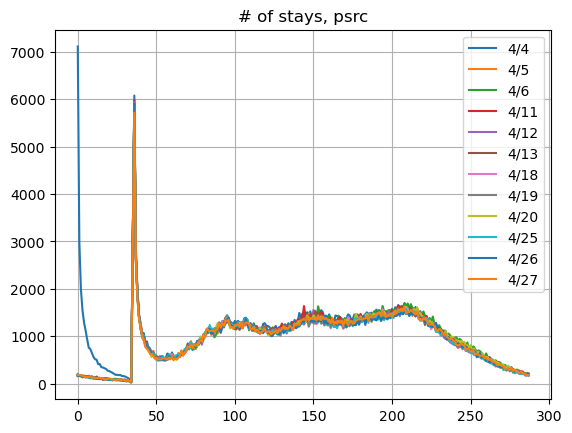

In [121]:
plt.title('# of stays, psrc')
for i in range(trip_stay_ct.shape[0]):
    plt.plot(trip_stay_ct.loc[i, 0:], label='4/'+str(trip_stay_ct.day[i]))
plt.legend()
plt.grid()

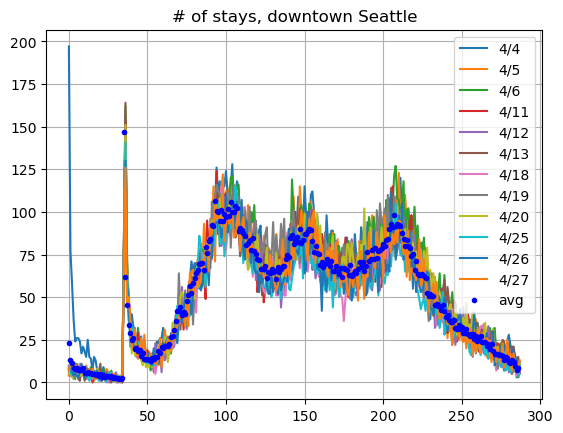

In [161]:
trip_stay_ct = trip_stay_ct.replace(np.nan, 0)
avg_val = np.sum(trip_stay_ct.loc[:, 0:].to_numpy(), axis=0)/(np.count_nonzero(trip_stay_ct.loc[:, 0:].to_numpy(), axis=0))
print('max loc', np.argmax(avg_val))
print('max value',  trip_stay_ct.loc[:, 36].values)

plt.title('# of stays, downtown Seattle')
for i in range(trip_stay_ct.shape[0]):
    plt.plot(trip_stay_ct.loc[i, 0:], label='4/'+str(trip_stay_ct.day[i]))
plt.plot(avg_val, 'b.', label='avg')
plt.legend()
plt.grid()

In [183]:
trip_stay_ct.columns

Index(['5min', 0], dtype='object')

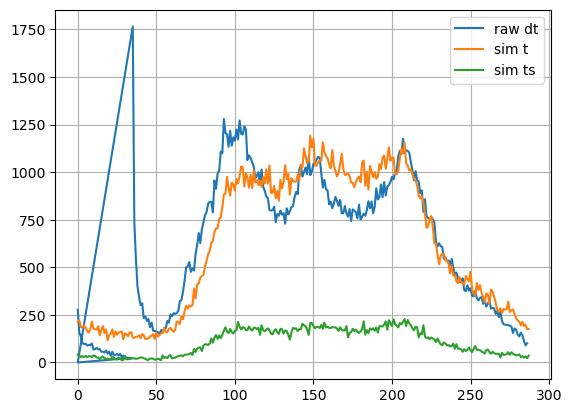

In [194]:
trip_stay_ct = trip_stay.groupby(by=['5min', 'field_1']).size().to_frame()
trip_stay_ct = trip_stay.groupby(by=['5min']).size().to_frame()
trip_stay_ct.reset_index(inplace=True)

insert_35 = pd.DataFrame([[35, 0]], columns=['5min', 0])
trip_stay_ct = pd.concat([trip_stay_ct, insert_35])
trip_stay_ct = trip_stay_ct.sort_values(by=['5min'])
plt.plot(trip_stay_ct[0], label='raw dt')

fcd_test = (fcd_dt[fcd_dt['sim_t']==1]).groupby(by=['time_5_new', 'reids']).size().to_frame()
fcd_test = fcd_test.groupby(by=['time_5_new']).size().to_frame()
plt.plot(fcd_test[0], label = 'sim t')

fcd_test = (fcd_dt[fcd_dt['sim_ts']==1]).groupby(by=['time_5_new', 'reids']).size().to_frame()
fcd_test = fcd_test.groupby(by=['time_5_new']).size().to_frame()
plt.plot(fcd_test[0], label = 'sim ts')

plt.legend()
plt.grid()

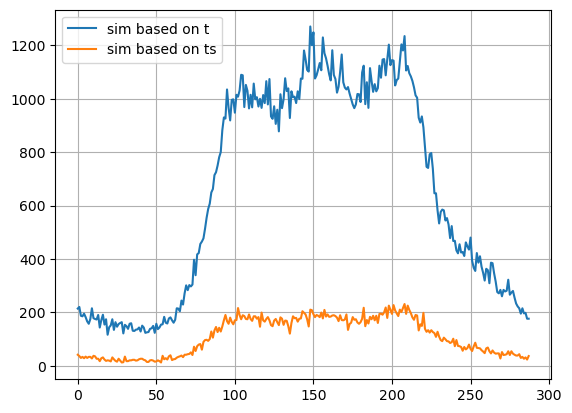

In [172]:
plt.plot(fcd_dt.groupby(by=['time_5_new']).sum()['sim_t'], label='sim based on t')
plt.plot(fcd_dt.groupby(by=['time_5_new']).sum()['sim_ts'], label='sim based on ts')
plt.legend()
plt.grid()

### NMF test

In [168]:
#!pip install implicit

In [5]:
def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def convert_timedic2mx(time_dict):
    #dataDict = {'device1':(1,1,0,1), 'device2':(0,1,0,1), 'device3':(1,0,0,1)}
    #orderedNames = ['device1','device2','device3']
    times = list(time_dict.keys())
    dataMatrix = np.array([time_dict[i] for i in times])
    return(dataMatrix)

def get_missing_rate(time_index_mx, input_mx_indi):
    indi_m = input_mx_indi[time_index_mx]
    return(np.count_nonzero(np.sum(indi_m,axis=1))/(indi_m.shape[0]))

def check_missings(fcd_dt, sim_col, time_interval, plot_idx=True):
    input_mx = getinput_mx(fcd_dt, sim_col)
    num_taz = int(input_mx.shape[1]/time_interval)
    #print('num taz', num_taz)
    time_dic = get_pred_timedict(num_taz, time_interval)
    time_mx = convert_timedic2mx(time_dic)
    missing_rate = []
    for i in range(input_mx.shape[0]):
        missing_rate.append(get_missing_rate(time_mx, input_mx[i,]))
        #print(missing_rate)
    if plot_idx == True:
        plt.hist(missing_rate)
        plt.title('hist of non-missing rate')
        plt.xlabel('non-missing rate')
        plt.ylabel('# of ids')
        print(max(missing_rate))
        print(min(missing_rate))
    return(np.array(missing_rate))

In [9]:
#read fcd_dt
path = "G:/My Drive/2021/Bias/SUMO_simulation/appsim/"
os.chdir(path)
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

#somehow the code below
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv')
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv')
#fcd_dt.set_index('Unnamed: 0')
#colnames = fcd_dt.columns
#fcd_dt = fcd_dt[colnames[1:]]
#fcd_dt.head(3)

#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)
fcd_dt = check_fcd_dt(fcd_dt)
fcd_dt['all'] = 1

C:\Users\flwang\AppData\Local\Temp\ipykernel_16052\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


0.13194444444444445
0.006944444444444444


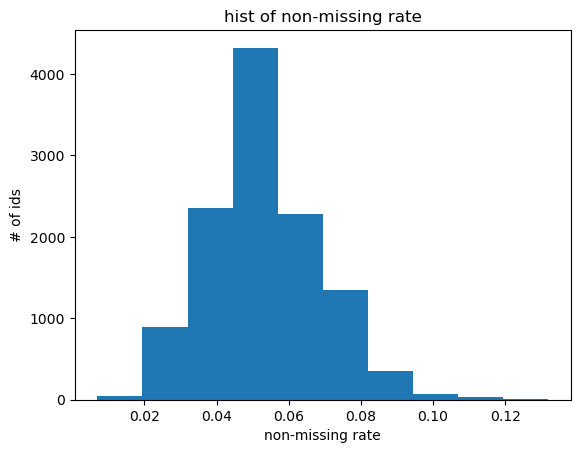

In [7]:
missing_info = check_missings(fcd_dt, 'sim_t', 288)

In [ ]:
def fit_process_dt_als(sim_dt, missing_info, missing_val, k_val, reg_val, iter_val, alpha_val):
    model = implicit.als.AlternatingLeastSquares(factors=k_val, regularization=reg_val, iterations=iter_val)
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    ix = np.nonzero(fit_dt)
    sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))

    alpha = 15
    data = (sparse_fit_dt * alpha).astype('double')
    model.fit(data)


In [10]:
k_val = 100
reg_val=0.1
iter_val=1000
missing_val = 0.1

In [175]:
model = implicit.als.AlternatingLeastSquares(factors=k_val, regularization=reg_val, iterations=iter_val)
fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
ix = np.nonzero(fit_dt)
sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))

alpha = 15
data = (sparse_fit_dt * alpha).astype('double')
model.fit(data)
recommended = model.recommend(user_id, sparse_user_item)

C:\Users\flwang\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
C:\Users\flwang\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0 seconds
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [156]:
fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
ix = np.nonzero(fit_dt)
sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))
model = NMF(n_components=10, init='random', random_state=0).fit(sparse_fit_dt)

reconstructed = model.inverse_transform(model.transform(sparse_fit_dt))

C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Text(0.5, 0, 'with data larger than the value of non-missing rate')

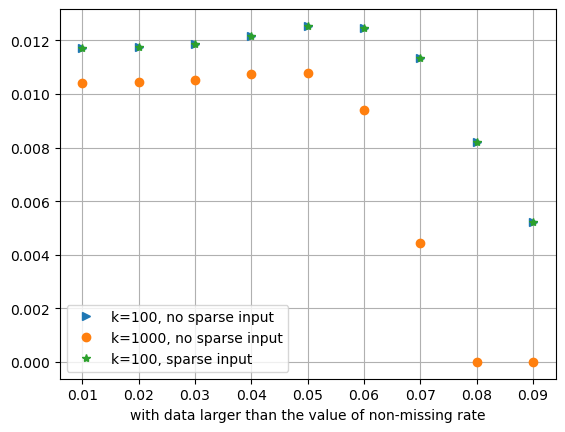

In [35]:
'''
#model fitting
rmse_sparse_100 = []
rmse_1000 = []
for i in 0.01*np.array(range(1, 10)):
    rmse_1000.append(fit_process_dt_nmf(sim_dt, missing_info, i, 1000))
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))

#fit_process_dt(sim_dt, missing_info, 0.05, 100)
rmse_100 = []
for i in 0.01*np.array(range(1, 10)):
    rmse_100.append(fit_process_dt_nmf(sim_dt, missing_info, i, 100)) 
    
plt.plot(0.01*np.array(range(1, 10)), rmse_100)

rmse_sparse_100 = []
for i in 0.01*np.array(range(1, 10)):
    #rmse_1000.append(fit_process_dt_nmf(sim_dt, missing_info, i, 1000))
    rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))'''
    
x_val = 0.01*np.array(range(1, 10))
rmse_100=[0.011718845062469205, 0.011733566569767748, 0.011857189689905543, 0.012175408280241933, 0.012537902574912135,
           0.012457821394958409, 0.011329832116100173, 0.008197304995008576, 0.0052040000840710594]
rmse_1000=[0.01041351437826548, 0.0104274850937627,  0.010524527034268325,  0.010755422840983998,  0.010787891532978048,
            0.009383739592580412, 0.004444300292862119, 1.9005788237971548e-06, 2.131343920457339e-09]
rmse_sparse_100=[0.011718841162099456, 0.01173356430113694, 0.011857190456366247, 0.012175403560653397, 0.012537900529530301,
                 0.012457821977194907, 0.011329854774437592, 0.008197283856768963, 0.0052039184389672385]
plt.plot(x_val, rmse_100, '>', label='k=100, no sparse input')
plt.plot(x_val, rmse_1000, 'o', label='k=1000, no sparse input')
plt.plot(x_val, rmse_sparse_100, '*', label='k=100, sparse input')
plt.legend()
plt.grid()
plt.xlabel('with data larger than the value of non-missing rate')

In [ ]:
sim_dt_all = getinput_mx(fcd_dt, 'all')

#get non zero loc in sumo simulation data
non_zero_loc = np.where(sim_dt_all>0)
missing_rate = 0.05

#conver data type from tuple to array
non_zero_loc = np.array(non_zero_loc)

#conduct missingness simulation 
#complete random - method 1
test_non_zero_loc = np.random.choice(list(range(non_zero_loc.shape[1])), 
                                     size=int((non_zero_loc.shape[1])*missing_rate))
sim_missings = non_zero_loc[:, test_non_zero_loc]

#revise the true data into sim missing data
sim_dt_all_wmiss = sim_dt_all.copy()
sim_dt_all_wmiss[tuple(sim_missings)] = 0

#missing based on cuebiq data pattern
sim_dt = getinput_mx(fcd_dt, 'sim_t')
print('missing rate, based on t',
      np.array(np.where(sim_dt>0)).shape[1]/np.array(np.where(sim_dt_all>0)).shape[1])

sim_dt = getinput_mx(fcd_dt, 'sim_ts')
print('missing rate, based on ts',
      np.array(np.where(sim_dt>0)).shape[1]/np.array(np.where(sim_dt_all>0)).shape[1])

In [11]:
#conduct missingness simulation
#based on time variation (manipulated)
'''original time = [0.18410042, 0.08786611, 0.15899582, 0.12552301, 0.12552301,
       0.09623431, 0.09205021, 0.10041841, 0.09205021, 0.11297071,
       0.07112971, 0.12552301, 0.12133891, 0.09205021, 0.09205021,
       0.09623431, 0.09205021, 0.07949791, 0.07531381, 0.07112971,
       0.05439331, 0.09623431, 0.06694561, 0.09623431, 0.06276151,
       0.06694561, 0.12552301, 0.07531381, 0.08368201, 0.09623431,
       0.10460251, 0.11297071, 0.12133891, 0.09205021, 0.11715481,
       0.08786611, 0.10041841, 0.10878661, 0.07531381, 0.10878661,
       0.09205021, 0.07112971, 0.12133891, 0.07531381, 0.05857741,
       0.05020921, 0.09205021, 0.06276151, 0.12133891, 0.11715481,
       0.09623431, 0.07112971, 0.10041841, 0.07949791, 0.07949791,
       0.08368201, 0.11715481, 0.11297071, 0.10460251, 0.14644351,
       0.12552301, 0.08786611, 0.08368201, 0.12970711, 0.13389121,
       0.09205021, 0.11715481, 0.12970711, 0.11297071, 0.22175732,
       0.22175732, 0.21338912, 0.17573222, 0.22175732, 0.23849372,
       0.27196653, 0.32635983, 0.32635983, 0.34309623, 0.34728033,
       0.30125523, 0.38075314, 0.35146444, 0.37238494, 0.38493724,
       0.35564854, 0.43514644, 0.44769874, 0.56903766, 0.51882845,
       0.55230126, 0.52301255, 0.60251046, 0.68200837, 0.64435146,
       0.68200837, 0.68619247, 0.75313808, 0.76150628, 0.71966527,
       0.84100418, 0.74058577, 0.84518828, 0.82426778, 0.74476987,
       0.79079498, 0.66945607, 0.70711297, 0.84937238, 0.78242678,
       0.70711297, 0.82008368, 0.74895397, 0.70292887, 0.70292887,
       0.78661088, 0.64016736, 0.81589958, 0.69456067, 0.68619247,
       0.68619247, 0.73640167, 0.59414226, 0.67364017, 0.64853556,
       0.68619247, 0.72384937, 0.60669456, 0.62343096, 0.73221757,
       0.72803347, 0.61506276, 0.72803347, 0.67364017, 0.66108787,
       0.56066946, 0.71548117, 0.66527197, 0.64435146, 0.74895397,
       0.76569038, 0.74058577, 0.68619247, 0.78242678, 0.74895397,
       0.79916318, 0.75313808, 0.73640167, 0.92050209, 0.89958159,
       0.88702929, 0.80753138, 0.83682008, 0.73221757, 0.76150628,
       0.76569038, 0.79497908, 0.69456067, 0.90794979, 0.73221757,
       0.76569038, 0.73640167, 0.75313808, 0.74058577, 0.64016736,
       0.84100418, 0.69456067, 0.66527197, 0.85355649, 0.70292887,
       0.78661088, 0.66108787, 0.67782427, 0.71129707, 0.66527197,
       0.75732218, 0.74058577, 0.77405858, 0.62343096, 0.62343096,
       0.77824268, 0.66527197, 0.84100418, 0.70711297, 0.78242678,
       0.76150628, 0.72803347, 0.71548117, 0.69456067, 0.79079498,
       0.61924686, 0.67364017, 0.72384937, 0.84100418, 0.80334728,
       0.76569038, 0.81171548, 0.76987448, 0.79079498, 0.88284519,
       0.82845188, 0.81589958, 0.85355649, 0.83263598, 0.77824268,
       0.87029289, 0.73640167, 1.        , 0.87029289, 0.75732218,
       0.82845188, 0.83263598, 0.87866109, 0.71548117, 0.86610879,
       0.80753138, 0.76569038, 0.56903766, 0.64853556, 0.75732218,
       0.67364017, 0.52301255, 0.50627615, 0.53138075, 0.53974895,
       0.60251046, 0.50209205, 0.48535565, 0.49790795, 0.41841004,
       0.42259414, 0.40167364, 0.37656904, 0.37656904, 0.42677824,
       0.40585774, 0.35146444, 0.33054393, 0.33054393, 0.31380753,
       0.32635983, 0.29288703, 0.27615063, 0.31380753, 0.32217573,
       0.30962343, 0.29288703, 0.31799163, 0.22175732, 0.29707113,
       0.28033473, 0.32635983, 0.29707113, 0.28870293, 0.28451883,
       0.22175732, 0.20083682, 0.26359833, 0.25941423, 0.23430962,
       0.27196653, 0.21757322, 0.20502092, 0.25104603, 0.23430962,
       0.14644351, 0.22175732, 0.12970711, 0.25104603, 0.15062762,
       0.23430962, 0.17991632, 0.17991632, 0.24267782, 0.16317992,
       0.19665272, 0.17573222, 0.21338912, 0.18410042, 0.10878661,
       0.10460251, 0.11715481, 0.12133891, 0.18410042, 0.13389121,
       0.12133891, 0.10460251, 0.10460251]'''
#current time_per = 
#time_per_manip = time_per.copy()
#time_per_manip[np.where(time_per>0.9)] = 1
#time_per_manip[np.where(time_per<0.9)] += 0.1 
time_per_manip=[0.28410042, 0.18786611, 0.25899582, 0.22552301, 0.22552301,
       0.19623431, 0.19205021, 0.20041841, 0.19205021, 0.21297071,
       0.17112971, 0.22552301, 0.22133891, 0.19205021, 0.19205021,
       0.19623431, 0.19205021, 0.17949791, 0.17531381, 0.17112971,
       0.15439331, 0.19623431, 0.16694561, 0.19623431, 0.16276151,
       0.16694561, 0.22552301, 0.17531381, 0.18368201, 0.19623431,
       0.20460251, 0.21297071, 0.22133891, 0.19205021, 0.21715481,
       0.18786611, 0.20041841, 0.20878661, 0.17531381, 0.20878661,
       0.19205021, 0.17112971, 0.22133891, 0.17531381, 0.15857741,
       0.15020921, 0.19205021, 0.16276151, 0.22133891, 0.21715481,
       0.19623431, 0.17112971, 0.20041841, 0.17949791, 0.17949791,
       0.18368201, 0.21715481, 0.21297071, 0.20460251, 0.24644351,
       0.22552301, 0.18786611, 0.18368201, 0.22970711, 0.23389121,
       0.19205021, 0.21715481, 0.22970711, 0.21297071, 0.32175732,
       0.32175732, 0.31338912, 0.27573222, 0.32175732, 0.33849372,
       0.37196653, 0.42635983, 0.42635983, 0.44309623, 0.44728033,
       0.40125523, 0.48075314, 0.45146444, 0.47238494, 0.48493724,
       0.45564854, 0.53514644, 0.54769874, 0.66903766, 0.61882845,
       0.65230126, 0.62301255, 0.70251046, 0.78200837, 0.74435146,
       0.78200837, 0.78619247, 0.85313808, 0.86150628, 0.81966527,
       0.94100418, 0.84058577, 0.94518828, 0.92426778, 0.84476987,
       0.89079498, 0.76945607, 0.80711297, 0.94937238, 0.88242678,
       0.80711297, 0.92008368, 0.84895397, 0.80292887, 0.80292887,
       0.88661088, 0.74016736, 0.91589958, 0.79456067, 0.78619247,
       0.78619247, 0.83640167, 0.69414226, 0.77364017, 0.74853556,
       0.78619247, 0.82384937, 0.70669456, 0.72343096, 0.83221757,
       0.82803347, 0.71506276, 0.82803347, 0.77364017, 0.76108787,
       0.66066946, 0.81548117, 0.76527197, 0.74435146, 0.84895397,
       0.86569038, 0.84058577, 0.78619247, 0.88242678, 0.84895397,
       0.89916318, 0.85313808, 0.83640167, 1.        , 0.99958159,
       0.98702929, 0.90753138, 0.93682008, 0.83221757, 0.86150628,
       0.86569038, 0.89497908, 0.79456067, 1.        , 0.83221757,
       0.86569038, 0.83640167, 0.85313808, 0.84058577, 0.74016736,
       0.94100418, 0.79456067, 0.76527197, 0.95355649, 0.80292887,
       0.88661088, 0.76108787, 0.77782427, 0.81129707, 0.76527197,
       0.85732218, 0.84058577, 0.87405858, 0.72343096, 0.72343096,
       0.87824268, 0.76527197, 0.94100418, 0.80711297, 0.88242678,
       0.86150628, 0.82803347, 0.81548117, 0.79456067, 0.89079498,
       0.71924686, 0.77364017, 0.82384937, 0.94100418, 0.90334728,
       0.86569038, 0.91171548, 0.86987448, 0.89079498, 0.98284519,
       0.92845188, 0.91589958, 0.95355649, 0.93263598, 0.87824268,
       0.97029289, 0.83640167, 1.        , 0.97029289, 0.85732218,
       0.92845188, 0.93263598, 0.97866109, 0.81548117, 0.96610879,
       0.90753138, 0.86569038, 0.66903766, 0.74853556, 0.85732218,
       0.77364017, 0.62301255, 0.60627615, 0.63138075, 0.63974895,
       0.70251046, 0.60209205, 0.58535565, 0.59790795, 0.51841004,
       0.52259414, 0.50167364, 0.47656904, 0.47656904, 0.52677824,
       0.50585774, 0.45146444, 0.43054393, 0.43054393, 0.41380753,
       0.42635983, 0.39288703, 0.37615063, 0.41380753, 0.42217573,
       0.40962343, 0.39288703, 0.41799163, 0.32175732, 0.39707113,
       0.38033473, 0.42635983, 0.39707113, 0.38870293, 0.38451883,
       0.32175732, 0.30083682, 0.36359833, 0.35941423, 0.33430962,
       0.37196653, 0.31757322, 0.30502092, 0.35104603, 0.33430962,
       0.24644351, 0.32175732, 0.22970711, 0.35104603, 0.25062762,
       0.33430962, 0.27991632, 0.27991632, 0.34267782, 0.26317992,
       0.29665272, 0.27573222, 0.31338912, 0.28410042, 0.20878661,
       0.20460251, 0.21715481, 0.22133891, 0.28410042, 0.23389121,
       0.22133891, 0.20460251, 0.20460251]
def get_bernoulli_sample(prob):
    return(np.random.binomial(1, prob, 1)[0])

def sim_based_t(fcd_dt, time_per, colname):
    get_time_sim = lambda x: get_bernoulli_sample(time_per[x])
    fcd_dt[colname] = fcd_dt['time_5_new'].apply(get_time_sim)
    return(fcd_dt)

fcd_dt = sim_based_t(fcd_dt, time_per_manip, 'sim_t2')

### Read taz file, add the $Z_0$ matrix

In [12]:
#package
#convert string to int, so as to get neighborhood taz
#input selected_taz = tazs in study area
#vals: neighbothood tazs
def str2int(vals, selected_taz, taz_dict):
    vals = vals.split(',')
    revised = []
    for val in vals:
        v = int(val)
        if v in selected_taz and v not in revised:
            revised.append(taz_dict[int(val)])
    return(revised)

#read the data
#get neighborhood taz
taz_with_nb = pd.read_csv('taz_with_ct_nb.csv')
#get tazs in study area
tazs_in_studyarea = np.unique(taz_with_nb['TAZ'])
tazs_sim = np.unique(fcd_dt['taz'])

#subtract the info
#taz dict (get index for the taz)
taz_dict = {}
for i in np.array(fcd_dt.groupby(by=['taz','taz_index']).sum().index):
    taz_dict[i[0]]=i[1]

#taz index (index for taz in fcd_dt)
taz_index = []
for i in tazs_sim:
    taz_index.append(taz_dict[i])
    
taz_nb_dict = {}
for i in range(taz_with_nb.shape[0]):
    taz_cur = taz_with_nb['TAZ'].loc[i]
    if taz_cur in tazs_in_studyarea:
        nb_taz = str2int(taz_with_nb['taz2010_revised_nb_touch'].loc[i], tazs_sim, taz_dict)
        nb_taz.append(taz_dict[taz_cur])
        #get those areas not nb or the taz per se
        taz_nb_dict[taz_cur] = list(set(taz_index)-set(nb_taz))
        
#5000 I5 north >443
#5002 I5 south >630
#5004 East south >620, 426-429
#5006 East north >545
#5008 tunnel (SR99) south >630
#5010 tunnel (SR99) north >443
def processing_pseudo_taz(taz_idx, criteria, taz_index):
    taz_index = np.array(taz_index)
    taz_nb_dict[taz_idx] = list(taz_index[np.where(tazs_sim>criteria)])
    taz_nb_dict[taz_idx].append(taz_dict[taz_idx])
    taz_nb_dict[taz_idx] = list(set(taz_index)-set(taz_nb_dict[taz_idx]))

pseudo_taz = [5000, 5002, 5004, 5006, 5008, 5010]
cri = [443, 630, 620, 545, 630, 443]

for i in range(len(pseudo_taz)):
    processing_pseudo_taz(pseudo_taz[i], cri[i], taz_index)

In [13]:
#generate zero index
Zero_index = np.zeros((len(np.unique(fcd_dt['id_index'])), 288*len(np.unique(fcd_dt['taz_index']))))

test_dt = fcd_dt[fcd_dt['sim_t2'] == 1]
times = test_dt['time_5_new'].values
ids = test_dt['id_index'].values
taz_index = test_dt['taz'].values

zero_dict_taz = {}

for i in range(test_dt.shape[0]):
    #get neighborhood taz_index
    taz_nb_index = np.array(taz_nb_dict[taz_index[i]])
    taz_nb_index = (taz_nb_index*288)+times[i]

    if ids[i] not in zero_dict_taz:
        zero_dict_taz[ids[i]] = list(taz_nb_index)
    else:
        zero_dict_taz[ids[i]].extend(list(taz_nb_index))

        
    
#get column index in the zero_dict_taz:
#delete repeated column
for ids in zero_dict_taz:
    zero_dict_taz[ids] = np.unique(zero_dict_taz[ids]) 

# for ids in zero_dict_taz:
Zero_index[ids, zero_dict_taz[ids]]=1

#check the data
np.count_nonzero(Zero_index)/(Zero_index.shape[0]*Zero_index.shape[1])
#0.45 (0.44651944457805925)

4.334811331013781e-05

In [10]:
#save the dict
with open('zero_dict_taz.txt', 'w') as f:
    for ids in zero_dict_taz:
        f.write(str(ids)+str(list(zero_dict_taz[ids]))+'\n')
f.close()

### NMF function with zero

In [14]:
#packages
import numbers
import scipy.sparse as sp
import warnings
from math import sqrt
import time

from sklearn.decomposition._cdnmf_fast import _update_cdnmf_fast #not able to be revised, visual studio version not matched
from sklearn._config import config_context
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import randomized_svd, safe_sparse_dot, squared_norm
from sklearn.utils.validation import check_is_fitted, check_non_negative

In [50]:
EPSILON = np.finfo(np.float32).eps

def norm(x):
    return sqrt(squared_norm(x))


def trace_dot(X, Y):
    return np.dot(X.ravel(), Y.ravel())


def _check_init(A, shape, whom):
    A = check_array(A)
    if np.shape(A) != shape:
        raise ValueError(
            "Array with wrong shape passed to %s. Expected %s, but got %s "
            % (whom, shape, np.shape(A))
        )
    check_non_negative(A, whom)
    if np.max(A) == 0:
        raise ValueError("Array passed to %s is full of zeros." % whom)
        

def _beta_divergence(X, W, H, beta, square_root=False):
    beta = _beta_loss_to_float(beta)

    # The method can be called with scalars
    if not sp.issparse(X):
        X = np.atleast_2d(X)
    W = np.atleast_2d(W)
    H = np.atleast_2d(H)

    # Frobenius norm
    if beta == 2:
        # Avoid the creation of the dense np.dot(W, H) if X is sparse.
        if sp.issparse(X):
            norm_X = np.dot(X.data, X.data)
            norm_WH = trace_dot(np.linalg.multi_dot([W.T, W, H]), H)
            cross_prod = trace_dot((X * H.T), W)
            res = (norm_X + norm_WH - 2.0 * cross_prod) / 2.0
        else:
            res = squared_norm(X - np.dot(W, H)) / 2.0

        if square_root:
            return np.sqrt(res * 2)
        else:
            return res

    if sp.issparse(X):
        # compute np.dot(W, H) only where X is nonzero
        WH_data = _special_sparse_dot(W, H, X).data
        X_data = X.data
    else:
        WH = np.dot(W, H)
        WH_data = WH.ravel()
        X_data = X.ravel()

    # do not affect the zeros: here 0 ** (-1) = 0 and not infinity
    indices = X_data > EPSILON
    WH_data = WH_data[indices]
    X_data = X_data[indices]

    # used to avoid division by zero
    WH_data[WH_data == 0] = EPSILON

    # generalized Kullback-Leibler divergence
    if beta == 1:
        # fast and memory efficient computation of np.sum(np.dot(W, H))
        sum_WH = np.dot(np.sum(W, axis=0), np.sum(H, axis=1))
        # computes np.sum(X * log(X / WH)) only where X is nonzero
        div = X_data / WH_data
        res = np.dot(X_data, np.log(div))
        # add full np.sum(np.dot(W, H)) - np.sum(X)
        res += sum_WH - X_data.sum()

    # Itakura-Saito divergence
    elif beta == 0:
        div = X_data / WH_data
        res = np.sum(div) - np.product(X.shape) - np.sum(np.log(div))

    # beta-divergence, beta not in (0, 1, 2)
    else:
        if sp.issparse(X):
            # slow loop, but memory efficient computation of :
            # np.sum(np.dot(W, H) ** beta)
            sum_WH_beta = 0
            for i in range(X.shape[1]):
                sum_WH_beta += np.sum(np.dot(W, H[:, i]) ** beta)

        else:
            sum_WH_beta = np.sum(WH ** beta)

        sum_X_WH = np.dot(X_data, WH_data ** (beta - 1))
        res = (X_data ** beta).sum() - beta * sum_X_WH
        res += sum_WH_beta * (beta - 1)
        res /= beta * (beta - 1)

    if square_root:
        return np.sqrt(2 * res)
    else:
        return res

def _special_sparse_dot(W, H, X):
    if sp.issparse(X):
        ii, jj = X.nonzero()
        n_vals = ii.shape[0]
        dot_vals = np.empty(n_vals)
        n_components = W.shape[1]

        batch_size = max(n_components, n_vals // n_components)
        for start in range(0, n_vals, batch_size):
            batch = slice(start, start + batch_size)
            dot_vals[batch] = np.multiply(W[ii[batch], :], H.T[jj[batch], :]).sum(
                axis=1
            )

        WH = sp.coo_matrix((dot_vals, (ii, jj)), shape=X.shape)
        return WH.tocsr()
    else:
        return np.dot(W, H)
    

def _beta_loss_to_float(beta_loss):
    """Convert string beta_loss to float."""
    allowed_beta_loss = {"frobenius": 2, "kullback-leibler": 1, "itakura-saito": 0}
    if isinstance(beta_loss, str) and beta_loss in allowed_beta_loss:
        beta_loss = allowed_beta_loss[beta_loss]
        return beta_loss
    
    elif type(beta_loss) == int:
        return beta_loss
    
    elif not isinstance(beta_loss, numbers.Number):
        raise ValueError(
            "Invalid beta_loss parameter: got %r instead of one of %r, or a float."
            % (beta_loss, allowed_beta_loss.keys())
        )
        print("warnings: beta loss not included")
    

def _initialize_nmf(X, n_components, init="warn", eps=1e-6, random_state=None):
    """Algorithms for NMF initialization.
    Computes an initial guess for the non-negative
    rank k matrix approximation for X: X = WH.
    """
    if init == "warn":
        warnings.warn(
            "The 'init' value, when 'init=None' and "
            "n_components is less than n_samples and "
            "n_features, will be changed from 'nndsvd' to "
            "'nndsvda' in 1.1 (renaming of 0.26).",
            FutureWarning,
        )
        init = None

    check_non_negative(X, "NMF initialization")
    n_samples, n_features = X.shape

    if (
        init is not None
        and init != "random"
        and n_components > min(n_samples, n_features)
    ):
        raise ValueError(
            "init = '{}' can only be used when "
            "n_components <= min(n_samples, n_features)".format(init)
        )

    if init is None:
        if n_components <= min(n_samples, n_features):
            init = "nndsvd"
        else:
            init = "random"

    # Random initialization
    if init == "random":
        avg = np.sqrt(X.mean() / n_components)
        rng = check_random_state(random_state)
        H = avg * rng.randn(n_components, n_features).astype(X.dtype, copy=False)
        W = avg * rng.randn(n_samples, n_components).astype(X.dtype, copy=False)
        np.abs(H, out=H)
        np.abs(W, out=W)
        return W, H

    # NNDSVD initialization
    U, S, V = randomized_svd(X, n_components, random_state=random_state)
    W = np.zeros_like(U)
    H = np.zeros_like(V)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, n_components):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    if init == "nndsvd":
        pass
    elif init == "nndsvda":
        avg = X.mean()
        W[W == 0] = avg
        H[H == 0] = avg
    elif init == "nndsvdar":
        rng = check_random_state(random_state)
        avg = X.mean()
        W[W == 0] = abs(avg * rng.randn(len(W[W == 0])) / 100)
        H[H == 0] = abs(avg * rng.randn(len(H[H == 0])) / 100)
    else:
        raise ValueError(
            "Invalid init parameter: got %r instead of one of %r"
            % (init, (None, "random", "nndsvd", "nndsvda", "nndsvdar"))
        )

    return W, H

def _update_coordinate_descent(X, W, Ht, l1_reg, l2_reg, shuffle, random_state):
    """Helper function for _fit_coordinate_descent.
    Update W to minimize the objective function, iterating once over all
    coordinates. By symmetry, to update H, one can call
    _update_coordinate_descent(X.T, Ht, W, ...).
    """
    n_components = Ht.shape[1]

    HHt = np.dot(Ht.T, Ht)
    XHt = safe_sparse_dot(X, Ht)

    # L2 regularization corresponds to increase of the diagonal of HHt
    if l2_reg != 0.0:
        # adds l2_reg only on the diagonal
        HHt.flat[:: n_components + 1] += l2_reg
    # L1 regularization corresponds to decrease of each element of XHt
    if l1_reg != 0.0:
        XHt -= l1_reg

    if shuffle:
        permutation = random_state.permutation(n_components)
    else:
        permutation = np.arange(n_components)
    # The following seems to be required on 64-bit Windows w/ Python 3.5.
    permutation = np.asarray(permutation, dtype=np.intp)
    return _update_cdnmf_fast(W, HHt, XHt, permutation)

def _fit_coordinate_descent(
    X,
    W,
    H,
    tol=1e-4,
    max_iter=200,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
    shuffle=False,
    random_state=None,
):
    """Compute Non-negative Matrix Factorization (NMF) with Coordinate Descent
    The objective function is minimized with an alternating minimization of W
    and H. Each minimization is done with a cyclic (up to a permutation of the
    features) Coordinate Descent.
    """
    # so W and Ht are both in C order in memory
    Ht = check_array(H.T, order="C")
    X = check_array(X, accept_sparse="csr")

    rng = check_random_state(random_state)

    for n_iter in range(1, max_iter + 1):
        violation = 0.0

        # Update W
        violation += _update_coordinate_descent(
            X, W, Ht, l1_reg_W, l2_reg_W, shuffle, rng
        )
        # Update H
        if update_H:
            violation += _update_coordinate_descent(
                X.T, Ht, W, l1_reg_H, l2_reg_H, shuffle, rng
            )

        if n_iter == 1:
            violation_init = violation

        if violation_init == 0:
            break

        if verbose:
            print("violation:", violation / violation_init)

        if violation / violation_init <= tol:
            if verbose:
                print("Converged at iteration", n_iter + 1)
            break
    #print(violation)

    return W, Ht.T, n_iter


def _multiplicative_update_w(
    X,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    gamma,
    H_sum=None,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    beta_loss = _beta_loss_to_float(beta_loss)
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)
        denominator = np.dot(W, HHt)

    else:
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            #print(beta_loss)
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt

    # Add L1 and L2 regularization
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_W = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_W **= gamma

    return delta_W, H_sum, HHt, XHt

def _multiplicative_update_h(X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma):
    beta_loss = _beta_loss_to_float(beta_loss)
    
    """Update H in Multiplicative Update NMF."""
    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        denominator = np.linalg.multi_dot([W.T, W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            print(beta_loss)
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH

    # Add L1 and L2 regularization
    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_H = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_H **= gamma

    return delta_H


def _fit_multiplicative_update(
    X,
    W,
    H,
    beta_loss="frobenius",
    max_iter=200,
    tol=1e-4,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
):
    """Compute Non-negative Matrix Factorization with Multiplicative Update.
    The objective function is _beta_divergence(X, WH) and is minimized with an
    alternating minimization of W and H. Each minimization is done with a
    Multiplicative Update.
    
    """
    start_time = time.time()

    beta_loss = _beta_loss_to_float(beta_loss)

    # gamma for Maximization-Minimization (MM) algorithm [Fevotte 2011]
    if beta_loss < 1:
        gamma = 1.0 / (2.0 - beta_loss)
    elif beta_loss > 2:
        gamma = 1.0 / (beta_loss - 1.0)
    else:
        gamma = 1.0

    # used for the convergence criterion
    error_at_init = _beta_divergence(X, W, H, beta_loss, square_root=True)
    previous_error = error_at_init

    H_sum, HHt, XHt = None, None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        delta_W, H_sum, HHt, XHt = _multiplicative_update_w(
            X, W, H, beta_loss, l1_reg_W, l2_reg_W, gamma, H_sum, HHt, XHt, update_H
        )
        W *= delta_W

        # necessary for stability with beta_loss < 1
        if beta_loss < 1:
            W[W < np.finfo(np.float64).eps] = 0.0

        # update H
        if update_H:
            delta_H = _multiplicative_update_h(
                X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma
            )
            H *= delta_H

            # These values will be recomputed since H changed
            H_sum, HHt, XHt = None, None, None

            # necessary for stability with beta_loss < 1
            if beta_loss <= 1:
                H[H < np.finfo(np.float64).eps] = 0.0

        # test convergence criterion every 10 iterations
        if tol > 0 and n_iter % 10 == 0:
            error = _beta_divergence(X, W, H, beta_loss, square_root=True)

            if verbose:
                iter_time = time.time()
                print(
                    "Epoch %02d reached after %.3f seconds, error: %f"
                    % (n_iter, iter_time - start_time, error)
                )

            if (previous_error - error) / error_at_init < tol:
                break
            previous_error = error

    # do not print if we have already printed in the convergence test
    if verbose and (tol == 0 or n_iter % 10 != 0):
        end_time = time.time()
        print(
            "Epoch %02d reached after %.3f seconds." % (n_iter, end_time - start_time)
        )

    return W, H, n_iter

def non_negative_factorization_w0(
    X,
    ZERO,
    W=None,
    H=None,
    n_components=None,
    *,
    init="warn",
    update_H=True,
    solver="cd",
    beta_loss="frobenius",
    tol=1e-4,
    max_iter=200,
    alpha="deprecated",
    alpha_W=0.0,
    alpha_H="same",
    l1_ratio=0.0,
    regularization="deprecated",
    random_state=None,
    verbose=0,
    shuffle=False,
):
    """Compute Non-negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
   
    """
    X = check_array(X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32])
    
    if type(ZERO) != int:
        zero_reg = ZEROS
    else:
        zero_reg = 0
    
    est = NMF_w0(
        n_components=n_components,
        init=init,
        solver=solver,
        beta_loss=beta_loss,
        tol=tol,
        max_iter=max_iter,
        random_state=random_state,
        alpha=alpha,
        alpha_W=alpha_W,
        alpha_H=alpha_H,
        l1_ratio=l1_ratio,
        verbose=verbose,
        shuffle=shuffle,
        regularization=regularization,
        zero_weight=zero_weight,
    )

    with config_context(assume_finite=True):
        W, H, n_iter = est._fit_transform_w0(X, zero_reg, W=W, H=H, 
                                             update_H=update_H)

    return W, H, n_iter

def check_nan(matrix, var):
    if True in np.isnan(matrix):
        print('nan in '+var)
        return(1)
    else:
        pass

def revise_nan(matrix):
    matrix[np.isnan(matrix)==True] = 0
    
def check_inf(matrix, var):
    if True in np.isinf(matrix):
        print('inf in '+var)
        return(1)
    else:
        pass
    
def check_non_zero(matrix, zero_index):
    if np.count_nonzero(zero_index) == 0:
        if np.count_nonzero(matrix) != 0:
            print('Warning, zero matrix return non zero')

def obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    beta_loss,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,
):
    beta_loss = _beta_loss_to_float(beta_loss)
        
    obj = _beta_divergence(X, W, H, beta_loss, square_root=True)
        
    if l1_reg_W != 0:
        obj += l1_reg_W*np.linalg.norm(W.flatten(order="F"), 1)
    else:
        pass
        
    if l1_reg_H != 0:
        obj += l1_reg_H*np.linalg.norm(H.flatten(order="F"), 1)
    else:
        pass
        
    if l2_reg_W != 0:
        obj += l2_reg_W*np.linalg.norm(W)
    else:
        pass
        
    if l2_reg_H != 0:
        obj += l2_reg_H*np.linalg.norm(H)
    else:
        pass
        
    if zero_weight != 0:
        obj += zero_weight*np.linalg.norm((np.multiply(np.dot(W, H), zero_reg)-np.zeros(X.shape)))
    else:
        pass
        
    return(obj)

def _gradient_update_w(
    X,
    zero_reg,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    zero_weight=0.0,
    H_sum = None,
    HHt=None,
    XHt=None,
    update_H=True,
):
    """Update W in Multiplicative Update NMF."""
    #print('X', X.shape)
    #print('zero index', zero_reg.shape)
    #print('W', W.shape)
    #print('H', H.shape)
    beta_loss = _beta_loss_to_float(beta_loss)
    
    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)
    
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)
        denominator = np.dot(W, HHt)

    else:
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt
    
    if zero_weight != 0 and type(zero_reg) != int:
        denominator += zero_weight*np.dot(np.multiply(np.dot(W, H), zero_reg), H.T)
        check_non_zero(np.dot(np.multiply(np.dot(W, H), zero_reg), H.T), zero_reg)
    
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
        
    #revise_nan(denominator)
    denominator[denominator == 0] = EPSILON
    #check_inf(numerator, 'denominator')
    
    numerator /= denominator
    delta_W = numerator
    
    return delta_W, H_sum, HHt, XHt


def _gradient_update_h(X, zero_reg, W, H, beta_loss,
                       l1_reg_H, l2_reg_H, zero_weight):
    beta_loss = _beta_loss_to_float(beta_loss)
    if type(zero_reg) != int:
        zero_matrix = np.zeros(X.shape)

    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        denominator = np.linalg.multi_dot([W.T, W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH == 0] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data == 0] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi == 0] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH
    
    #denominator = np.linalg.multi_dot([W.T, W, H])
    if zero_weight != 0 and type(zero_reg) != int:
        denominator += zero_weight*np.dot(W.T,np.multiply(np.dot(W, H), zero_reg))
        check_non_zero(np.dot(W.T,np.multiply(np.dot(W, H), zero_reg)), zero_reg)

    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON
    
   # check_nan(denominator,'denominator')
   # check_inf(denominator,'denominator')
    numerator /= denominator
    delta_H = numerator
    
    return delta_H

  
def _fit_gradient_descent_w0(
    X,
    zero_reg,
    W,
    H,
    beta_loss = "frobenius",
    tol=1e-4,
    max_iter=200,
    zero_weight=0.0,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    random_state=None,
):
    # used for the convergence criterion
    error_at_init = obj_loss_w0(
    X, 
    zero_reg,
    W, 
    H,
    beta_loss,
    zero_weight,
    l1_reg_W,
    l1_reg_H,
    l2_reg_W,
    l2_reg_H,)

    #previous_error = error_at_init
    #current_error = 0
    
    HHt, XHt = None, None
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        
        #print('iter='+str(n_iter)+' W')
        
        delta_W, H_sum, HHt, XHt = _gradient_update_w(
            X, zero_reg, W, H, beta_loss, 
            l1_reg_W, l2_reg_W, zero_weight, 
            HHt, XHt, update_H
        )
        
        W *= delta_W
        #check_nan(delta_W, 'update result delta W')
        #check_nan(W, 'update result W')
        
        # update H
        if update_H:
            #print('iter='+str(n_iter)+' H')
            delta_H = _gradient_update_h(
                X, zero_reg, W, H, beta_loss,
                l1_reg_H, l2_reg_H, zero_weight
            )
            H *= delta_H
            #check_nan(delta_H, 'update result delta H')
            #check_nan(H, 'update result H')
            
            # These values will be recomputed since H changed
            HHt, XHt = None, None
            
            #if tol > 0 and n_iter % 10 == 0:
            #    current_error = obj_loss_w0(X, zero_reg, W, H, zero_weight, l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)

            #if (previous_error - current_error) / error_at_init < tol:
            #    break
            
            #previous_error = current_error
    
    return W, H, n_iter

def zero_est_eval(est_matrix, zero_index, print_non_zero=False):
    zero_est = np.count_nonzero(np.round(np.multiply(np.round(est_matrix,0), zero_index),0))
    zero_est_index = 1 - zero_est/np.count_nonzero(zero_index)
    if print_non_zero == True:
        print(zero_est)
        return(zero_est, zero_est_index)
    else:
        return(zero_est_index)

def non_zero_est_eval(test_matrix, est_matrix, zero_index, withid=False):
    #delete estimated zeros
    if withid == True:
        test = test_matrix[:, 1:].copy() 
    else:
        test = test_matrix.copy()
        
    test = test - np.multiply(test, zero_index)
    est = est_matrix.copy()
    est = np.round(est - np.multiply(est, zero_index),0)
    rmse_ = cal_rmse(test, est, withids=False)
    mae_ = cal_mae(test, est, withids=False)
    
    return(rmse_, mae_)  


class NMF_w0(TransformerMixin, BaseEstimator):
    """Non-Negative Matrix Factorization (NMF).
    Find two non-negative matrices (W, H) whose product approximates the non-
    negative matrix X. This factorization can be used for example for
    dimensionality reduction, source separation or topic extraction.
    The objective function is:
    """

    def __init__(
        self,
        n_components=None,
        *,
        init="warn",
        solver="cd",
        beta_loss="frobenius",
        tol=1e-4,
        max_iter=200,
        random_state=None,
        alpha="deprecated",
        alpha_W=0.0,
        alpha_H="same",
        l1_ratio=0.0,
        verbose=0,
        shuffle=False,
        regularization="deprecated",
        zero_weight=0.0,
    ):
        self.n_components = n_components
        self.init = init
        self.solver = solver
        self.beta_loss = beta_loss
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.alpha = alpha
        self.alpha_W = alpha_W
        self.alpha_H = alpha_H
        self.l1_ratio = l1_ratio
        self.verbose = verbose
        self.shuffle = shuffle
        self.regularization = regularization
        self.zero_weight = zero_weight

    def _more_tags(self):
        return {"requires_positive_X": True}
    
    def _compute_regularization(self, X):
        """Compute scaled regularization terms."""
        n_samples, n_features = X.shape
        alpha_W = self.alpha_W
        alpha_H = self.alpha_W if self.alpha_H == "same" else self.alpha_H

        l1_reg_W = n_features * alpha_W * self.l1_ratio
        l1_reg_H = n_samples * alpha_H * self.l1_ratio
        l2_reg_W = n_features * alpha_W * (1.0 - self.l1_ratio)
        l2_reg_H = n_samples * alpha_H * (1.0 - self.l1_ratio)

        return l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H

    def _check_params(self, X):
        # n_components
        self._n_components = self.n_components
        if self._n_components is None:
            self._n_components = X.shape[1]
        if (
            not isinstance(self._n_components, numbers.Integral)
            or self._n_components <= 0
        ):
            raise ValueError(
                "Number of components must be a positive integer; got "
                f"(n_components={self._n_components!r})"
            )

        # max_iter
        if not isinstance(self.max_iter, numbers.Integral) or self.max_iter < 0:
            raise ValueError(
                "Maximum number of iterations must be a positive "
                f"integer; got (max_iter={self.max_iter!r})"
            )

        # tol
        if not isinstance(self.tol, numbers.Number) or self.tol < 0:
            raise ValueError(
                "Tolerance for stopping criteria must be positive; got "
                f"(tol={self.tol!r})"
            )

        # beta_loss
        beta_loss = _beta_loss_to_float(self.beta_loss)

        # solver
        allowed_solver = ("cd", "mu", "zero")
        if self.solver not in allowed_solver:
            raise ValueError(
                f"Invalid solver parameter: got {self.solver!r} instead of one of "
                f"{allowed_solver}"
            )
        if self.solver != "mu" and beta_loss not in (2, "frobenius", 1, "kullback-leibler"):
            # 'mu' is the only solver that handles other beta losses than 'frobenius'
            raise ValueError(
                f"Invalid beta_loss parameter: solver {self.solver!r} does not handle "
                f"beta_loss = {self.beta_loss!r}"
            )
        if self.solver == "mu" and self.init == "nndsvd":
            warnings.warn(
                "The multiplicative update ('mu') solver cannot update "
                "zeros present in the initialization, and so leads to "
                "poorer results when used jointly with init='nndsvd'. "
                "You may try init='nndsvda' or init='nndsvdar' instead.",
                UserWarning,
            )

        # alpha and regularization are deprecated in favor of alpha_W and alpha_H
        # TODO clean up in 1.2
        if self.alpha != "deprecated":
            warnings.warn(
                "`alpha` was deprecated in version 1.0 and will be removed "
                "in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            alpha = self.alpha
        else:
            alpha = 0.0            

        if self.regularization != "deprecated":
            warnings.warn(
                "`regularization` was deprecated in version 1.0 and will be "
                "removed in 1.2. Use `alpha_W` and `alpha_H` instead",
                FutureWarning,
            )
            allowed_regularization = ("both", "components", "transformation", None)
            if self.regularization not in allowed_regularization:
                raise ValueError(
                    f"Invalid regularization parameter: got {self.regularization!r} "
                    f"instead of one of {allowed_regularization}"
                )
            regularization = self.regularization
        else:
            regularization = "both"

        (
            self.l1_reg_W,
            self.l1_reg_H,
            self.l2_reg_W,
            self.l2_reg_H,
        ) = self._compute_regularization(X)

        return self

    def _check_w_h(self, X, zero_reg, W, H, update_H):
        # check W and H, or initialize them
        n_samples, n_features = X.shape
        if self.init == "custom" and update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            _check_init(W, (n_samples, self._n_components), "NMF (input W)")
            if H.dtype != X.dtype or W.dtype != X.dtype:
                raise TypeError(
                    "H and W should have the same dtype as X. Got "
                    "H.dtype = {} and W.dtype = {}.".format(H.dtype, W.dtype)
                )
        elif not update_H:
            _check_init(H, (self._n_components, n_features), "NMF (input H)")
            if H.dtype != X.dtype:
                raise TypeError(
                    "H should have the same dtype as X. Got H.dtype = {}.".format(
                        H.dtype
                    )
                )
            # 'mu' solver should not be initialized by zeros
            if self.solver == "mu" or type(zero_reg) != int:
                avg = np.sqrt(X.mean() / self._n_components)
                W = np.full((n_samples, self._n_components), avg, dtype=X.dtype)
            else:
                W = np.zeros((n_samples, self._n_components), dtype=X.dtype)
        else:
            W, H = _initialize_nmf(
                X, self._n_components, init=self.init, random_state=self.random_state
            )
        return W, H

    def fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None):
        """Learn a NMF model for the data X and returns the transformed data.
        This is more efficient than calling fit followed by transform.
        """
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
        )

        with config_context(assume_finite=True):
            W, H, n_iter = self._fit_transform_w0(X, zero_reg, W=W, H=H)

        self.reconstruction_err_ = _beta_divergence(
            X, W, H, self.beta_loss, square_root=True
        )

        self.n_components_ = H.shape[0]
        self.components_ = H
        self.n_iter_ = n_iter

        return W
    
    # w0 = with zero
    def _fit_transform_w0(self, X, zero_reg, y=None, W=None, H=None, 
                          update_H=True):
        """Learn a NMF model for the data X and returns the transformed data.
        """
        check_non_negative(X, "NMF (input X)")

        # check parameters
        self._check_params(X)
        
        #beta_loss = _beta_loss_to_float(self.beta_loss)
        
        if X.min() == 0 and _beta_loss_to_float(self.beta_loss) <= 0:
            raise ValueError(
                "When beta_loss <= 0 and X contains zeros, "
                "the solver may diverge. Please add small values "
                "to X, or use a positive beta_loss."
            )

        # initialize or check W and H
        W, H = self._check_w_h(X, zero_reg, W, H, update_H)

        # scale the regularization terms
        l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = self._compute_regularization(X)
        
        #print(l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H)
        
       # print(zero_reg)
       # if type(zero_reg) == int: #keep the original method when not considering the zero matrix
        if type(zero_reg) != int or self.solver == "zero":  
            #print('apply zero od method')
            W, H, n_iter = _fit_gradient_descent_w0(
                X,
                zero_reg,
                W,
                H,
                self.beta_loss,
                self.tol,
                self.max_iter,
                self.zero_weight,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,                
            )
        elif self.solver == "cd":
            print('apply cd')
            W, H, n_iter = _fit_coordinate_descent(
                X,
                W,
                H,
                self.tol,
                self.max_iter,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
                shuffle=self.shuffle,
                random_state=self.random_state,
            )
        elif self.solver == "mu":
            print('apply mu')
            W, H, n_iter = _fit_multiplicative_update(
                X,
                W,
                H,
                self.beta_loss,
                self.max_iter,
                self.tol,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
            )
    #else: #add the zero constriants
        else:
            raise ValueError("Invalid solver parameter '%s'." % self.solver)

        '''if n_iter == self.max_iter and self.tol > 0:
            warnings.warn(
                "Maximum number of iterations %d reached. Increase "
                "it to improve convergence."
                % self.max_iter,
                ConvergenceWarning,
            )'''

        return W, H, n_iter

    def fit(self, X, y=None, **params):
        """Learn a NMF model for the data X.
        """
        self.fit_transform_w0(X, **params)
        return self

    def transform(self, X):
        """Transform the data X according to the fitted NMF model.
        """
        check_is_fitted(self)
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32], reset=False
        )

        with config_context(assume_finite=True):
            W, *_ = self._fit_transform_w0(X, zero_reg, H=self.components_, update_H=False)

        return W

    def inverse_transform(self, W):
        """Transform data back to its original space.
        """
        check_is_fitted(self)
        return np.dot(W, self.components_)


In [16]:
X = np.array([[1,0,0,0,1], [1,0,0,1,0],
             [0,0,0,1,0], [1,0,0,1,1],
             [1,1,0,1,1], [1,1,0,1,1]])

zero_test = np.zeros(X.shape)
zero_test[0] += 1
zero_test[1][0] = 1

In [51]:
## simple test

def add_val2lst(val, lst):
    if init == True:
        lst = []
    lst.append(val)
    return(lst)

zero_val = []

for zero_w in 0.1*np.array(list(range(10))):
    model = NMF_w0(n_components=2, alpha=0.1, 
                   l1_ratio=0.1, zero_weight=zero_w, 
                   beta_loss='kullback-leibler',
                   solver="zero", random_state=42)
    W = model.fit_transform_w0(X, zero_test)
    H = model.components_
    WH = np.dot(W, H)
    
    zero_val.append(mean_squared_error(X, WH, squared=False))
    #print(WH)
    #zero_val.append(zero_est_eval(WH, zero_test))
    #rmse_test, mae_test = (non_zero_est_eval(X, WH, zero_test))
    #rmse_val.append(rmse_test)
    #mae_val.append(mae_test)


C:\Users\29700\AppData\Local\Temp\ipykernel_16656\2788415201.py:1149: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_16656\2788415201.py:146: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_16656\2788415201.py:1149: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\29700\AppData\Local\Temp\ipykernel_16656\2788415201.py:146: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


ValueError: non-broadcastable output operand with shape (1,2) doesn't match the broadcast shape (6,2)

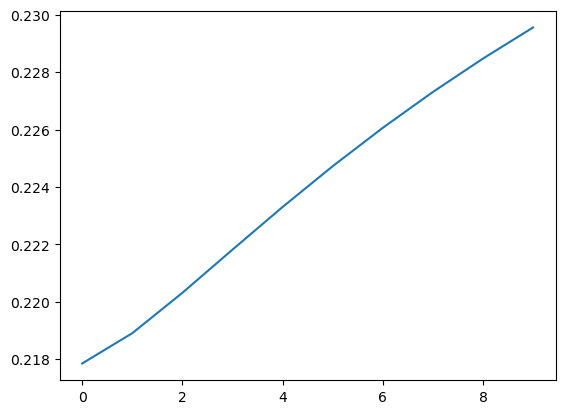

In [243]:
plt.plot(zero_val)

### Method and sensitive test package

In [19]:
#prediction based on time
#prediction based on time

def fit_process_dt_mf01(fcd_dt, tru_col, check_col, 
                      missing_info, missing_val, 
                      k_val, model_name): 
    #convert data into matrix
    result_para = []
    sim_dt = getinput_mx(fcd_dt, check_col)
    sim_dt_tru = getinput_mx(fcd_dt, tru_col)
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    fit_dt_tru = sim_dt_tru[np.where(missing_info>=missing_val)[0],]
    svd_idx = 0
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        model = NMF(n_components=k_val, init='random', random_state=0,
                   beta_loss='kullback-leibler', solver='mu')
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        #seed = 'nndsvd'
        model = nimfa.Bmf(fit_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    if model_name == 'SVD':
        u, s, v = svds(fit_dt, k=k_val)
        svd_idx = 1
        
    if svd_idx == 1:
        pred_dt = u @ np.diag(s) @ v
        print('if pred & fit dt is equal, with tol=0.01:', 
              np.allclose(pred_dt, fit_dt, atol=1e-2))
        
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
        model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)
        print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse_tru)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, fit_dt_tru, WH_index)

        result_para = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]    

        del(u, s, v, pred_dt)
        return(result_para)
    
    else:
        #check if the model fit the data well    
        if True in np.isnan(W) or True in np.isnan(H):
            print('Error, fitting data failed')
            del(W, H)
            return([0,0,0,0])

        else:
            pred_dt = np.dot(W, H)
            pred_dt = np.array(pred_dt)

            model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
            model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)
            print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse_tru)

            WH_max, WH_index = get_pred_dt(pred_dt, 288)
            ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, fit_dt_tru, WH_index)

            result_para = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]    

            del(W, H, pred_dt)
            return(result_para)
    
#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]  
def fit_process_dt_mf01_sensitive(fcd_dt, tru_col, check_col, 
                      missing_info, missing_val, 
                      model_name, para_lst): 
    #convert data into matrix
    result_para = []
    sim_dt = getinput_mx(fcd_dt, check_col)
    sim_dt_tru = getinput_mx(fcd_dt, tru_col)
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    fit_dt_tru = sim_dt_tru[np.where(missing_info>=missing_val)[0],]
    
    #predict data based on missing_rate
    if  model_name == 'NMF':
        #para_lst = [k_val, alpha_W, alpha_H, l1_ratio]
        model = NMF(n_components = para_lst[0], init='random', random_state=0,
                   alpha_W = para_lst[1], alpha_H = para_lst[2],
                   l1_ratio = para_lst[3], beta_loss='kullback-leibler',
                   solver='mu')
        W = model.fit_transform(fit_dt)
        H = model.components_

    if model_name == 'BMF':
        #some of the parameters may be reconducted
        #seed = 'nndsvd'
        #para_lst = [k_val, lambda_w, lambda_h]
        model = nimfa.Bmf(fit_dt, rank=para_lst[0], max_iter=1000, 
                          lambda_w=para_lst[1], lambda_h=para_lst[2])
        model_fit = model()
        
        W = model_fit.fit.W
        H = model_fit.fit.H
        
    #check if the model fit the data well    
    if True in np.isnan(W) or True in np.isnan(H):
        print('Error, fitting data failed')
        del(W, H)
        return([0,0,0,0])
        
    else:
        pred_dt = np.dot(W, H)
        pred_dt = np.array(pred_dt)
    
        model_rmse = mean_squared_error(fit_dt, pred_dt, squared=False)
        model_rmse_tru = mean_squared_error(fit_dt_tru, pred_dt, squared=False)

        print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+',', model_rmse)
        print('RMSE with True, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+',', model_rmse_tru)

        WH_max, WH_index = get_pred_dt(pred_dt, 288)
        ori_miss_per, mitigate_miss_per = check_pred_index(fit_dt, fit_dt_tru, WH_index)

        result_para = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]    

        del(W, H, pred_dt)
        return(result_para)


#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]    
def fit_dtbytime_sensitive(fcd_dt, sim_col, tru_col, 
                           missing_info, missing_val, time_interval, 
                           model_name, para_lst):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    sim_dt_tru = getinput_mx(fcd_dt, tru_col)
    
    #predict data based on missing_rate
    
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    fit_dt_tru = sim_dt_tru[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    result_para = {}
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        input_dt_tru = fit_dt_tru[:, time_dict[ky]]
        if model_name == 'NMF':
            #para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
            model = NMF(n_components = para_lst[0], init='random', 
                        random_state=0,
                        alpha_W = para_lst[1], alpha_H = para_lst[2],
                        l1_ratio = para_lst[3], beta_loss='kullback-leibler', solver='mu')
            #model = NMF(n_components=k_val, init='random', random_state=0)
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            #seed = 'nndsvd'
            #para_lst = [k_val, lambda_w, lambda_h]
            model = nimfa.Bmf(input_dt, rank=para_lst[0], max_iter=1000, 
                              lambda_w=para_lst[1], lambda_h=para_lst[2])
            #model = nimfa.Bmf(input_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
        
        #pred_dt = np.dot(W, H)
        #pred_dt = np.array(pred_dt)
        
        if True in np.isnan(W) or True in np.isnan(H):
            print('Error, fitting data failed')
            null_idx = 1
            del(W, H)
            result_para[ky] = [0,0,0,0]
        
        else:
            #print(WH.shape)
            pred_dt = np.dot(W, H)
            pred_dt = np.array(pred_dt)
            
            WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
            #print(WH_max.shape, WH_index.shape)

            model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)
            model_rmse_tru = mean_squared_error(input_dt_tru, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+','+ky+',', model_rmse)
            print('RMSE with True, data with missing rate>='+str(missing_val)+', para='+str(para_lst)+','+ky+',', model_rmse_tru)

            ori_miss_per, mitigate_miss_per = check_pred_indexbytime(input_dt, input_dt_tru, WH_index, num_taz, ky)

            del(WH_max, WH_index, pred_dt)
            #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
            #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
            result_para[ky] = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]
    
    return(result_para)    

    
def check_pred_index(fit_dt, fit_dt_tru, WH_index):
    WH_max_mis, WH_index_mis = get_pred_dt(fit_dt, 288)
    WH_max_tru, WH_index_tru = get_pred_dt(fit_dt_tru, 288)

    #sim var vs sim true
    ori_miss_per = 1 - (np.count_nonzero(1*((WH_index_mis == WH_index_tru)==True))/(len(WH_index_mis.flatten())))
    #sim pred vs sim true
    check_idx = np.where((1*((WH_index_mis == WH_index_tru)==True))==0)
    mitigate_miss_per  = np.count_nonzero(1*(WH_index[check_idx] == WH_index_tru[check_idx]))/(len(WH_index[check_idx]))
    
    print('% of missings (sim missing vs sim true),', ori_miss_per)
    print('% of missings mitigated,', mitigate_miss_per)
    return(ori_miss_per, mitigate_miss_per)
    
def fit_process_dt_nmf_csrsparse(sim_dt, missing_info, missing_val, k_val):
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    ix = np.nonzero(fit_dt)
    sparse_fit_dt = sparse.csc_matrix((fit_dt[ix], ix))
    model = NMF(n_components=k_val, init='random', random_state=0, 
                beta_loss='kullback-leibler', solver='mu').fit(sparse_fit_dt)
    
    reconstructed = model.inverse_transform(model.transform(sparse_fit_dt))
    model_rmse = mean_squared_error(sparse_fit_dt.toarray(), reconstructed, squared=False)
    
    print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+',', model_rmse)
    del(sparse_fit_dt, reconstructed)
    return(model_rmse)         
    

def fit_dtbytime(fcd_dt, sim_col, tru_col, 
                 missing_info, missing_val, time_interval, 
                 k_val, model_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    sim_dt_tru = getinput_mx(fcd_dt, tru_col)
    
    #predict data based on missing_rate
    
    fit_dt = sim_dt[np.where(missing_info>=missing_val)[0],]
    fit_dt_tru = sim_dt_tru[np.where(missing_info>=missing_val)[0],]
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    
    null_idx = 0
    svd_idx = 0
    result_para = {}
    for ky in time_dict:
        result_para[ky] = []
        #print(ky)
        input_dt = fit_dt[:, time_dict[ky]]
        input_dt_tru = fit_dt_tru[:, time_dict[ky]]
        if model_name == 'NMF':
            model = NMF(n_components=k_val, init='random', random_state=0,  
                        beta_loss='kullback-leibler', solver='mu')
            W = model.fit_transform(input_dt)
            H = model.components_
            
        if model_name == 'BMF':
            #some of the parameters may be reconducted
            #seed = 'nndsvd'
            model = nimfa.Bmf(input_dt, rank=k_val, max_iter=1000, lambda_w=1.1, lambda_h=1.1)
            model_fit = model()

            W = model_fit.fit.W
            H = model_fit.fit.H
        
        #pred_dt = np.dot(W, H)
        #pred_dt = np.array(pred_dt)
        if model_name == 'SVD':
            u, s, v = svds(input_dt, k=k_val)
            svd_idx = 1
        
        if svd_idx == 1:
            pred_dt = u @ np.diag(s) @ v
            print('if pred & fit dt is equal, with tol=0.01:', 
                  np.allclose(pred_dt, input_dt, atol=1e-2))

            WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
            #print(WH_max.shape, WH_index.shape)

            model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)
            model_rmse_tru = mean_squared_error(input_dt_tru, pred_dt, squared=False)

            print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse)
            print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse_tru)

            ori_miss_per, mitigate_miss_per = check_pred_indexbytime(input_dt, input_dt_tru, WH_index, num_taz,ky)

            del(WH_max, WH_index, pred_dt)
            #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
            #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
            result_para[ky] = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]
            del(u, s, v)

        else:
            if True in np.isnan(W) or True in np.isnan(H):
                print('Error, fitting data failed')
                null_idx = 1
                del(W, H)
                result_para[ky] = [0,0,0,0]

            else:
                #print(WH.shape)
                pred_dt = np.dot(W, H)
                pred_dt = np.array(pred_dt)

                WH_max, WH_index = get_pred_dt_time(pred_dt, num_taz)
                #print(WH_max.shape, WH_index.shape)

                model_rmse = mean_squared_error(input_dt, pred_dt, squared=False)
                model_rmse_tru = mean_squared_error(input_dt_tru, pred_dt, squared=False)

                print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse)
                print('RMSE with True, data with missing rate>='+str(missing_val)+', k='+str(k_val)+','+ky+',', model_rmse_tru)

                ori_miss_per, mitigate_miss_per = check_pred_indexbytime(input_dt, input_dt_tru, WH_index, num_taz, ky)

                del(WH_max, WH_index, pred_dt, W, H)
                #pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
                #pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')
                result_para[ky] = [model_rmse, model_rmse_tru, ori_miss_per, mitigate_miss_per]
    
    return(result_para)
        

def check_pred_indexbytime(fit_dt, fit_dt_tru, WH_index, num_taz, ky):
    WH_max_mis, WH_index_mis = get_pred_dt_time(fit_dt, num_taz)
    WH_max_tru, WH_index_tru = get_pred_dt_time(fit_dt_tru, num_taz)

    #sim var vs sim true
    ori_miss_per = 1 - (np.count_nonzero(1*((WH_index_mis == WH_index_tru)==True))/(len(WH_index_mis.flatten())))
    #sim pred vs sim true
    check_idx = np.where((1*((WH_index_mis == WH_index_tru)==True))==0)
    mitigate_miss_per  = np.count_nonzero(1*(WH_index[check_idx] == WH_index_tru[check_idx]))/(len(WH_index[check_idx]))
    
    print('% of missings (sim missing vs sim true),'+ky+',', ori_miss_per)
    print('% of missings mitigated,'+ky+',', mitigate_miss_per)
    return(ori_miss_per, mitigate_miss_per)

def get_pred_dt_time(WH_pred, num_taz):
    #print('num taz', num_taz)
    time_interval = int(WH_pred.shape[1]/num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T) 


def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def add_result2dict(result_para, result_para_time, result_para_dict):
    result_para_dict = add_val(result_para, 'ori', result_para_dict)
    result_para_dict = add_val(result_para_time['mor'], 'mor', result_para_dict)
    result_para_dict = add_val(result_para_time['noon'], 'noon', result_para_dict)
    result_para_dict = add_val(result_para_time['eve'], 'eve', result_para_dict)
    result_para_dict = add_val(result_para_time['other'], 'other', result_para_dict)
    return(result_para_dict)
    
    
def add_val(result_val, ky, result_para_dict):    
    result_para_dict[ky]['rmse_predvssim'].append(result_val[0])
    result_para_dict[ky]['rmse_predvstrue'].append(result_val[1])
    result_para_dict[ky]['per of missings (sim missing vs sim true)'].append(result_val[2])
    result_para_dict[ky]['per of missings mitigated'].append(result_val[3])
    return(result_para_dict)

#plot the results
def plot_paras(result_para_dict, xval, kval, missinginfo, ypop):
    plot_popidx = 0
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        plt.title('model:k='+str(kval)+', use '+missinginfo)
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(1)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel('RMSE, sim vs pred')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(2)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel('RMSE, sim true vs pred')
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(3)
        plt.plot(xval, result_para_dict[ky][paras[2]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[2])
        plt.legend()
        
        plt.figure(4)
        plt.plot(xval, result_para_dict[ky][paras[3]], label=ky)
        plt.grid()
        plt.xlabel('data > non-missing rate')
        plt.ylabel(paras[3])
        #label = f"({x},{y})"
        plt.legend()
        if ypop != -1:
            if plot_popidx == 0:
                for i in range(len(xval)):
                    label =  f"{ypop[i]}"

                    plt.annotate(label, # this is the text
                                 (xval[i], 0.015), # these are the coordinates to position the label
                                 textcoords="offset points", # how to position the text
                                 xytext=(0,10), # distance from text to points (x,y)
                                 ha='center') # horizontal alignment can be left, right or center
                plot_popidx = 1
                

def plot_paras_sensitive(result_para_dict, xval, paras_intest, para_loc, idx):
    xval = np.array(xval)[:, para_loc]
    x_val = []
    for x in xval:
        if x < 1:
            x_val.append(round(x, 2))
        else: 
            x_val.append(x)

    #convert xval from number to string
    xval = list(map(str, list(x_val)))
    for ky in result_para_dict:
        #plt.figure(idx)
        paras = list(result_para_dict[ky].keys())
        #print(paras)
        #fig.tight_layout()
        
        #ax[0].set_title('RMSE')
        #print(result_para_dict[ky][paras[0]])
        plt.figure(idx)
        plt.title('sensitive test, test para: '+paras_intest)
        plt.plot(xval, result_para_dict[ky][paras[0]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('RMSE, sim vs pred')
        #ax[0, 0].legend()
        plt.legend()
        
        plt.figure(idx+1)
        plt.plot(xval, result_para_dict[ky][paras[1]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('RMSE, sim true vs pred')
        #ax[0, 1].legend()
        plt.legend()
        
        plt.figure(idx+2)
        plt.plot(xval, result_para_dict[ky][paras[3]], label=ky)
        plt.grid()
        plt.xlabel(paras_intest)
        plt.xticks(rotation=45)
        plt.ylabel('rate'+paras[3][3:])
        #label = f"({x},{y})"
        plt.legend()  

    return(idx+3) 
        
def save_result_dict(result_dict, savename):
    # create json object from dictionary
    #json = json.dumps(result_dict)
    # open file for writing, "w" 
    f = open(savename,"w")
    # write json object to file
    f.write(str(result_dict))
    # close file
    f.close()
    
def fit_model_get_para(fcd_dt, check_col, k_val, 
                       x_val, time_interval, 
                       result_para_dict, model_name,
                       change_k=False):
    missing_info = check_missings(fcd_dt, check_col, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    if change_k == True:
        for i in k_val:
            result_para = fit_process_dt_mf01(fcd_dt, 'all', check_col, missing_info, x_val, i, model_name)
            result_para_time = fit_dtbytime(fcd_dt, check_col, 'all', missing_info, x_val, 12, i, model_name)
            result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
    else:
        for i in x_val:
            result_para = fit_process_dt_mf01(fcd_dt, 'all', check_col, missing_info, i, k_val, model_name)
            result_para_time = fit_dtbytime(fcd_dt, check_col, 'all', missing_info, i, 12, k_val, model_name)
            result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
            #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

def fit_model_get_para_sensitive(fcd_dt, check_col, para_lst, missing_val, time_interval, result_para_dict, model_name):
    missing_info = check_missings(fcd_dt, check_col, time_interval, False)
    result_para_dict_return = copy.deepcopy(result_para_dict)
    for paras in para_lst:
        result_para = fit_process_dt_mf01_sensitive(fcd_dt, 'all', check_col, 
                                                  missing_info, missing_val,  
                                                  model_name, paras)
        result_para_time = fit_dtbytime_sensitive(fcd_dt, check_col, 'all', 
                                        missing_info, missing_val, 12, 
                                        model_name, paras)
        result_para_dict_return = add_result2dict(result_para, result_para_time, result_para_dict_return)
        #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    return(result_para_dict_return)

In [49]:
#fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, 0.09, 10)
#fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, 0.09, 12, 10)

In [9]:
result_para_dict = {'ori':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
              'mor':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
               'noon':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
               'eve':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]},
               'other':{'rmse_predvssim':[],
                     'rmse_predvstrue':[],
                     'per of missings (sim missing vs sim true)':[],
                     'per of missings mitigated':[]}
              }

In [55]:
#sim_dt = getinput_mx(fcd_dt, 'sim_t')
#sim_dt = sim_dt[np.where(missing_info>=0.01)[0],]

In [217]:
#x_val_simt = 0.01*np.array(range(1, 10))

#result_para_dict_simt_nmf_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'NMF')
#result_para_dict_simt_bmf_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'BMF')

In [46]:
#x_val_simt2 = (0.02*np.array(range(22, 32)))+0.01
#result_para_dict_simt2_bmf_100 = fit_model_get_para(fcd_dt, 'sim_t2', 100, x_val_simt2, 288, result_para_dict, 'BMF')
#handle the data based on the model
'''
with open('result_para_simt2_k100_bmf.txt', 'r') as f:
    lines = f.readlines()
f.close()
paras = []
for i in lines:
    paras.append(float((i.split(' ')[-1]).split('\n')[0]))
paras = np.array(paras)    
paras = paras.reshape(int(len(paras)/4), 4)
for i in range(int(len(paras)/5)):
    s_idx = i*5
    e_idx = (i+1)*5
    if i == 0:
        para = paras[s_idx:e_idx, ]
        para = para.flatten()
        para = para.reshape(len(para), 1)
    else:
        para_cur = paras[s_idx:e_idx, ]
        para_cur = para_cur.flatten()
        para_cur = para_cur.reshape(len(para_cur), 1)
        para = np.hstack((para, para_cur))
        
paras = para
del(para)

idx = 0
for ky in result_para_dict_simt2_bmf_100:
    for para in result_para_dict_simt2_bmf_100[ky]:
        result_para_dict_simt2_bmf_100[ky][para] = list(paras[idx])
        idx += 1
result_para_dict_simt2_bmf_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt2_bmf_100)
 '''       

### Sensitive test

In [235]:
def generate_paralst(test_valrange, val_loc, other_val, para_len):
    para_lst = []
    add_para_cb = []
    idx = 0
    if len(val_loc) == 1:
        for i in range(para_len):
            if i in val_loc:
                add_para_cb.append(0)
            else:
                add_para_cb.append(other_val[idx])
                idx += 1
        #print(add_para_cb)        
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc[0]] = test_valrange[j]
            para_lst.append(add_para_cb_cur)
        
    else:
        add_para_cb = np.zeros(para_len)
        idx = 0
        for i in range(para_len):
            if i not in val_loc:
                add_para_cb[i] = other_val[idx]
                idx += 1
        for j in range(len(test_valrange)):
            add_para_cb_cur = copy.deepcopy(add_para_cb)
            add_para_cb_cur[val_loc] = test_valrange[j]
            para_lst.append(list(add_para_cb_cur))
    
    #conver type k to int
    for i in range(len(para_lst)):
        para_lst[i][0] = int(para_lst[i][0])    
    
    return(para_lst)

def get_num_txt(line):
    nums = re.findall("\d+", line)
    est_ = nums[-2]+'.'+nums[-1]
    return(float(est_))


def get_para_dt(txt_file, result_para_dict):    
    with open(txt_file, 'r') as f:
        lines = f.readlines()
    f.close()
    
    para_result =  copy.deepcopy(result_para_dict)
    paras = list(para_result['ori'].keys())

    event_idx = 0
    start_idx = 0


    for l in lines:
        if l=='\n':
            pass
        else:
            if 'mor' in l or event_idx == 1:
                event_idx = 1
                est_val = get_num_txt(l)
                para_result['mor'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'eve' in l or event_idx == 3:
                event_idx = 3
                est_val = get_num_txt(l)
                para_result['eve'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'noon' in l or event_idx == 2:
                event_idx = 2
                est_val = get_num_txt(l)
                para_result['noon'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            elif 'other' in l or event_idx == 4:
                event_idx = 4
                est_val = get_num_txt(l)
                para_result['other'][paras[start_idx%4]].append(est_val)
                if start_idx%4 == 3:
                    event_idx = 0

            else:
                est_val = get_num_txt(l)
                para_result['ori'][paras[start_idx%4]].append(est_val)
            start_idx += 1
    
    return(para_result)

In [236]:
k_nmf = generate_paralst(list(np.array(range(1, 21))*10), [0], [0, 0, 0], 4)
k_nmf_100 = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0], 4)
#after check k k=700
aWaH_nmf = generate_paralst([0.01, 0.1, 1, 10, 100], [1,2], [100, 0.5], 4)
#aW_nmf = generate_paralst([0.01, 0.1, 1, 10, 100], [1], [700, 0, 0], 4)
#aH_nmf = generate_paralst([0.01, 0.1, 1, 10, 100], [2], [700, 0, 0], 4)
#aW_nmf_1 = generate_paralst(list(np.array(range(1, 11))*0.2), [1], [100, 0.1, 0], 4)
#aH_nmf_1 = generate_paralst(list(np.array(range(1, 11))*0.2), [1], [100, 0.1, 0], 4)
aWaH_nmf_1 = generate_paralst(list(np.array(range(1, 20))*0.2), [1,2], [100, 0.1], 4)
l1_ratio_nmf = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 0, 0], 4)


k_bmf =  generate_paralst(list(np.array(range(1, 21))*10), [0], [1.1, 1.1], 3)
#after check k, k=40
lw_bmf =  generate_paralst(list(np.array(range(0, 21))*0.2), [1], [40, 1.1], 3)
lh_bmf =  generate_paralst(list(np.array(range(0, 21))*0.2), [2], [40, 1.1], 3)
lwlh_bmf = generate_paralst(list(np.array(range(0, 21))*0.2), [1,2], [40], 3)

In [13]:
#l1_ratio_nmf = generate_paralst(list(np.array(range(6, 11))*0.1), [3], [700, 0, 0], 4)
#k_nmf = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0], 4)

In [106]:
test_k_nmf_100 = get_para_dt('result_para_simt_sensk_nmf_betaloss.txt', result_para_dict)

##### NMF vs BMF sensitive test

In [20]:
test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf_100, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0], 0.01263532505201235
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0], 0.05879072123055703
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.35747104564416554


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],mor, 0.014698131592701032
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],mor, 0.06302897919237925
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.023989251599916443
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],noon, 0.020083983769911846
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],noon, 0.0682467889933743
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.33520105652442295
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],eve, 0.015831136204656926
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],eve, 0.06346728218521058
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.029051251302416106
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],other, 0.005141340290431893
RMSE with True, data with missing rate>=0.05, para=[10

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0], 0.012560519017558194
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0], 0.05882477787009622
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.2825399593381222


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],mor, 0.014440279372249185
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],mor, 0.06294356161068372
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.017741506675022313
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],noon, 0.02002161988882496
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],noon, 0.0683539920306817
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.230874764855543
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],eve, 0.01558460766103296
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],eve, 0.06339620521283915
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.01955590068217115
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],other, 0.005067082155127967
RMSE with True, data with missing rate>=0.05, para=[200, 0,

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[300, 0, 0, 0], 0.012478996995486493
RMSE with True, data with missing rate>=0.05, para=[300, 0, 0, 0], 0.058845855899889984
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.2481865049931867


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[300, 0, 0, 0],mor, 0.014085434474780443
RMSE with True, data with missing rate>=0.05, para=[300, 0, 0, 0],mor, 0.06283876776744649
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.017817467099641087
RMSE, data with missing rate>=0.05, para=[300, 0, 0, 0],noon, 0.01999160879695965
RMSE with True, data with missing rate>=0.05, para=[300, 0, 0, 0],noon, 0.06843495356518513
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.16707849382991935
RMSE, data with missing rate>=0.05, para=[300, 0, 0, 0],eve, 0.015197473643904287
RMSE with True, data with missing rate>=0.05, para=[300, 0, 0, 0],eve, 0.06328675495224395
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.017511353136611164
RMSE, data with missing rate>=0.05, para=[300, 0, 0, 0],other, 0.004982939093671124
RMSE with True, data with missing rate>=0.05, para=[30

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[400, 0, 0, 0], 0.012409108100088407
RMSE with True, data with missing rate>=0.05, para=[400, 0, 0, 0], 0.058858741168208564
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.21096044392260457


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[400, 0, 0, 0],mor, 0.013681757269623548
RMSE with True, data with missing rate>=0.05, para=[400, 0, 0, 0],mor, 0.06274018049538958
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.015714312843008792
RMSE, data with missing rate>=0.05, para=[400, 0, 0, 0],noon, 0.019968402309111104
RMSE with True, data with missing rate>=0.05, para=[400, 0, 0, 0],noon, 0.06848146426527227
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.13095737451482853
RMSE, data with missing rate>=0.05, para=[400, 0, 0, 0],eve, 0.01481561167130208
RMSE with True, data with missing rate>=0.05, para=[400, 0, 0, 0],eve, 0.06320662501019354
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.015142430259303674
RMSE, data with missing rate>=0.05, para=[400, 0, 0, 0],other, 0.004882794975476813
RMSE with True, data with missing rate>=0.05, para=[40

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[500, 0, 0, 0], 0.012337374015560173
RMSE with True, data with missing rate>=0.05, para=[500, 0, 0, 0], 0.05886341090412509
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.20317212133994497


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[500, 0, 0, 0],mor, 0.013250638373281668
RMSE with True, data with missing rate>=0.05, para=[500, 0, 0, 0],mor, 0.06263422000726011
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.017461402609240586
RMSE, data with missing rate>=0.05, para=[500, 0, 0, 0],noon, 0.019919076954271614
RMSE with True, data with missing rate>=0.05, para=[500, 0, 0, 0],noon, 0.0685224832774772
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.10999357073383388
RMSE, data with missing rate>=0.05, para=[500, 0, 0, 0],eve, 0.014270082196311418
RMSE with True, data with missing rate>=0.05, para=[500, 0, 0, 0],eve, 0.06307157499030501
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.014911435704877426
RMSE, data with missing rate>=0.05, para=[500, 0, 0, 0],other, 0.004765847572518626
RMSE with True, data with missing rate>=0.05, para=[50

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[600, 0, 0, 0], 0.01222020129749873
RMSE with True, data with missing rate>=0.05, para=[600, 0, 0, 0], 0.05883632188783589
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.2048057838604983


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[600, 0, 0, 0],mor, 0.012754383121228475
RMSE with True, data with missing rate>=0.05, para=[600, 0, 0, 0],mor, 0.06252647285246211
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.01701513511460529
RMSE, data with missing rate>=0.05, para=[600, 0, 0, 0],noon, 0.019758045089531145
RMSE with True, data with missing rate>=0.05, para=[600, 0, 0, 0],noon, 0.06845448575062475
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.10909237445071904
RMSE, data with missing rate>=0.05, para=[600, 0, 0, 0],eve, 0.013714132426044495
RMSE with True, data with missing rate>=0.05, para=[600, 0, 0, 0],eve, 0.06294298996218131
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.01573220358975367
RMSE, data with missing rate>=0.05, para=[600, 0, 0, 0],other, 0.004667555272096859
RMSE with True, data with missing rate>=0.05, para=[600

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0], 0.012132011463616458
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0], 0.05882563747230762
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.19933098191188592


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0],mor, 0.012312581833974257
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0],mor, 0.062423803711494155
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.018320704912740463
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0],noon, 0.01966620463858235
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0],noon, 0.06846357164242081
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.09994303413738848
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0],eve, 0.013199561952209877
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0],eve, 0.06284443216131874
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.014990072148937425
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0],other, 0.004540655668235414
RMSE with True, data with missing rate>=0.05, para=[7

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[800, 0, 0, 0], 0.012041395596760488
RMSE with True, data with missing rate>=0.05, para=[800, 0, 0, 0], 0.05880804894643256
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.19945587785647925


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[800, 0, 0, 0],mor, 0.011790624683317145
RMSE with True, data with missing rate>=0.05, para=[800, 0, 0, 0],mor, 0.06230780474820621
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.017993125581572
RMSE, data with missing rate>=0.05, para=[800, 0, 0, 0],noon, 0.019513035749282835
RMSE with True, data with missing rate>=0.05, para=[800, 0, 0, 0],noon, 0.06845439356393211
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.09415119948858942
RMSE, data with missing rate>=0.05, para=[800, 0, 0, 0],eve, 0.012612539523416918
RMSE with True, data with missing rate>=0.05, para=[800, 0, 0, 0],eve, 0.06272234308621563
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.016385869031002417
RMSE, data with missing rate>=0.05, para=[800, 0, 0, 0],other, 0.004389443789557412
RMSE with True, data with missing rate>=0.05, para=[800,

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[900, 0, 0, 0], 0.011942822751151104
RMSE with True, data with missing rate>=0.05, para=[900, 0, 0, 0], 0.058788045683131125
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.19539675965719597


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[900, 0, 0, 0],mor, 0.011252747393936181
RMSE with True, data with missing rate>=0.05, para=[900, 0, 0, 0],mor, 0.06222485299816987
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.01755160561347538
RMSE, data with missing rate>=0.05, para=[900, 0, 0, 0],noon, 0.019385821108341132
RMSE with True, data with missing rate>=0.05, para=[900, 0, 0, 0],noon, 0.06843213771262076
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.09096404190196376
RMSE, data with missing rate>=0.05, para=[900, 0, 0, 0],eve, 0.012023186806828613
RMSE with True, data with missing rate>=0.05, para=[900, 0, 0, 0],eve, 0.06259755402039452
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.01576660703402992
RMSE, data with missing rate>=0.05, para=[900, 0, 0, 0],other, 0.00422397640062478
RMSE with True, data with missing rate>=0.05, para=[900,

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[1000, 0, 0, 0], 0.011846666025797568
RMSE with True, data with missing rate>=0.05, para=[1000, 0, 0, 0], 0.0587726987258679
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.19486241710178961


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[1000, 0, 0, 0],mor, 0.010778951730745459
RMSE with True, data with missing rate>=0.05, para=[1000, 0, 0, 0],mor, 0.06211265586323403
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.021738924020585276
RMSE, data with missing rate>=0.05, para=[1000, 0, 0, 0],noon, 0.019213190843253777
RMSE with True, data with missing rate>=0.05, para=[1000, 0, 0, 0],noon, 0.0684060317909016
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.08549641811111457
RMSE, data with missing rate>=0.05, para=[1000, 0, 0, 0],eve, 0.011503464977473551
RMSE with True, data with missing rate>=0.05, para=[1000, 0, 0, 0],eve, 0.062476196519165875
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.017113256138557416
RMSE, data with missing rate>=0.05, para=[1000, 0, 0, 0],other, 0.004067472297579722
RMSE with True, data with missing rate>=0.05, 

4

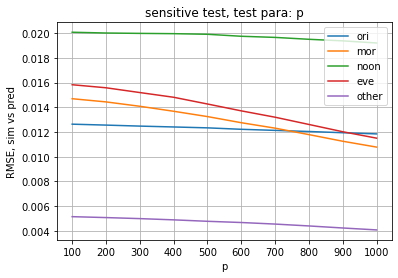

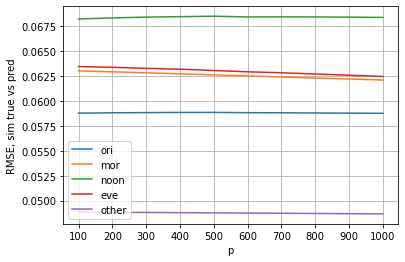

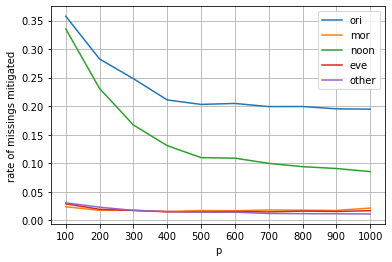

In [22]:
plot_paras_sensitive(test_k_nmf, k_nmf_100, 'p', 0, 1)

In [ ]:
test_k_nmf_less100 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf, 
                                          0.05, 288, result_para_dict, 'NMF')

plot_para_sensitive(test_k_nmf, k_nmf, 'p', 0, 1)


In [44]:
k_nmf = generate_paralst(list(np.array(range(1, 11))*100), [0], [0.01, 0.01, 0.2], 4)
test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2], 0.012712261149616386
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2], 0.059003217859950205
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.005378184331096793


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],mor, 0.014767871734869938
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],mor, 0.06311983334369992
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.14137184526861504
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],noon, 0.02016048436773171
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],noon, 0.06861608393534589
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.005720398358064333
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],eve, 0.015863066959774096
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],eve, 0.06355527247541896
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.11393437788743194
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],other, 0.005184296751246869

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2], 0.012701058141496094
RMSE with True, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2], 0.05901114079388757
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.005765243932973296


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],mor, 0.014728792132066017
RMSE with True, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],mor, 0.06311431518103984
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.23411477620159896
RMSE, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],noon, 0.02012980872851417
RMSE with True, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],noon, 0.06862481541876479
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.007487988628807875
RMSE, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],eve, 0.01582029799360952
RMSE with True, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],eve, 0.06355965611517266
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.1889388011874103
RMSE, data with missing rate>=0.05, para=[200, 0.01, 0.01, 0.2],other, 0.005181570537285497
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2], 0.012696125699589233
RMSE with True, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2], 0.05901719781985902
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.005781739623768641


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],mor, 0.014713354680416704
RMSE with True, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],mor, 0.06311195327116506
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.32392373573368277
RMSE, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],noon, 0.02011532689846555
RMSE with True, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],noon, 0.06862939377242189
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.007705960900536871
RMSE, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],eve, 0.015802132569374586
RMSE with True, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],eve, 0.06356255253306613
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.25762773507382
RMSE, data with missing rate>=0.05, para=[300, 0.01, 0.01, 0.2],other, 0.005180616573163764
RM

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2], 0.012693395022511426
RMSE with True, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2], 0.059027531778046066
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006250688547807752


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],mor, 0.014704084755127675
RMSE with True, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],mor, 0.06311156902009787
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.36119181906226855
RMSE, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],noon, 0.020106160766070906
RMSE with True, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],noon, 0.06862649947328471
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.008740871266308996
RMSE, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],eve, 0.015791398911758608
RMSE with True, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],eve, 0.06355946088820194
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.31197043269703345
RMSE, data with missing rate>=0.05, para=[400, 0.01, 0.01, 0.2],other, 0.0051801572785761


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2], 0.01269141155045604
RMSE with True, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2], 0.05902906779007354
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006384421469612876


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],mor, 0.014699116071386641
RMSE with True, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],mor, 0.06311131617799348
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.43051520157997686
RMSE, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],noon, 0.020101211746859565
RMSE with True, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],noon, 0.06862759540952004
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.008779336961319996
RMSE, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],eve, 0.01578301984180069
RMSE with True, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],eve, 0.0635584163086399
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.36183576778658066
RMSE, data with missing rate>=0.05, para=[500, 0.01, 0.01, 0.2],other, 0.005179733174891404


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2], 0.012689697937968335
RMSE with True, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2], 0.05903098088338088
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.00699829681992538


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],mor, 0.014694066638027805
RMSE with True, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],mor, 0.06310999201698693
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.464958506618052
RMSE, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],noon, 0.020095666968086078
RMSE with True, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],noon, 0.06862768520142899
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.009698850242059123
RMSE, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],eve, 0.015779154201902495
RMSE with True, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],eve, 0.06355770723229176
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.39369335718638804
RMSE, data with missing rate>=0.05, para=[600, 0.01, 0.01, 0.2],other, 0.005179404387586684


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2], 0.012688169872462665
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2], 0.05902531329861469
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.007004777269880695


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],mor, 0.01469097114213229
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],mor, 0.06310939927108696
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5013625401165992
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],noon, 0.02009441692451088
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],noon, 0.06864156516543975
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.009475382871042841
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],eve, 0.01577430384586085
RMSE with True, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],eve, 0.06355938605510274
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.4301659228969666
RMSE, data with missing rate>=0.05, para=[700, 0.01, 0.01, 0.2],other, 0.005179342052624784
RMS

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2], 0.012687408963559783
RMSE with True, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2], 0.05902783590006957
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.006955290197494658


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],mor, 0.01468787075460384
RMSE with True, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],mor, 0.06310758114160128
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5210410376194002
RMSE, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],noon, 0.020092345959567905
RMSE with True, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],noon, 0.06863420876245133
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.009517511965578698
RMSE, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],eve, 0.015772929382568423
RMSE with True, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],eve, 0.06355792016698142
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.44823756069750526
RMSE, data with missing rate>=0.05, para=[800, 0.01, 0.01, 0.2],other, 0.005179171532161925


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2], 0.012686849440619952
RMSE with True, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2], 0.05903241639047422
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.007350597644768833


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],mor, 0.014687356771921359
RMSE with True, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],mor, 0.06310933925757536
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5329525817049318
RMSE, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],noon, 0.02009110913868805
RMSE with True, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],noon, 0.0686418738441704
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010008407501909547
RMSE, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],eve, 0.01577087617399686
RMSE with True, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],eve, 0.06355747626980761
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.47902864332474887
RMSE, data with missing rate>=0.05, para=[900, 0.01, 0.01, 0.2],other, 0.0051790761048386745
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2], 0.01268643565168658
RMSE with True, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2], 0.059034415836190415
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.008057555821712217


C:\Users\Yiran\AppData\Local\Temp\ipykernel_25144\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],mor, 0.014685738904220183
RMSE with True, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],mor, 0.06310986315464293
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.5594817600030384
RMSE, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],noon, 0.020088965906766613
RMSE with True, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],noon, 0.06862731865088802
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.010272172267699256
RMSE, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],eve, 0.01576785187705356
RMSE with True, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],eve, 0.06355780240723953
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.49118288870977256
RMSE, data with missing rate>=0.05, para=[1000, 0.01, 0.01, 0.2],other, 0.005179047503

4

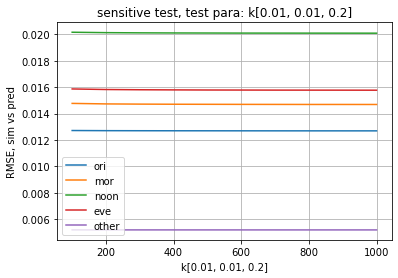

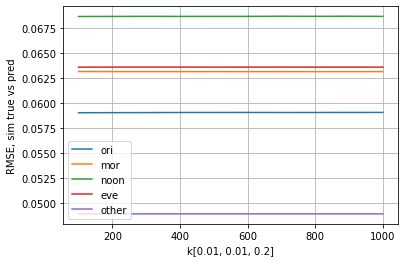

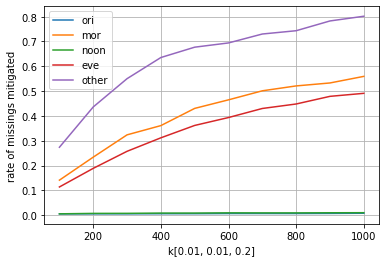

In [45]:
plot_paras_sensitive(test_k_nmf, k_nmf, 'k'+str(k_nmf[0][1:]), 0, 1)

In [24]:
test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0] 0.012747941355114744
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0] 0.05890990254038719
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0012748812457545689


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],mor 0.014897337919360236
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],mor 0.06309733429106809
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08124442165631705
RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],noon 0.020279348798804307
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],noon 0.06865090938058255
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0008554037890541286
RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],eve 0.016006798279745077
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],eve 0.06349993891236778
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06786325122377966


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[10, 0, 0, 0],other 0.005193827870676038
RMSE with True, data with missing rate>=0.05, para=[10, 0, 0, 0],other 0.048822982802958555
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.05640331557648284


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0] 0.012728718568937158
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0] 0.058837325335104544
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0035766192435194026


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],mor 0.01487681263820534
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],mor 0.06309411730648869
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08310545205947702
RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],noon 0.020232963311889035
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],noon 0.06846143358945231
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0028537882298636666
RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],eve 0.016001968528226718
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],eve 0.0635454058530585
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06976035543672715
RMSE, data with missing rate>=0.05, para=[20, 0, 0, 0],other 0.0051912075414179
RMSE with True, data with missing rate>=0.05, para=[20, 0, 0, 0],other 0.048860064497000914
% of missin

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0] 0.01271491599386535
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0] 0.05882305330455383
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0029309307752444455


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],mor 0.01485186286166284
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],mor 0.06308061776598275
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08733549820543497
RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],noon 0.020196482054600024
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],noon 0.0683454289353378
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0016045689918874017
RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],eve 0.015977678326213936
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],eve 0.06351789831834781
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07378064363929464
RMSE, data with missing rate>=0.05, para=[30, 0, 0, 0],other 0.005184532115529781
RMSE with True, data with missing rate>=0.05, para=[30, 0, 0, 0],other 0.04885659150974452
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0] 0.012702146379228882
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0] 0.058812769993008183
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.004911591934314159


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],mor 0.014835492770883429
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],mor 0.06307189088415674
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09164625230255037
RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],noon 0.020166330636138076
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],noon 0.068275073666488
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0029545317167972364
RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],eve 0.0159540322529309
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],eve 0.06349366012541163
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07787465350816836
RMSE, data with missing rate>=0.05, para=[40, 0, 0, 0],other 0.00517834618261248
RMSE with True, data with missing rate>=0.05, para=[40, 0, 0, 0],other 0.04885719515309826
% of missings

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0] 0.012690169362749968
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0] 0.05880138269599802
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.005967316145216279


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],mor 0.01481578160500504
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],mor 0.0630723478347906
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.10009684954138894
RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],noon 0.020147491195194166
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],noon 0.06824144581635616
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0036963701205807954
RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],eve 0.015943388249205864
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],eve 0.06351658457952507
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08486838225175458
RMSE, data with missing rate>=0.05, para=[50, 0, 0, 0],other 0.005173145082117199
RMSE with True, data with missing rate>=0.05, para=[50, 0, 0, 0],other 0.04885990749243864
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0] 0.012677472944743171
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0] 0.05879410321453467
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.005992648813223417


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],mor 0.01478858471424342
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],mor 0.06305872255934462
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.10640156478474715
RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],noon 0.020128653845190622
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],noon 0.06821702282458424
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.004309989540994356
RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],eve 0.015917559267014346
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],eve 0.06349580559821014
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08557611024829458
RMSE, data with missing rate>=0.05, para=[60, 0, 0, 0],other 0.005165878815844691
RMSE with True, data with missing rate>=0.05, para=[60, 0, 0, 0],other 0.04885834047537661
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0] 0.012666525148895269
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0] 0.058793649421417044
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007179749418674182


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],mor 0.014768088917015573
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],mor 0.06305747447800099
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.11521772156706356
RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],noon 0.02011800019769181
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],noon 0.0682400390807881
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.005921885331931473
RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],eve 0.01589058438103169
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],eve 0.06348317568488952
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.09697347985924076
RMSE, data with missing rate>=0.05, para=[70, 0, 0, 0],other 0.005158293173594068
RMSE with True, data with missing rate>=0.05, para=[70, 0, 0, 0],other 0.04885393210675108
% of missing

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0] 0.01265851021681209
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0] 0.05880182180952271
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00694115103395579


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],mor 0.014744347262279031
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],mor 0.06304006900040617
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.12397216050437722
RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],noon 0.02009533012245921
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],noon 0.0682177203390896
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.006004311821240757
RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],eve 0.015879910377906963
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],eve 0.06348913719425803
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.10079717695165824
RMSE, data with missing rate>=0.05, para=[80, 0, 0, 0],other 0.005153214172841241
RMSE with True, data with missing rate>=0.05, para=[80, 0, 0, 0],other 0.04885554840475796
% of missin

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0] 0.01264742042841409
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0] 0.05879957000470048
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007008312060765412


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],mor 0.014721230014808453
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],mor 0.06302504540918395
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.13785867562999676
RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],noon 0.02009034161337367
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],noon 0.0682002457803892
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.007390908541399162
RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],eve 0.015846122598569726
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],eve 0.06346730668369849
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.11110346590127194
RMSE, data with missing rate>=0.05, para=[90, 0, 0, 0],other 0.005145404997811132
RMSE with True, data with missing rate>=0.05, para=[90, 0, 0, 0],other 0.048849994215980505
% of missi

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0] 0.01263532505201235
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0] 0.05879072123055703
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007169734177834152


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],mor 0.014698131592701029
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],mor 0.06302897919237925
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1417184147059382
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],noon 0.020083983769911846
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],noon 0.0682467889933743
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00749348372809516
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],eve 0.015831136204656926
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],eve 0.06346728218521058
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.11648023276387441
RMSE, data with missing rate>=0.05, para=[100, 0, 0, 0],other 0.005141340290431893
RMSE with True, data with missing rate>=0.05, para=[100, 0, 0, 0],other 0.04885114823871575
% of

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0] 0.01262584618351635
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0] 0.05878769436767305
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007710557183195839


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],mor 0.014661246794220614
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],mor 0.06299536025934954
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15583755863195276
RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],noon 0.02007340754464375
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],noon 0.06824392185698522
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00719308496705688
RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],eve 0.015803884050179566
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],eve 0.06346319951632777
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.12551359427526687
RMSE, data with missing rate>=0.05, para=[110, 0, 0, 0],other 0.005131083736736035
RMSE with True, data with missing rate>=0.05, para=[110, 0, 0, 0],other 0.04884652736556249
% o

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0] 0.012616395386233816
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0] 0.05880454216520071
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0077659355737230715


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],mor 0.01465037480386391
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],mor 0.0630092601455547
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.16743576596593174
RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],noon 0.020066618649483833
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],noon 0.06824413394730376
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008735376167021712
RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],eve 0.01578415545721309
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],eve 0.06345407294276882
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.12810368215149312
RMSE, data with missing rate>=0.05, para=[120, 0, 0, 0],other 0.005126391737913087
RMSE with True, data with missing rate>=0.05, para=[120, 0, 0, 0],other 0.04884653777007829
% of

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0] 0.012608011712918627
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0] 0.058805865278089266
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007965651258709577


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],mor 0.014628795940029988
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],mor 0.06299806195343544
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.17036024231375455
RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],noon 0.020065896101163133
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],noon 0.06827771474251872
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008870921949441423
RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],eve 0.015760581142626594
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],eve 0.06344837632292538
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.14213537263844928
RMSE, data with missing rate>=0.05, para=[130, 0, 0, 0],other 0.005120350016116125
RMSE with True, data with missing rate>=0.05, para=[130, 0, 0, 0],other 0.048846535989498924


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0] 0.012601913256504308
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0] 0.05880534057094603
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008051075371756903


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],mor 0.01458296619715145
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],mor 0.06297738814106128
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.19367534514517937
RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],noon 0.020033687185747252
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],noon 0.0682247114970292
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009253747199788989
RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],eve 0.01573126571404942
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],eve 0.0634342844984454
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.15148819470383548
RMSE, data with missing rate>=0.05, para=[140, 0, 0, 0],other 0.005110072692998595
RMSE with True, data with missing rate>=0.05, para=[140, 0, 0, 0],other 0.048843151485382985
% of

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0] 0.01259605135894552
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0] 0.058825449234717046
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007347651985698236


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],mor 0.014574194515717986
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],mor 0.06297187895950937
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.19841812415731405
RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],noon 0.02006688462879074
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],noon 0.06828069053156263
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008790327159894567
RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],eve 0.015733299471849503
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],eve 0.06344181791515086
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.15729746200876796
RMSE, data with missing rate>=0.05, para=[150, 0, 0, 0],other 0.005101105258193535
RMSE with True, data with missing rate>=0.05, para=[150, 0, 0, 0],other 0.048840652968526625
%

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0] 0.01258370547499114
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0] 0.05881812051617653
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007522624134491724


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],mor 0.014546041776095468
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],mor 0.06297078115424178
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.20649841432613608
RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],noon 0.020051901087956996
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],noon 0.06829784406551682
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009220776604065275
RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],eve 0.015666795854590743
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],eve 0.06340928955045413
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.17261682426720665
RMSE, data with missing rate>=0.05, para=[160, 0, 0, 0],other 0.005096259007754664
RMSE with True, data with missing rate>=0.05, para=[160, 0, 0, 0],other 0.0488432753300689
% 

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0] 0.01258349710107602
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0] 0.05882398660625106
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008359191310541395


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],mor 0.014514688337722605
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],mor 0.06295777720097237
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.22142938529026376
RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],noon 0.02005894199706284
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],noon 0.06832082322655231
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009810583927567264
RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],eve 0.01565187060367931
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],eve 0.06341046821199932
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.18063282678357284
RMSE, data with missing rate>=0.05, para=[170, 0, 0, 0],other 0.0050888571980560945
RMSE with True, data with missing rate>=0.05, para=[170, 0, 0, 0],other 0.048835476242801615
%

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0] 0.012569430302118796
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0] 0.05884057637044217
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00853710911840548


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],mor 0.01448440094786518
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],mor 0.06295348156405224
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.239593421827228
RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],noon 0.0200749737015595
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],noon 0.06831551386924907
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.009742811036357409
RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],eve 0.015590178015922948
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],eve 0.06338363046657791
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.18741030530599406
RMSE, data with missing rate>=0.05, para=[180, 0, 0, 0],other 0.005081840864737031
RMSE with True, data with missing rate>=0.05, para=[180, 0, 0, 0],other 0.048838425581189955
% of 

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0] 0.012566623729345486
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0] 0.05883629718776525
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008596611431631547


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],mor 0.014458085329361313
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],mor 0.06294116639003887
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.24200041778233541
RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],noon 0.02005801548204884
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],noon 0.06835134258239875
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.010891286787400103
RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],eve 0.015595318948947653
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],eve 0.06340710031100319
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.203098275895964
RMSE, data with missing rate>=0.05, para=[190, 0, 0, 0],other 0.005074277552717471
RMSE with True, data with missing rate>=0.05, para=[190, 0, 0, 0],other 0.048834936702560505
% o

C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0] 0.012560519017558194
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0] 0.05882477787009622
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008487032914205323


C:\Users\flwang\AppData\Local\Temp\ipykernel_11124\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],mor 0.014440279372249185
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],mor 0.06294356161068372
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.2605679940750869
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],noon 0.02002161988882496
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],noon 0.0683539920306817
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.010689799813532965
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],eve 0.01558460766103296
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],eve 0.06339620521283915
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.2057178524387127
RMSE, data with missing rate>=0.05, para=[200, 0, 0, 0],other 0.005067082155127967
RMSE with True, data with missing rate>=0.05, para=[200, 0, 0, 0],other 0.04882849390101225
% of m

4

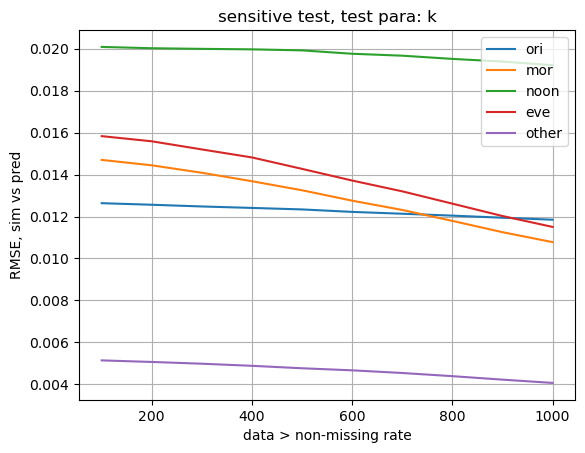

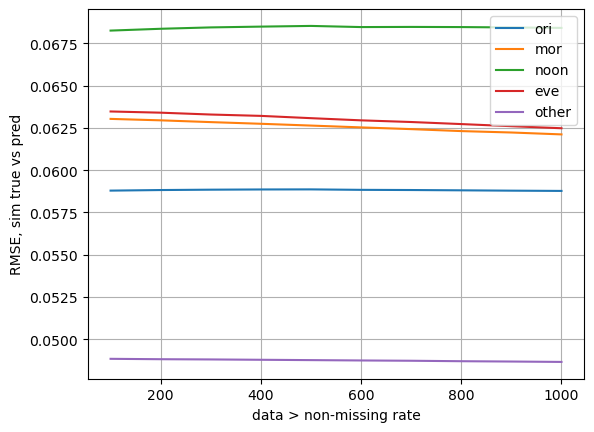

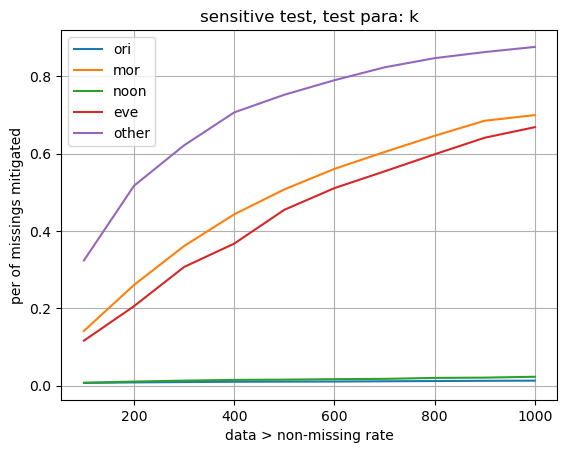

In [107]:
plot_paras_sensitive(test_k_nmf_100, k_nmf_100, 'k', 0, 1)

4

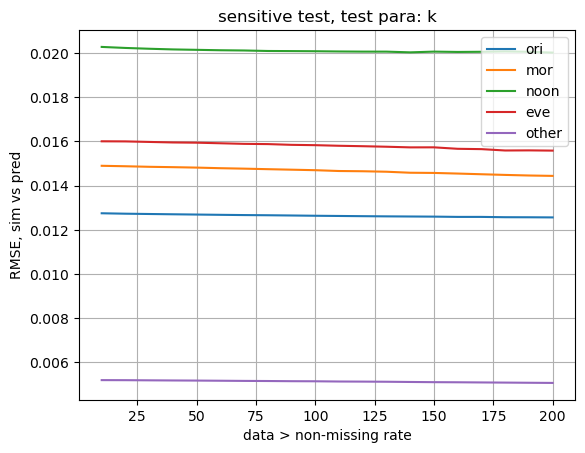

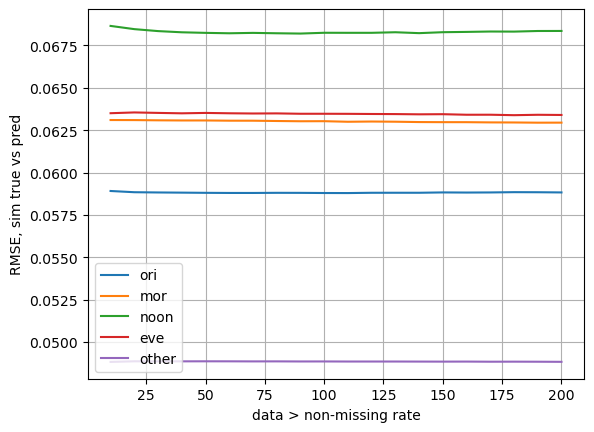

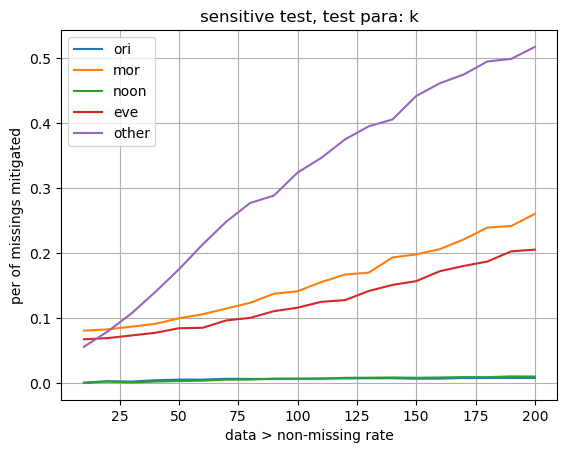

In [59]:
plot_paras_sensitive(test_k_nmf, k_nmf, 'k', 0, 1)

###### aW and aH

In [ ]:
aWaH_nmf = [[100, 0.01, 0.01, 0.5],
            [100, 0.1, 0.1, 0.5],
            [100, 1., 1., 0.5],
            [100, 10., 10., 0.5],
            [100, 100., 100., 0.5]]
test_aWaH_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf, 
                                          0.05, 288, result_para_dict, 'NMF')

In [ ]:
aWaH_nmf_2 =  [[100, 0.01, 0.1, 0.5],
                [100, 0.01, 1.0, 0.5],
                [100, 0.01, 10.0, 0.5],
                [100, 0.01, 100.0, 0.5],
                [100, 0.1, 0.01, 0.5],
                [100, 1., 0.01, 0.5],
                [100, 10., 0.01, 0.5],
                [100, 100., 0.01, 0.5]]

test_aWaH_nmf2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_2, 
                                          0.05, 288, result_para_dict, 'NMF')

In [25]:
aWaH_nmf_2 =  [[100, 0.01, 0.01, 0.2],
                [100, 0.01, 0.1, 0.2],
                [100, 0.01, 1.0, 0.2],
                [100, 0.01, 10.0, 0.2],
                [100, 0.01, 100.0, 0.2]
               ]

aWaH_nmf_3 =  [[100, 0.01, 0.01, 0.2],
                [100, 0.1, 0.01, 0.2],
                [100, 1., 0.01, 0.2],
                [100, 10., 0.01, 0.2],
                [100, 100., 0.01, 0.2]]

test_aWaH_nmf2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_2, 
                                          0.05, 288, result_para_dict, 'NMF')

test_aWaH_nmf3 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_3, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2], 0.012712261149616386
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2], 0.059003217859950205
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.4649699277665483


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],mor, 0.014767871734869938
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],mor, 0.06311983334369992
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.03337985909341233
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],noon, 0.02016048436773171
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],noon, 0.06861608393534589
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.42491587918841045
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],eve, 0.015863066959774096
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],eve, 0.06355527247541896
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.056682131833998464
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],other, 0.005184296751246869

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2], 0.012766870096438176
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2], 0.059111568836644646
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.5091542246936956


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],mor, 0.014891993284027995
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],mor, 0.06317642369271215
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.03128145236331871
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],noon, 0.020290379721505165
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],noon, 0.0688691583831264
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.4418481117922999
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],eve, 0.016004670657223264
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],eve, 0.06363322409253638
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.03804037981402481
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.1, 0.2],other, 0.0052053224355201365
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2], 0.012788385666695549
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2], 0.059177508077005836
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.5008798683643875


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],mor, 0.014930232181021049
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],mor, 0.06319346620926491
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.032691467745304695
RMSE, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],noon, 0.020345386963237764
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],noon, 0.06900056202117845
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.35798190646974676
RMSE, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],eve, 0.016049238996293985
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],eve, 0.06365448075481148
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.039328051585507305
RMSE, data with missing rate>=0.05, para=[100, 0.01, 1.0, 0.2],other, 0.005210186976620932
RMSE

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2], 0.01279334791921675
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2], 0.05919415462842934
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.41083460536710864


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],mor, 0.01493598588866162
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],mor, 0.06319610226516409
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.03826031637516854
RMSE, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],noon, 0.020357109089380796
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],noon, 0.0690315166758722
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.28191141533608943
RMSE, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],eve, 0.016056186446046686
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],eve, 0.06365786672369819
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.04506359722413353
RMSE, data with missing rate>=0.05, para=[100, 0.01, 10.0, 0.2],other, 0.005210837928140301
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2], 0.012793723645518392
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2], 0.059195194741924285
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.41096126870714433


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],mor, 0.014936575888887148
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],mor, 0.06319636647896007
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.03819385100362711
RMSE, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],noon, 0.020357935789682383
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],noon, 0.06903316207991375
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2816677992676864
RMSE, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],eve, 0.016056907725367123
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],eve, 0.06365822144086072
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.045039023335364775
RMSE, data with missing rate>=0.05, para=[100, 0.01, 100.0, 0.2],other, 0.00521090277

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2], 0.012712261149616386
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2], 0.059003217859950205
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.4649699277665483


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],mor, 0.014767871734869938
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],mor, 0.06311983334369992
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.03337985909341233
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],noon, 0.02016048436773171
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],noon, 0.06861608393534589
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.42491587918841045
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],eve, 0.015863066959774096
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],eve, 0.06355527247541896
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.056682131833998464
RMSE, data with missing rate>=0.05, para=[100, 0.01, 0.01, 0.2],other, 0.005184296751246869

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2], 0.012771800271758624
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2], 0.05913948478507086
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.482412942518998


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],mor, 0.014893667411795408
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],mor, 0.06315210771633362
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.19756356938035283
RMSE, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],noon, 0.020299296732909478
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],noon, 0.06891733888831698
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.40005055491344305
RMSE, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],eve, 0.015999224645481473
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],eve, 0.06356715475903725
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.41286099042601293


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],other, 0.005206037411535716
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 0.01, 0.2],other, 0.04890108226993973
% of missings (sim missing vs sim true),other, 0.9697565902646628
% of missings mitigated,other, 0.2129072593331959


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2], 0.012790613550714225
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2], 0.059186962413418386
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.4855217911021066


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],mor, 0.014930726796289796
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],mor, 0.06318884512573666
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.27753565392430546
RMSE, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],noon, 0.020349329366872
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],noon, 0.06901578268001116
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.3327996981358792
RMSE, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],eve, 0.016048962193604865
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],eve, 0.06364518272530272
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.43174356655592033
RMSE, data with missing rate>=0.05, para=[100, 1.0, 0.01, 0.2],other, 0.005210337659802168
RMSE with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2], 0.012793522253057035
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2], 0.05919485276144585
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3558479874962664


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],mor, 0.014936186284694267
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],mor, 0.06319613601540938
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.09753318521050533
RMSE, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],noon, 0.02035733524371707
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],noon, 0.06903230444853067
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.28362588631372254
RMSE, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],eve, 0.016056403235018724
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],eve, 0.06365780727648407
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.17212534649183164
RMSE, data with missing rate>=0.05, para=[100, 10.0, 0.01, 0.2],other, 0.005210866603790283


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2], 0.012793741597108471
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2], 0.05919526623905831
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3560211922496175


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],mor, 0.014936596328610162
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],mor, 0.06319636999074892
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.09769460111282022
RMSE, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],noon, 0.020357959316463517
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],noon, 0.06903324331892075
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2831807832714524
RMSE, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],eve, 0.016056929943869598
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],eve, 0.06365821559323163
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.17250869915662415
RMSE, data with missing rate>=0.05, para=[100, 100.0, 0.01, 0.2],other, 0.005210905678

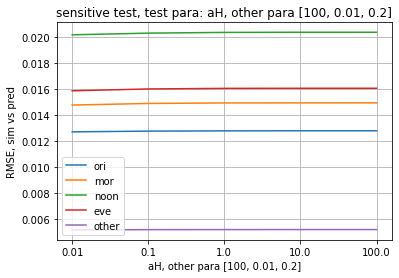

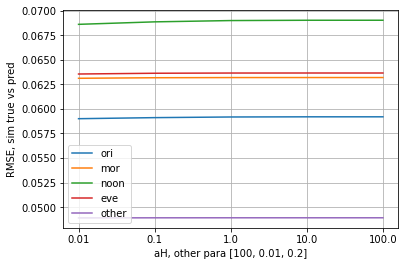

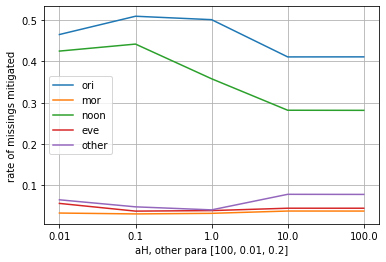

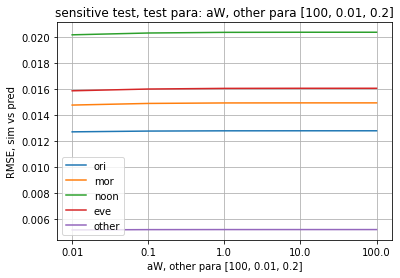

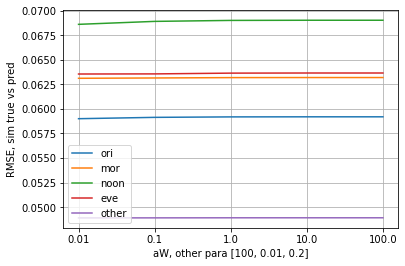

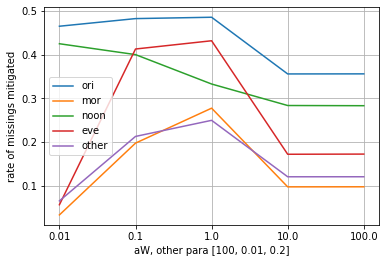

In [26]:
idx = plot_paras_sensitive(test_aWaH_nmf2, aWaH_nmf_2, 'aH, other para '+str([100, 0.01, 0.2]), 2, 1)
idx = plot_paras_sensitive(test_aWaH_nmf3, aWaH_nmf_3, 'aW, other para '+str([100, 0.01, 0.2]), 1, idx)

In [27]:
aWaH_nmf_2 =  [[100, 10, 0.01, 0.2],
                [100, 10, 0.1, 0.2],
                [100, 10, 1.0, 0.2],
                [100, 10, 10.0, 0.2],
                [100, 10, 100.0, 0.2]
               ]

aWaH_nmf_3 =  [[100, 0.01, 10, 0.2],
                [100, 0.1, 10, 0.2],
                [100, 1., 10, 0.2],
                [100, 10., 10, 0.2],
                [100, 100., 10, 0.2]]

test_aWaH_nmf2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_2, 
                                          0.05, 288, result_para_dict, 'NMF')

test_aWaH_nmf3 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf_3, 
                                          0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2], 0.012793522253057035
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2], 0.05919485276144585
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3558479874962664


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],mor, 0.014936186284694267
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],mor, 0.06319613601540938
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.09753318521050533
RMSE, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],noon, 0.02035733524371707
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],noon, 0.06903230444853067
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.28362588631372254
RMSE, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],eve, 0.016056403235018724
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],eve, 0.06365780727648407
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.17212534649183164
RMSE, data with missing rate>=0.05, para=[100, 10, 0.01, 0.2],other, 0.005210866603790283
RMSE with True

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2], 0.012793724102106602
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2], 0.05919521177771878
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3841840494917854


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],mor, 0.014936570971709128
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],mor, 0.06319636263681168
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.05158187584268596
RMSE, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],noon, 0.02035791682460526
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],noon, 0.06903314990449706
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.28305989108713214
RMSE, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],eve, 0.01605690177548835
RMSE with True, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],eve, 0.06365821548859932
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.0696178268818684
RMSE, data with missing rate>=0.05, para=[100, 10, 0.1, 0.2],other, 0.005210903289815761
RMSE with True, data wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2], 0.012793760676859426
RMSE with True, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2], 0.05919529843359028
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.38985621059812786


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],mor, 0.014936633225236643
RMSE with True, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],mor, 0.06319639213067556
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.04376744716002962
RMSE, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],noon, 0.020358015376498
RMSE with True, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],noon, 0.06903332274423324
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.27689988478608496
RMSE, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],eve, 0.01605697781098856
RMSE with True, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],eve, 0.06365825590790061
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.05263726974266224
RMSE, data with missing rate>=0.05, para=[100, 10, 1.0, 0.2],other, 0.0052109092123107555
RMSE with True, data wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2], 0.012793765501136638
RMSE with True, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2], 0.05919531092210441
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.39049424035281927


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],mor, 0.014936641112046995
RMSE with True, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],mor, 0.06319639568607212
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.043045823126151274
RMSE, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],noon, 0.020358027692778093
RMSE with True, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],noon, 0.06903334580924239
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2762752751670968
RMSE, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],eve, 0.01605698757867289
RMSE with True, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],eve, 0.0636582607280008
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.051216898971828496
RMSE, data with missing rate>=0.05, para=[100, 10, 10.0, 0.2],other, 0.005210909940349844
RMSE with True

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2], 0.012793766010813841
RMSE with True, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2], 0.059195312258769534
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3905543317978594


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],mor, 0.014936641940678183
RMSE with True, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],mor, 0.06319639605778624
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.042879659697297706
RMSE, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],noon, 0.020358028979863572
RMSE with True, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],noon, 0.06903334824647456
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.27624596797089795
RMSE, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],eve, 0.016056988613263434
RMSE with True, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],eve, 0.06365826123567404
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.051167751194291
RMSE, data with missing rate>=0.05, para=[100, 10, 100.0, 0.2],other, 0.005210910015928745
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2], 0.01279334791921675
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2], 0.05919415462842934
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.41083460536710864


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],mor, 0.01493598588866162
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],mor, 0.06319610226516409
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.03826031637516854
RMSE, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],noon, 0.020357109089380796
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],noon, 0.0690315166758722
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.28191141533608943
RMSE, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],eve, 0.016056186446046686
RMSE with True, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],eve, 0.06365786672369819
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.04506359722413353
RMSE, data with missing rate>=0.05, para=[100, 0.01, 10, 0.2],other, 0.005210837928140301
RMSE with True,

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2], 0.012793712042350499
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2], 0.05919516916419334
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3940137138103691


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],mor, 0.014936555711490707
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],mor, 0.06319635738827993
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.04149812947454376
RMSE, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],noon, 0.020357897661879478
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],noon, 0.06903309583642797
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2778706856601721
RMSE, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],eve, 0.0160568817277102
RMSE with True, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],eve, 0.06365820869814101
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.050479682308766
RMSE, data with missing rate>=0.05, para=[100, 0.1, 10, 0.2],other, 0.0052109018009911775
RMSE with True, data wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2], 0.01279376042775405
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2], 0.05919529759834207
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.39083652593682267


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],mor, 0.014936632885036607
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],mor, 0.06319639199580576
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.04293663001576179
RMSE, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],noon, 0.020358014942761345
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],noon, 0.06903332161562549
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2765445350321738
RMSE, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],eve, 0.01605697731844976
RMSE with True, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],eve, 0.06365825569182137
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.05119232508305974
RMSE, data with missing rate>=0.05, para=[100, 1.0, 10, 0.2],other, 0.005210909185971055
RMSE with True, data w

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2], 0.012793765501136638
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2], 0.05919531092210441
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.39049424035281927


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],mor, 0.014936641112046995
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],mor, 0.06319639568607212
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.043045823126151274
RMSE, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],noon, 0.020358027692778093
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],noon, 0.06903334580924239
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2762752751670968
RMSE, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],eve, 0.01605698757867289
RMSE with True, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],eve, 0.0636582607280008
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.051216898971828496
RMSE, data with missing rate>=0.05, para=[100, 10.0, 10, 0.2],other, 0.005210909940349844
RMSE with True

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2], 0.012793766011111573
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2], 0.05919531225975667
% of missings (sim missing vs sim true), 0.9379050189193012
% of missings mitigated, 0.3904588924439721


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18268\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],mor, 0.014936641941095709
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],mor, 0.06319639605795505
% of missings (sim missing vs sim true),mor, 0.9310948440483768
% of missings mitigated,mor, 0.043031580546535254
RMSE, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],noon, 0.02035802898039357
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],noon, 0.06903334824783461
% of missings (sim missing vs sim true),noon, 0.904978583174199
% of missings mitigated,noon, 0.2762697800678095
RMSE, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],eve, 0.01605698861388675
RMSE with True, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],eve, 0.06365826123595417
% of missings (sim missing vs sim true),eve, 0.9251068473219969
% of missings mitigated,eve, 0.051211984194074744
RMSE, data with missing rate>=0.05, para=[100, 100.0, 10, 0.2],other, 0.005210910015958911
RMSE wi

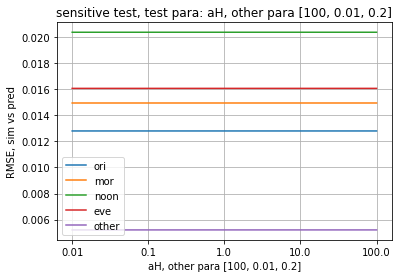

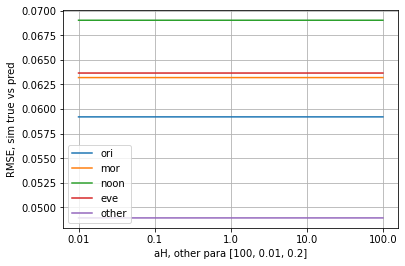

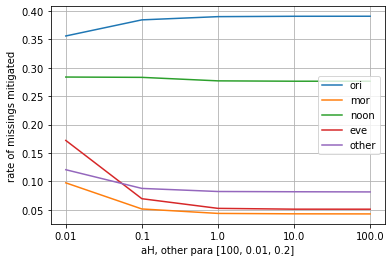

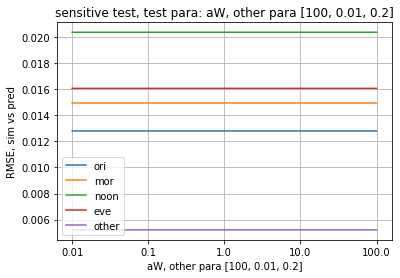

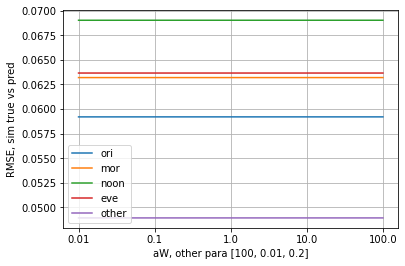

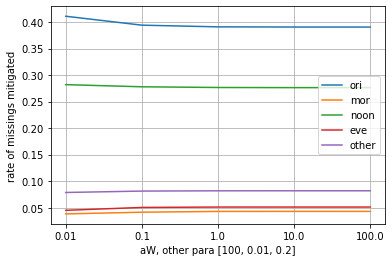

In [28]:
idx = plot_paras_sensitive(test_aWaH_nmf2, aWaH_nmf_2, 'aH, other para '+str([100, 0.01, 0.2]), 2, 1)
idx = plot_paras_sensitive(test_aWaH_nmf3, aWaH_nmf_3, 'aW, other para '+str([100, 0.01, 0.2]), 1, idx)

###### l1 RATIO

In [12]:
l1_ratio_nmf_1 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 0.01, 0.01], 4)
l1_ratio_nmf_2 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 10, 10], 4)
l1_ratio_nmf_3 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 0.1, 0.01], 4)
l1_ratio_nmf_4 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 0.01, 0.1], 4)
l1_ratio_nmf_5 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 0.01, 10], 4)
l1_ratio_nmf_6 = generate_paralst(list(np.array(range(0, 11))*0.1), [3], [100, 10, 0.01], 4)

In [13]:
test_l1_nmf_1 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_1,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_2 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_2,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_3 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_3,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_4 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_4,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_5 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_5,
                                            0, 288, result_para_dict, 'NMF')
test_l1_nmf_6 = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf_6,
                                            0, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0], 0.011816962409451832
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0], 0.057658990227866566
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5199328788896533


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],mor, 0.013758956497643087
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],mor, 0.06171731890618881
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027379354289499332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],noon, 0.018478480556271784
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],noon, 0.0665910521122705
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.5265887251885649
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],eve, 0.014577146555679921
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],eve, 0.06160383526864098
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.0342523061203744
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],other, 0.005021319616582531
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.0],other, 0.048316976174038684
% of missings (sim missing vs sim true),other, 0.9744019751706147
% of missings mitigated,other, 0.04622237095823174


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1], 0.011839756240158886
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1], 0.05772029966481879
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5378046100846933


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],mor, 0.013809623015530919
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],mor, 0.061742625040494534
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023999435840735824


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],noon, 0.0185228635499927
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],noon, 0.06673140193345967
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.5136881334680088
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],eve, 0.014631148842426561
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],eve, 0.06163294144618458
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02873690548490433
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],other, 0.005041629113272781
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.1],other, 0.04832642324545587
% of missings (sim missing vs sim true),other, 0.9744019751706147
% of missings mitigated,other, 0.033149055212448625


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2], 0.011857074166022885
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2], 0.05776420035666512
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5442947995224773


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],mor, 0.013849287743242391
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],mor, 0.06176035572037835
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023251421102075048


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],noon, 0.018558038333364904
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],noon, 0.0668300460711771
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.5071081931431624
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],eve, 0.014675003797885382
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],eve, 0.061653897950587525
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.027214696613867218
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],other, 0.005052959050025065
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.2],other, 0.04833090912479283
% of missings (sim missing vs sim true),other, 0.9744019751706147
% of missings mitigated,other, 0.027017316638199174


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004], 0.011869150448366261
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004], 0.05779617612530757
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5465484462045147


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004],mor, 0.013878829311160159
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004],mor, 0.061772829551000705
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02319601260291499
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004],noon, 0.018586408818370106
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004],noon, 0.06690695065162716
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.49593845177419416
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004],eve, 0.014707045596787047
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.30000000000000004],eve, 0.06166815087940412
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02643013347999364
RMSE, data 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4], 0.011877241657538597
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4], 0.05781722268186341
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.55181227623949


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],mor, 0.013899987295851613
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],mor, 0.06178122855982363
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023976768727443074
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],noon, 0.018606666324186
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],noon, 0.06695800758236872
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.49387091281313006
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],eve, 0.014730432407717415
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],eve, 0.06167798720882786
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.026401461737559723
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.4],other, 0.005062936319909672
RMSE with True, data

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5], 0.011883116567302336
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5], 0.05783484004174473
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5547545371854833


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],mor, 0.01391539324457255
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],mor, 0.06178758666311353
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.0240624000443268
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],noon, 0.018622114230321053
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],noon, 0.0669980644421589
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.49140863548233543
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],eve, 0.014747315390818591
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],eve, 0.06168481579138651
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.026891487880975777
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.5],other, 0.005065238218272917
RMSE with True, data 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001], 0.011887550022190652
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001], 0.057849301665077416
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5549773978018181


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001],mor, 0.013926714853250062
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001],mor, 0.06179217196727673
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023782838980382873
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001],noon, 0.018634938504275184
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001],noon, 0.06703343960026086
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48725130515210974
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001],eve, 0.014759914186289852
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.6000000000000001],eve, 0.06169014775611709
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.026325872598415755
RMSE, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001], 0.011890970697941294
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001], 0.05786090335446228
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5556744632408316


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001],mor, 0.013935245981687302
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001],mor, 0.061795603312355285
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023609057778471783
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001],noon, 0.01864397117730715
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001],noon, 0.06705572352353946
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4906268987109083
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001],eve, 0.0147694282671625
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.7000000000000001],eve, 0.061694079969386105
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.026208579106640637
RMSE, data with mi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8], 0.011893781992447361
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8], 0.05787092582976423
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5550252877938113


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],mor, 0.01394178465256132
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],mor, 0.06179817766836661
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023651873436913644
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],noon, 0.01865166992120205
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],noon, 0.06707692193725309
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48963908529057776
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],eve, 0.014776812813902685
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],eve, 0.061697043876820366
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02651875522933484
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.8],other, 0.005068650391747692
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9], 0.011896115144999417
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9], 0.057879474531140694
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5542224261633355


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],mor, 0.013946897735455967
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],mor, 0.06180017997904217
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023802987525531984
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],noon, 0.018658227974417334
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],noon, 0.0670955811435368
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4859674379544813
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],eve, 0.01478269789659218
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],eve, 0.06169933708127314
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02713389443064436
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 0.9],other, 0.005069244470425131
RMSE with True, data 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0], 0.011898099205677496
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0], 0.05788686690225327
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5515653141239167


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],mor, 0.013950973132919398
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],mor, 0.061801720173880914
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02421351413294514
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],noon, 0.018663458273592955
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],noon, 0.0671101748559401
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.486647587645463
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],eve, 0.014787373822128837
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],eve, 0.06170117429925005
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.027676051014849355
RMSE, data with missing rate>=0, para=[100, 0.01, 0.01, 1.0],other, 0.005069699689711864
RMSE with True, data

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.0], 0.011913258877552508
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.0], 0.05794379307401308
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.11154643357282502


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.0],mor, 0.013973854422473734
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.0],mor, 0.06180786226070383
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.12659330917186962
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.0],noon, 0.018704934840172254
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.0],noon, 0.06723019710936293
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.07643315183108294
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.0],eve, 0.014815513295761975
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.0],eve, 0.06170953390900273
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.14575410592384264
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.0],other, 0.005071900991352701
RMSE with True, data with missing rate>=0, para

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.1], 0.011913922206067927
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.1], 0.05794641518593906
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4313783365708637


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.1],mor, 0.013974950035990601
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.1],mor, 0.061811117198956766
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.028147517573309223
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.1],noon, 0.01870634158763452
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.1],noon, 0.06723480577027927
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3149625192047957
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.1],eve, 0.014816727647295512
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.1],eve, 0.06171310271981261
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03284739074111241
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.1],other, 0.005072041246208138
RMSE with True, data with missing rate>=0, para

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.2], 0.011913923324406436
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.2], 0.05794641867157096
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.430527271941911


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.2],mor, 0.013974951901492387
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.2],mor, 0.06181111793039075
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02788306791822713
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.2],noon, 0.018706344321180273
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.2],noon, 0.06723481167200078
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3126182763865185
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.2],eve, 0.014816729920882952
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.2],eve, 0.061713103658359414
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032503329831905396
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.2],other, 0.005072041417899884
RMSE with True, data with missing rate>=0, par

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004], 0.011913923536888422
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004], 0.05794641933514549
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43030190727370726


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004],mor, 0.013974952255745594
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004],mor, 0.06181111806910456
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027890623622658046
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004],noon, 0.018706344832093266
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004],noon, 0.06723481276753072
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31168174025441275
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004],eve, 0.014816730355162483
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.30000000000000004],eve, 0.061713103836918026
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032409495038485295
RMSE, data with missing rate>=0, 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.4], 0.011913923611640679
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.4], 0.05794641956865116
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43015197716805503


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.4],mor, 0.013974952380402856
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.4],mor, 0.06181111811790873
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027966180666967214
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.4],noon, 0.018706345010896488
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.4],noon, 0.06723481314989191
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31123185461244046
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.4],eve, 0.014816730508376825
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.4],eve, 0.06171310389980577
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03230523415690741
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.4],other, 0.005072041461632915
RMSE with True, data with missing rate>=0, par

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.5], 0.011913923646300756
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.5], 0.05794641967692448
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43008311574165947


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.5],mor, 0.013974952438217185
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.5],mor, 0.061811118140542284
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027953587826249023
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.5],noon, 0.01870634509358867
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.5],noon, 0.06723481332646788
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31084872619476084
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.5],eve, 0.014816730579514888
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.5],eve, 0.061713103928983035
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032396462428288066
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.5],other, 0.005072041466901937
RMSE with True, data with missing rate>=0, p

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001], 0.011913923665142588
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001], 0.057946419735783426
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43004085986637125


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001],mor, 0.013974952469652037
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001],mor, 0.061811118152848336
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027973736371398134
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001],noon, 0.018706345138472327
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001],noon, 0.06723481342222394
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31065135700989555
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001],eve, 0.014816730618216152
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.6000000000000001],eve, 0.06171310394484991
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032333905899341334
RMSE, data with missing rate>=0, para=[

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001], 0.01191392367650778
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001], 0.05794641977128582
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43000392510130453


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001],mor, 0.013974952488614877
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001],mor, 0.06181111816027196
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027968699235110854
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001],noon, 0.018706345165519177
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001],noon, 0.06723481347988884
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31060975468171315
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001],eve, 0.014816730641571334
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.7000000000000001],eve, 0.06171310395442271
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03234172546545967
RMSE, data with missing rate>=0, para=[10

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.8], 0.011913923683885637
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.8], 0.05794641979433214
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4299704334075576


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.8],mor, 0.013974952500925899
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.8],mor, 0.06181111816509155
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027976254939541773
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.8],noon, 0.018706345183064844
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.8],noon, 0.06723481351727881
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31054880243344596
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.8],eve, 0.014816730656737423
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.8],eve, 0.061713103960637894
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032339118943420224
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.8],other, 0.005072041472614597
RMSE with True, data with missing rate>=0, p

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.9], 0.011913923688944393
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.9], 0.05794641981013393
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4299544700768932


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 0.9],mor, 0.013974952509367913
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.9],mor, 0.061811118168396496
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.028019070597983635
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.9],noon, 0.018706345195089104
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.9],noon, 0.06723481354289318
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3104520528330218
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.9],eve, 0.014816730667138615
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 0.9],eve, 0.061713103964899846
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03235215155361746
RMSE, data with missing rate>=0, para=[100, 10, 10, 0.9],other, 0.005072041473383463
RMSE with True, data with missing rate>=0, pa

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 1.0], 0.011913923692563095
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 1.0], 0.057946419821437264
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4299403847851304


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 10, 1.0],mor, 0.013974952515407245
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 1.0],mor, 0.06181111817076081
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.028016552029839995
RMSE, data with missing rate>=0, para=[100, 10, 10, 1.0],noon, 0.018706345203687004
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 1.0],noon, 0.06723481356120332
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3103794906327037
RMSE, data with missing rate>=0, para=[100, 10, 10, 1.0],eve, 0.014816730674580164
RMSE with True, data with missing rate>=0, para=[100, 10, 10, 1.0],eve, 0.06171310396794876
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03234693850953857
RMSE, data with missing rate>=0, para=[100, 10, 10, 1.0],other, 0.005072041473933465
RMSE with True, data with missing rate>=0, para

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0], 0.011850103040779516
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0], 0.057753075763341155
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5756605532326997


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],mor, 0.01385142179047117
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],mor, 0.06170132304176787
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.18515253707961948
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],noon, 0.018553905132972157
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],noon, 0.06681638188834066
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.585639843807445
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],eve, 0.014673649939049089
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],eve, 0.06154856850087689
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.31623628643591994
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.0],other, 0.005045645307369433
RMSE with True, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1], 0.011887331163317636
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1], 0.057868763541645066
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5348016258808785


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],mor, 0.013922968660792387
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],mor, 0.0617696971295614
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.1291773600872432
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],noon, 0.01863520055454956
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],noon, 0.06706323493788738
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4953308642835305


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],eve, 0.014750473807567367
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],eve, 0.06161692511173087
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.33307963185482714


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],other, 0.0050649797750291995
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.1],other, 0.04832752254650859
% of missings (sim missing vs sim true),other, 0.9744019751706147
% of missings mitigated,other, 0.21091804404420936


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2], 0.011898434103979814
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2], 0.05789598291758146
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5483131767591434


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],mor, 0.013949226696445022
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],mor, 0.06179895611958358
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.04291891973575183
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],noon, 0.018663434362479293
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],noon, 0.06712674680358233
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4886735242783447


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],eve, 0.014782036815099346
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],eve, 0.06167213351293512
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.2115010178468564
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],other, 0.005069303184438642
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.2],other, 0.04833673632767891
% of missings (sim missing vs sim true),other, 0.9744019751706147
% of missings mitigated,other, 0.03626961395761893


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004], 0.011903350220192612
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004], 0.05791007304490266
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5486380774891371


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004],mor, 0.013959445496573835
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004],mor, 0.06180485221981957
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.026983939090948015
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004],noon, 0.01867688278542907
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004],noon, 0.0671574502261353
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4890227903358759
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004],eve, 0.014798248911739779
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.30000000000000004],eve, 0.06170412990129403
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.0457783465788095
RMSE, data with missi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4], 0.011906078030411382
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4], 0.05791873555044302
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5473810434509341


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],mor, 0.013964393084950495
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],mor, 0.06180692764021091
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.025057234461064195
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],noon, 0.01868459921748075
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],noon, 0.06717620239563832
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48835038061292807
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],eve, 0.014804229410383007
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],eve, 0.061707844622379646
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03121049490033963
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.4],other, 0.005070992506890015
RMSE with True, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5], 0.011907843102146664
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5], 0.05792472418890654
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5421507051097056


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],mor, 0.013967249138551565
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],mor, 0.06180808453422548
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024485519492458148
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],noon, 0.01868950176343524
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],noon, 0.06718867227082828
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4862934841079106
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],eve, 0.014807552274915689
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],eve, 0.06170932771227425
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02870041417635207
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.5],other, 0.005071288646693267
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001], 0.011909016651406926
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001], 0.05792873705055997
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5397289739459663


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001],mor, 0.013969064434847833
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001],mor, 0.06180880787439654
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024294108313541587
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001],noon, 0.01869290299267691
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001],noon, 0.06719760541754626
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48448910406000023
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001],eve, 0.014809650402078534
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.6000000000000001],eve, 0.0617102032644565
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028312042392474448
RMSE, data with missing 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001], 0.011909882651476987
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001], 0.05793178093274948
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5386531706617771


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001],mor, 0.013970290648765921
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001],mor, 0.06180929074076698
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02430670115425978
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001],noon, 0.018695346364471267
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001],noon, 0.06720412793061553
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48367060244041193
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001],eve, 0.014811083903199209
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.7000000000000001],eve, 0.061710793241624505
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02848146632503851
RMSE, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8], 0.011910539170473975
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8], 0.05793412287614408
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5355440772600164


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],mor, 0.013971173001360237
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],mor, 0.061809638892445076
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024238699814381526
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],noon, 0.01869716580950529
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],noon, 0.06720902847377347
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4823886702347919
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],eve, 0.014812107654208947
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],eve, 0.0617112137632722
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028530990243788006
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.8],other, 0.005071686590373108
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9], 0.011912208916184833
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9], 0.05794109737257624
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43125219495796635


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],mor, 0.013971826247172043
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],mor, 0.06180989327961023
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02440744388000534
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],noon, 0.018702172097207127
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],noon, 0.06722596630550805
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31367768451116296
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],eve, 0.014812879704346612
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],eve, 0.06171153265233252
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028379811965500074
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 0.9],other, 0.005071751302592218
RMSE with True, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0], 0.011912468773446254
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0], 0.057941882190009904
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4308984976314799


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],mor, 0.01397232515135371
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],mor, 0.06181008914249881
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.0244049253118617
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],noon, 0.01870285254725235
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],noon, 0.0672274006012026
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31125313952453376
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],eve, 0.01481347014306912
RMSE with True, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],eve, 0.06171177457886064
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028385025009578967
RMSE, data with missing rate>=0, para=[100, 0.1, 0.01, 1.0],other, 0.0050718004128735075
RMSE with True, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0], 0.011851253695418751
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0], 0.05775901631442136
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5679743660210178


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],mor, 0.013849018141344434
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],mor, 0.061683203280742956
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.2402814751757331
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],noon, 0.018556263381337274
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],noon, 0.06682585693594412
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.5753408488422943
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],eve, 0.01467008516920242
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],eve, 0.06151195569614766
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.4152346000161604
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.0],other, 0.005045542620393941
RMSE with True, data with mis

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1], 0.011882856280343369
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1], 0.0578361721517836
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5640070088411812


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],mor, 0.013917253428629142
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],mor, 0.061788053223830276
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02366950341391912


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],noon, 0.018626416052919918
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],noon, 0.06701262818078997
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.5123897538303167
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],eve, 0.014751075697206104
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],eve, 0.0616857848926036
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.0279054249543207
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],other, 0.005063418577271291
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.1],other, 0.048334669332028346
% of missings (sim missing vs sim true),other, 0.9744019751706147
% of missings mitigated,other, 0.02520568306770917


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2], 0.011894084961154835
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2], 0.05787282049089348
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5595335201773369


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],mor, 0.013942405622366804
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],mor, 0.06179834234679755
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023314385305666024
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],noon, 0.018655542036346482
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],noon, 0.06708987537526337
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.496414459808281
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],eve, 0.014778733864199516
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],eve, 0.061697677017497676
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.026526574795453183
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.2],other, 0.005068076230879418
RMSE with True, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004], 0.011900208957698574
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004], 0.057895279146552896
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5528051328055209


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004],mor, 0.01395494551174908
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004],mor, 0.06180324658313041
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02403217722660313
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004],noon, 0.01867085640563925
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004],noon, 0.06713284543014396
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.490092840916567
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004],eve, 0.014792937963692833
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.30000000000000004],eve, 0.06170346869814914
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.026857603094462966
RMSE, data with missi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4], 0.011903980471918528
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4], 0.05790947925647559
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5474996729082247


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],mor, 0.01396174308225616
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],mor, 0.06180593618977323
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024127882816061413
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],noon, 0.018680362015005416
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],noon, 0.06716014084380661
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48704135851918934
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],eve, 0.014800792611467292
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],eve, 0.061706636341593527
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.027326777061563445
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.4],other, 0.005070695082907908
RMSE with True, data wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5], 0.01190648644412453
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5], 0.057918928392154456
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5437661315716493


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],mor, 0.013965730591280421
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],mor, 0.06180750633295062
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02416062420192872
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],noon, 0.018686727151959057
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],noon, 0.067178608962478
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48471936810900973
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],eve, 0.014805494467463013
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],eve, 0.061708548657469414
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.027459709685575245
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.5],other, 0.005071137573568555
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001], 0.011908218772858366
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001], 0.05792543552348189
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5400075497163849


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001],mor, 0.013968199703158237
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001],mor, 0.06180847298090089
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024304182586116142
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001],noon, 0.01869115057242499
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001],noon, 0.06719144004868173
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.4831365446460706
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001],eve, 0.014808453405671078
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.6000000000000001],eve, 0.06170972300318463
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028332894568790026
RMSE, data with missing 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001], 0.011909442217761274
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001], 0.05793000719359444
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.5363341056246639


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001],mor, 0.01396982711640172
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001],mor, 0.06180911286756246
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024246255518812446
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001],noon, 0.01869433861576309
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001],noon, 0.06720067359839584
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48157887607924177
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001],eve, 0.014810420382883584
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.7000000000000001],eve, 0.061710528605373474
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028382418487539522
RMSE, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8], 0.01191032816824203
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8], 0.0579332854268818
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.535111189293175


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],mor, 0.013970944168982175
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],mor, 0.061809550640713515
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.024261366927674277
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],noon, 0.01869664174571272
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],noon, 0.0672072669997092
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.48162628338344965
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],eve, 0.014811780711092019
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],eve, 0.06171108415947715
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028369385877342286
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.8],other, 0.005071668868676046
RMSE with True, data with

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9], 0.011912162617638463
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9], 0.05794093242355635
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43149383596331814


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],mor, 0.013971740221711534
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],mor, 0.06180986263286582
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02423618124623789
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],noon, 0.018702107115061314
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],noon, 0.06722581659801102
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3132055464610931
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],eve, 0.01481275362674291
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],eve, 0.06171148175047945
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028398057619776203
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 0.9],other, 0.005071745096454069
RMSE with True, data with m

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0], 0.01191247005890075
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0], 0.05794188824899805
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4311899066677267


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],mor, 0.013972326963930661
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],mor, 0.061810095732783385
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.023903730251277545
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],noon, 0.0187028533232746
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],noon, 0.0672274027211278
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3126724561627561
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],eve, 0.014813472180200652
RMSE with True, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],eve, 0.061711775621766635
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.028296403260237767
RMSE, data with missing rate>=0, para=[100, 0.01, 0.1, 1.0],other, 0.005071800143067546
RMSE with True, data with 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.0], 0.011901890188613692
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.0], 0.05790753625466623
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.6135227565103784


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.0],mor, 0.013953872670369308
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.0],mor, 0.061770327691283454
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5096775980919328
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.0],noon, 0.018678989022434714
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.0],noon, 0.06715994579881021
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.6169335020646365
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.0],eve, 0.014792761690875003
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.0],eve, 0.0616666865195362
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5363101552705178
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.0],other, 0.0050679542681509055
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.1], 0.011913159055065573
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.1], 0.05794392049525102
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.44451834875307605


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.1],mor, 0.013973670400727667
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.1],mor, 0.061810615874126174
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.026011771787503368
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.1],noon, 0.018704780268773386
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.1],noon, 0.06723143492628054
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3098676852464599
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.1],eve, 0.0148151749335645
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.1],eve, 0.061712471814329074
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.02884377288852166
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.1],other, 0.005071878580002494
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.2], 0.011913636235916123
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.2], 0.05794549592903477
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4389568495521816


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.2],mor, 0.013974473093736426
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.2],mor, 0.06181093068321851
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.026392075577192853
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.2],noon, 0.018705730096681295
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.2],noon, 0.06723346863881348
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3149441367807151
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.2],eve, 0.014816145877336657
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.2],eve, 0.0617128659078785
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.0299750034536417
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.2],other, 0.005071989705181442
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004], 0.011913775867680493
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004], 0.05794595044560848
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43526274703254203


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004],mor, 0.013974706852291317
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004],mor, 0.06181102215327818
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02701164334052804
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004],noon, 0.018706016928386783
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004],noon, 0.06723409969779945
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.315015731485029
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004],eve, 0.014816430258803474
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.30000000000000004],eve, 0.06171298134864953
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.031150544893432348
RMSE, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.4], 0.011913834837645618
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.4], 0.057946139678380894
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43334683434632665


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.4],mor, 0.013974804870450237
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.4],mor, 0.061811060439587964
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02731639008590836
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.4],noon, 0.01870614289046283
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.4],noon, 0.06723437654873203
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3144942511387428
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.4],eve, 0.014816549837038513
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.4],eve, 0.061713030054287764
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.0315519492875072
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.4],other, 0.005072027248501545
RMSE with True, data with missing 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.5], 0.011913864855151259
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.5], 0.05794623507535336
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4321996655838729


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.5],mor, 0.013974854614952069
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.5],mor, 0.06181107988245236
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027452392765664864
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.5],noon, 0.018706209064218212
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.5],noon, 0.06723452101950932
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31381893892778223
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.5],eve, 0.014816610614266826
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.5],eve, 0.06171305486333433
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.031927288461187586
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.5],other, 0.00507203225102364
RMSE with True, data with missin

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001], 0.011913882049788297
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001], 0.05794628938212169
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4314753685807848


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001],mor, 0.013974883116444514
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001],mor, 0.06181109102622314
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027580839740990452
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001],noon, 0.018706247852802168
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001],noon, 0.06723460514156591
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3132703686933773
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001],eve, 0.014816645471654566
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.6000000000000001],eve, 0.06171306910995745
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032159268922698374
RMSE, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001], 0.011913892751609513
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001], 0.05794632304748419
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4310415415944926


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001],mor, 0.013974900882375829
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001],mor, 0.061811097973544005
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027953587826249023
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001],noon, 0.018706272389851907
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001],noon, 0.0672346580718789
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3127837182032438
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001],eve, 0.014816667224919883
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.7000000000000001],eve, 0.06171307800595018
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.0321827276210534
RMSE, data with missing rate>=0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.8], 0.01191389983762222
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.8], 0.057946345280091356
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43077642510286956


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.8],mor, 0.013974912666917926
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.8],mor, 0.061811102582275596
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02790573503151988
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.8],noon, 0.018706288822251917
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.8],noon, 0.06723469337586867
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.312620211378527
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.8],eve, 0.014816681670536073
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.8],eve, 0.061713083915181176
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032195760231250634
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.8],other, 0.00507203782326851
RMSE with True, data with missing

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.9], 0.011913904759971096
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.9], 0.05794636069703847
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43056608474587943


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.9],mor, 0.013974920866254239
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.9],mor, 0.061811105789127
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.027915809304094437
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.9],noon, 0.0187063003284957
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.9],noon, 0.06723471802200619
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3123193201212079
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.9],eve, 0.014816691731789811
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 0.9],eve, 0.06171308803156736
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032193153709211185
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 0.9],other, 0.005072038585293327
RMSE with True, data with missing ra

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 1.0], 0.011913908312497622
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 1.0], 0.05794637181027513
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4304239798023176


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 0.01, 10, 1.0],mor, 0.013974926791560814
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 1.0],mor, 0.061811108106731884
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02795610639439266
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 1.0],noon, 0.0187063086796559
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 1.0],noon, 0.06723473587012349
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3121064710002748
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 1.0],eve, 0.014816699009067574
RMSE with True, data with missing rate>=0, para=[100, 0.01, 10, 1.0],eve, 0.06171309100919706
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032224431973684554
RMSE, data with missing rate>=0, para=[100, 0.01, 10, 1.0],other, 0.005072039132080061
RMSE with True, data with missing 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.0], 0.011901828166571171
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.0], 0.05790714012249172
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.6144129469497831


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.0],mor, 0.01395392780745562
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.0],mor, 0.06177044103633273
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.5032225079397861
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.0],noon, 0.018678931045201776
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.0],noon, 0.06715955700075771
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.628341247450648
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.0],eve, 0.014792760217819372
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.0],eve, 0.06166667654251349
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.5346211289889562
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.0],other, 0.005067938396290442
RMSE with True, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.1], 0.011913545627515863
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.1], 0.05794559456604757
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.39995467666117235


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.1],mor, 0.013974210033770525
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.1],mor, 0.06181066816286085
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.11296281837849546
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.1],noon, 0.018705223966957105
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.1],noon, 0.06723281929598898
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3548446394916389
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.1],eve, 0.014815796071703514
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.1],eve, 0.06171230245816693
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.2055972454275087
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.1],other, 0.005071970137749026
RMSE with True, data with missing r

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.2], 0.011913766230130728
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.2], 0.05794601709159362
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4218579313651903


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.2],mor, 0.013974666224244
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.2],mor, 0.06181098685754068
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.05407113947578523
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.2],noon, 0.01870589387747648
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.2],noon, 0.06723393572236741
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3519508589429526
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.2],eve, 0.01481638277386049
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.2],eve, 0.06171289457440648
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.10080463335357732
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.2],other, 0.005072013876657635
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004], 0.011913832191417539
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004], 0.057946166547799445
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.42904518624198784


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004],mor, 0.013974791117738755
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004],mor, 0.06181105104599886
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.03804045324152313
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004],noon, 0.0187060914582106
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004],noon, 0.06723429820782799
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.34428055062132595
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004],eve, 0.014816539381836785
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.30000000000000004],eve, 0.06171301123701435
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.05574568685765523
RMSE, data with missing ra

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.4], 0.011913862233562389
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.4], 0.05794624195167978
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4312318495365313


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.4],mor, 0.0139748458543421
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.4],mor, 0.06181107524272653
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.03320480240573629
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.4],noon, 0.01870618046659888
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.4],noon, 0.06723447249520309
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3347961872917465
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.4],eve, 0.01481660500850495
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.4],eve, 0.061713048366673316
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.04376871808639578
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.4],other, 0.005072031195134765
RMSE with True, data with missing rat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.5], 0.011913878946953704
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.5], 0.057946286697848993
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43188008596410066


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.5],mor, 0.013974875690817477
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.5],mor, 0.06181108767312623
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.029988590886309317
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.5],noon, 0.01870622866844992
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.5],noon, 0.06723456946573383
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3278447285012713
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.5],eve, 0.014816639828282406
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.5],eve, 0.06171306541361632
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03732018256080364
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.5],other, 0.005072034125716584
RMSE with True, data with missing 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001], 0.011913889420820866
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001], 0.057946316007570386
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4314794376650718


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001],mor, 0.013974894161392757
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001],mor, 0.06181109514392217
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.029137314853759342
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001],noon, 0.018706258126715905
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001],noon, 0.067234629898354
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3234387516979555
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001],eve, 0.01481666114613045
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.6000000000000001],eve, 0.06171307495942833
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03515937579010199
RMSE, data with missing rate>=0, 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001], 0.011913896517864231
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001], 0.0579463365020062
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43116956124629163


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001],mor, 0.013974906554018774
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001],mor, 0.061811100093173386
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.02854293277186054
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001],noon, 0.018706277623444147
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001],noon, 0.06723467046427979
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31926981141567884
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001],eve, 0.01481667541693713
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.7000000000000001],eve, 0.06171308109573763
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03376749302103724
RMSE, data with missing rate>=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.8], 0.011913901596677575
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.8], 0.057946351504161754
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.43067156793085815


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.8],mor, 0.013974915340723414
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.8],mor, 0.06181110357950652
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.028197888936182
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.8],noon, 0.0187062912569345
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.8],noon, 0.06723469907006167
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3157142636000913
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.8],eve, 0.014816685572953247
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.8],eve, 0.06171308539245601
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03306112554834707
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.8],other, 0.005072038020962535
RMSE with True, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.9], 0.011913905381353021
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.9], 0.05794636287046885
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4302274117306066


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.9],mor, 0.013974921834781561
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.9],mor, 0.06181110614636075
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.028144999005165584
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.9],noon, 0.01870630118544613
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.9],noon, 0.06723472000413229
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.3128320930034559
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.9],eve, 0.014816693142593837
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 0.9],eve, 0.061713088560964295
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.032547640706575995
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 0.9],other, 0.005072038653120584
RMSE with True, data with missin

C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 1.0], 0.01191390829068789
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 1.0], 0.05794637171654815
% of missings (sim missing vs sim true), 0.9474021645268123
% of missings mitigated, 0.4299441408629338


C:\Users\Yiran\AppData\Local\Temp\ipykernel_4016\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0, para=[100, 10, 0.01, 1.0],mor, 0.013974926791082564
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 1.0],mor, 0.06181110809999495
% of missings (sim missing vs sim true),mor, 0.9419416213548932
% of missings mitigated,mor, 0.028016552029839995
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 1.0],noon, 0.01870630864900667
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 1.0],noon, 0.0672347357863786
% of missings (sim missing vs sim true),noon, 0.9195170381757622
% of missings mitigated,noon, 0.31038723060073764
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 1.0],eve, 0.014816698970621094
RMSE with True, data with missing rate>=0, para=[100, 10, 0.01, 1.0],eve, 0.06171309098207656
% of missings (sim missing vs sim true),eve, 0.9361614386979491
% of missings mitigated,eve, 0.03233651242138078
RMSE, data with missing rate>=0, para=[100, 10, 0.01, 1.0],other, 0.0050720391313193985
RMSE with True, data with missing

In [15]:
l1_ratio_nmf_1

[[100, 0.01, 0.01, 0.0],
 [100, 0.01, 0.01, 0.1],
 [100, 0.01, 0.01, 0.2],
 [100, 0.01, 0.01, 0.30000000000000004],
 [100, 0.01, 0.01, 0.4],
 [100, 0.01, 0.01, 0.5],
 [100, 0.01, 0.01, 0.6000000000000001],
 [100, 0.01, 0.01, 0.7000000000000001],
 [100, 0.01, 0.01, 0.8],
 [100, 0.01, 0.01, 0.9],
 [100, 0.01, 0.01, 1.0]]

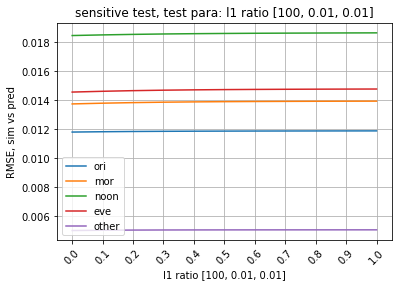

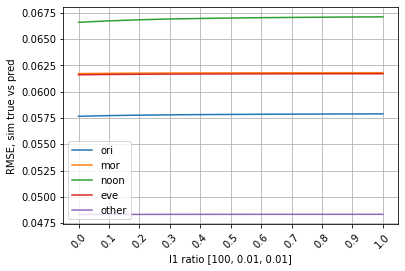

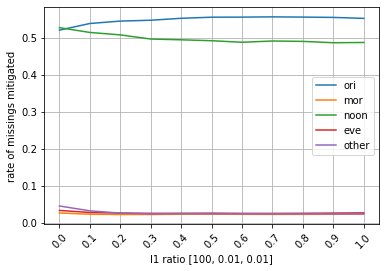

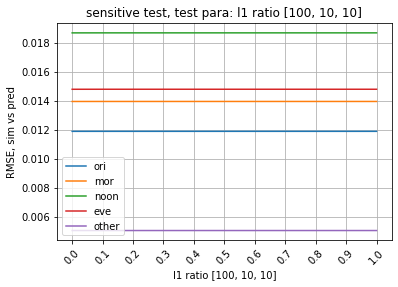

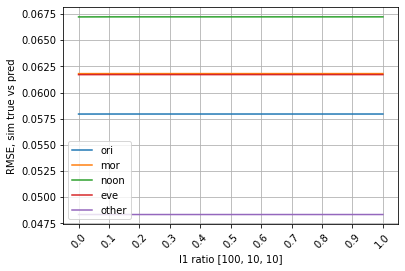

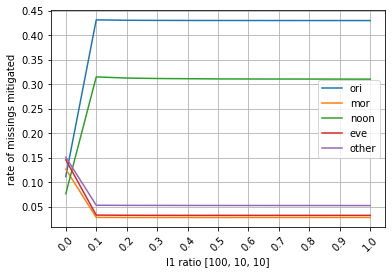

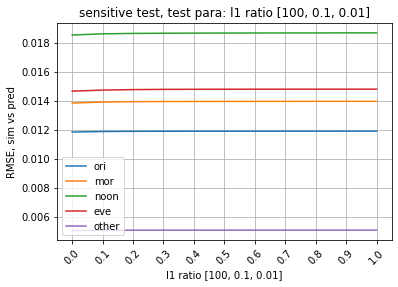

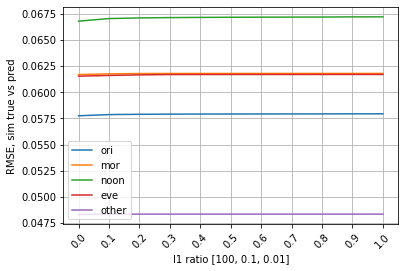

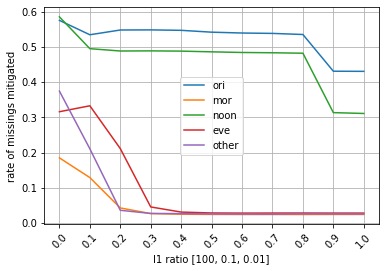

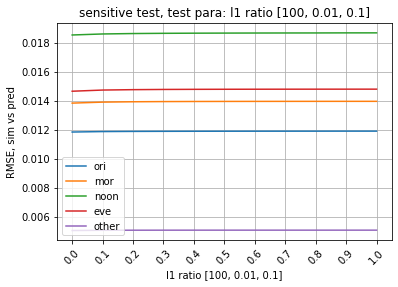

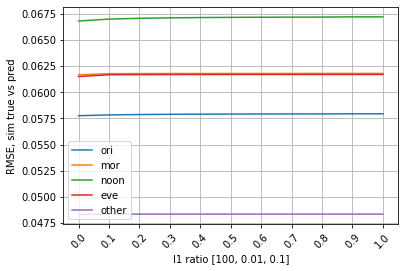

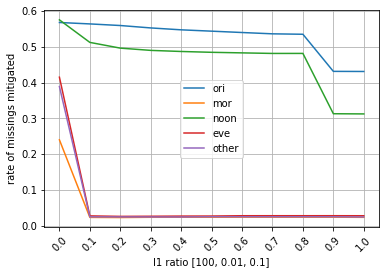

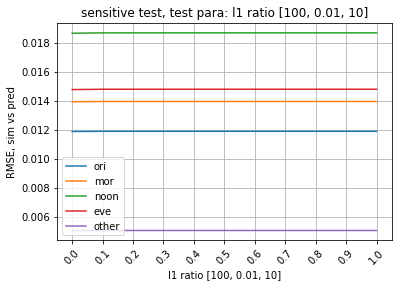

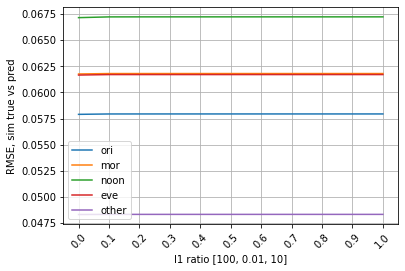

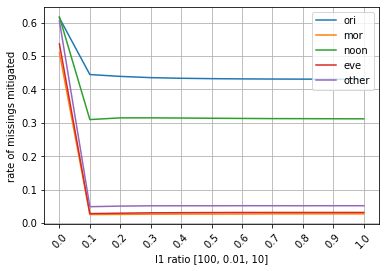

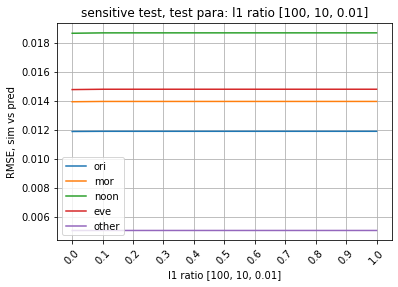

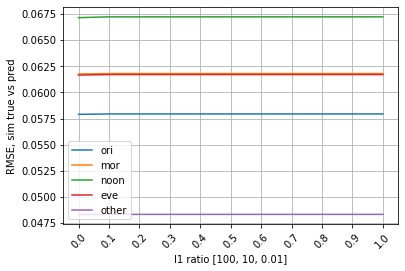

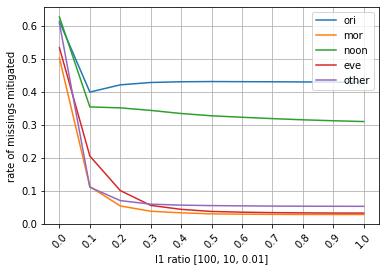

In [20]:
idx = plot_paras_sensitive(test_l1_nmf_1, l1_ratio_nmf_1, 'l1 ratio '+str(l1_ratio_nmf_1[0][:3]), 3, 1)
idx = plot_paras_sensitive(test_l1_nmf_2, l1_ratio_nmf_2, 'l1 ratio '+str(l1_ratio_nmf_2[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_3, l1_ratio_nmf_3, 'l1 ratio '+str(l1_ratio_nmf_3[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_4, l1_ratio_nmf_4, 'l1 ratio '+str(l1_ratio_nmf_4[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_5, l1_ratio_nmf_5, 'l1 ratio '+str(l1_ratio_nmf_5[0][:3]), 3, idx)
idx = plot_paras_sensitive(test_l1_nmf_6, l1_ratio_nmf_6, 'l1 ratio '+str(l1_ratio_nmf_6[0][:3]), 3, idx)

In [ ]:
test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf_100, 
                                          0, 288, result_para_dict, 'NMF')

In [ ]:
#para_lst_nmf = [k_val, alpha_W, alpha_H, l1_ratio]
#para_lst_bmf = [k_val, lambda_w, lambda_h]
#k_nmf = generate_paralst(list(np.array(range(1, 21))*10), [0], [0, 0, 0], 4)
#k_nmf = generate_paralst(list(np.array(range(1, 11))*100), [0], [0, 0, 0], 4)
#test_k_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', k_nmf, 
#                                          0.05, 288, result_para_dict, 'NMF')
test_aWaH_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aWaH_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')
test_aW_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aW_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')
test_aH_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', aW_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')
test_l1r_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0.2, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0.4, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0.6000000000000001, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0.8, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 1.0, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 1.2000000000000002, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 1.4000000000000001, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 1.6, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 1.8, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 2.0, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 2.2, 2.2, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.4000000000000004, 2.4000000000000004, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 2.6, 2.6, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 2.8000000000000003, 2.8000000000000003, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 3.0, 3.0, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 3.2, 3.2, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.4000000000000004, 3.4000000000000004, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06574498201191342
RMSE, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],other 0.005210910024361857
RMSE with True, data with missing rate>=0.05, para=[700, 3.6, 3.6, 0.0],

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0] 0.012793766067805435
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0] 0.05919531240844451
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],mor 0.014936642033285479
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],mor 0.0631963960993083
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07806832640194458
RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],noon 0.02035802912360716
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],noon 0.06903334851900955
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],eve 0.0160569887290176
RMSE with True, data with missing rate>=0.05, para=[700, 3.8000000000000003, 3.8000000000000003, 0.0],eve 0.06365826129244379
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.011385092232853547
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.05798719048789278
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01036106121491941


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.009578210046726484
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.061453210461100964
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15031143774093697


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.01708249789776988
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.06657486355458779
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014289089846705048


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.010234970267176404
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.061827433564115776
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13265968112921933


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.0035880959133879685
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.04850931475106625
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2651037202590837


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.011384106270741145
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.05798352886308953
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010513646354776357


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.009582367284772322
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.061453431295048384
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15157902732676276


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.01708201125543513
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.06657222202220119
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014257950950743762


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.010226188530872244
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.061824369709899615
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13207973735427683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.0035852234140098496
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.04851417895707773
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26431849497130333


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.011384846888831183
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.05797535424539311
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010559009504463557


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.009573768863177975
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.061448232696405376
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1507197250232629


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.01708142204213835
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.0665729591408647
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.01022682718674531
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.06182457417914234
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13225666935341185


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0035864951002883725
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0485160091158117
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2572840155797377


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.011383183295854847
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.057976865044137044
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010596124808753086


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.009576390268108054
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.06145689073781746
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15165498775138153


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.017081445122526493
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.06657295899686996
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.010237198802163873
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.06182580054668351
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13181433935557435


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.003588683924383345
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.048513285150813046
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26643005934621516


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.01138510125844128
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.0579786085106827
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010488902818583338


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.009571631844055522
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.06145950196936573
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1521772156706356


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.017078011801785545
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.06656252924236208
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014309238544091761


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.01023225162098114
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.06182929579718144
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1311901625808481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.0035839290126105532
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.04850673269423114
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2689281335778065


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.011385485462427652
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.05798396385718136
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010468283205089156


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.009581766923855942
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.0614509947342764
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15047760116979053


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.017078025998641475
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.06656250729755095
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014312901943616618


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.010236667958349047
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.06182750365000249
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13227632846442683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.0035837040859236155
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.04851294794842371
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.25976581571210033


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.01138257313191781
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.05797653395144794
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010587876963355412


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.009578037062110467
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.061461320130445016
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15085265576634574


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.017079042504712334
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.0665631320297076
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014336714040528189


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.010225551915960047
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.06183635036007552
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13270882890675684


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.003586450857327057
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.04851463535315142
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26398216358724547


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.011382025673275259
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.05797047549749516
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010388750410183025


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.009590046898981248
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.06146554962855977
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15168347291061357


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.017079047269344644
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.06656310214982374
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.010235992151955968
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.06182346742605511
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13158825957890183


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.003580348793278391
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.04851013077715255
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2610189213527031


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.011385575132303457
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.057974773177804105
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010379324301157114


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.009592785331083023
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.06146166479434206
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1531029833456769


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.017079054270585352
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.06656311586021212
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.01024157389399515
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.061833083811931415
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13004501936422436


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.003583132379948099
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.048509746153102766
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2705270638270172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.011384759184818866
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.05797343330474795
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01038462648748419


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.009575311938618757
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.061459617147655354
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15243832963026263


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.017078078119021012
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.06656266029659261
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014320228742666332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.010234246636234375
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.06182787681261163
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1323697092417481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.003588090176766771
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.0485097458949961
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26565975198272773


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.011385092232853547
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0] 0.05798719048789278
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01036106121491941


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.009578210046726484
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],mor 0.061453210461100964
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15031143774093697


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.01708249789776988
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],noon 0.06657486355458779
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014289089846705048


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.010234970267176404
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],eve 0.061827433564115776
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13265968112921933


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.0035880959133879685
RMSE with True, data with missing rate>=0.05, para=[700, 0.2, 0, 0],other 0.04850931475106625
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2651037202590837


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.011384106270741145
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0] 0.05798352886308953
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010513646354776357


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.009582367284772322
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],mor 0.061453431295048384
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15157902732676276


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.01708201125543513
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],noon 0.06657222202220119
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014257950950743762


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.010226188530872244
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],eve 0.061824369709899615
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13207973735427683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.0035852234140098496
RMSE with True, data with missing rate>=0.05, para=[700, 0.4, 0, 0],other 0.04851417895707773
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26431849497130333


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.011384846888831183
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0] 0.05797535424539311
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010559009504463557


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.009573768863177975
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],mor 0.061448232696405376
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1507197250232629


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.01708142204213835
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],noon 0.0665729591408647
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.01022682718674531
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],eve 0.06182457417914234
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13225666935341185


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0035864951002883725
RMSE with True, data with missing rate>=0.05, para=[700, 0.6000000000000001, 0, 0],other 0.0485160091158117
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2572840155797377


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.011383183295854847
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0] 0.057976865044137044
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010596124808753086


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.009576390268108054
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],mor 0.06145689073781746
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15165498775138153


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.017081445122526493
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],noon 0.06657295899686996
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014278099648130475


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.010237198802163873
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],eve 0.06182580054668351
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13181433935557435


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.003588683924383345
RMSE with True, data with missing rate>=0.05, para=[700, 0.8, 0, 0],other 0.048513285150813046
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26643005934621516


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.01138510125844128
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0] 0.0579786085106827
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010488902818583338


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.009571631844055522
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],mor 0.06145950196936573
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1521772156706356


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.017078011801785545
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],noon 0.06656252924236208
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014309238544091761


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.01023225162098114
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],eve 0.06182929579718144
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1311901625808481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.0035839290126105532
RMSE with True, data with missing rate>=0.05, para=[700, 1.0, 0, 0],other 0.04850673269423114
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2689281335778065


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.011385485462427652
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0] 0.05798396385718136
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010468283205089156


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.009581766923855942
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],mor 0.0614509947342764
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15047760116979053


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.017078025998641475
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],noon 0.06656250729755095
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014312901943616618


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.010236667958349047
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],eve 0.06182750365000249
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13227632846442683


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.0035837040859236155
RMSE with True, data with missing rate>=0.05, para=[700, 1.2000000000000002, 0, 0],other 0.04851294794842371
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.25976581571210033


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.01138257313191781
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0] 0.05797653395144794
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010587876963355412


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.009578037062110467
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],mor 0.061461320130445016
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15085265576634574


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.017079042504712334
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],noon 0.0665631320297076
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014336714040528189


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.010225551915960047
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],eve 0.06183635036007552
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13270882890675684


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.003586450857327057
RMSE with True, data with missing rate>=0.05, para=[700, 1.4000000000000001, 0, 0],other 0.04851463535315142
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26398216358724547


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.011382025673275259
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0] 0.05797047549749516
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010388750410183025


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.009590046898981248
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],mor 0.06146554962855977
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15168347291061357


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.017079047269344644
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],noon 0.06656310214982374
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.010235992151955968
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],eve 0.06182346742605511
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13158825957890183


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.003580348793278391
RMSE with True, data with missing rate>=0.05, para=[700, 1.6, 0, 0],other 0.04851013077715255
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2610189213527031


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.011385575132303457
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0] 0.057974773177804105
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010379324301157114


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.009592785331083023
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],mor 0.06146166479434206
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.1531029833456769


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.017079054270585352
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],noon 0.06656311586021212
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014333050641003332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.01024157389399515
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],eve 0.061833083811931415
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13004501936422436


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.003583132379948099
RMSE with True, data with missing rate>=0.05, para=[700, 1.8, 0, 0],other 0.048509746153102766
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2705270638270172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.011384759184818866
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0] 0.05797343330474795
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01038462648748419


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.009575311938618757
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],mor 0.061459617147655354
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.15243832963026263


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.017078078119021012
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],noon 0.06656266029659261
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014320228742666332


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.010234246636234375
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],eve 0.06182787681261163
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.1323697092417481


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.003588090176766771
RMSE with True, data with missing rate>=0.05, para=[700, 2.0, 0, 0],other 0.0485097458949961
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.26565975198272773


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.0],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.0],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.1],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.1],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.2],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.2],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.30000000000000004],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.4],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.4],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.5],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.5],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


In [15]:
test_l1r_nmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', l1_ratio_nmf, 
                                             0.05, 288, result_para_dict, 'NMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.6000000000000001],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.7000000000000001],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.8],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.8],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 0.9],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 0.9],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0] 0.011356613961060634
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0] 0.05795174450217247
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01058905522698365


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],mor 0.009574039257168166
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],mor 0.06146009789299302
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.14795191705121633


C:\Users\Yiran\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],noon 0.01706131496983044
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],noon 0.06648825425921606
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.014338545740290618
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],eve 0.010222544083168335
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],eve 0.061821482201144105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.13130811724693808
RMSE, data with missing rate>=0.05, para=[700, 0, 0, 1.0],other 0.0035837772461235454
RMSE with True, data with missing rate>=0.05, para=[700, 0, 0, 1.0],other 0.04853434373588099
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.2560227728895206


In [16]:
test_lw_bmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', lw_bmf, 
                                          0.05, 288, result_para_dict, 'BMF')
test_lh_bmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', lh_bmf, 
                                          0.05, 288, result_para_dict, 'BMF')
test_lwlh_bmf = fit_model_get_para_sensitive(fcd_dt, 'sim_t', lwlh_bmf, 
                                          0.05, 288, result_para_dict, 'BMF')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1] 0.01266307388476978
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1] 0.05863547113802357
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001402133717604378


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],mor 0.01446293242913683
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],mor 0.06271631178259134
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0015761788108395525
RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],noon 0.020070988326790003
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],noon 0.06814303225111457
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0012785264341751215
RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],eve 0.01553760292451889
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],eve 0.06313099181781245
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0021084396563587396
RMSE, data with missing rate>=0.05, para=[40, 0.0, 1.1],other 0.0050871302729668735
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 1.1],other 0.048707322432176

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1] 0.012660751954759672
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1] 0.0586512936803169
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0012460137868627141


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],mor 0.014475306958952983
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],mor 0.06271454706577564
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0013957728023699652
RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],noon 0.02007559543422185
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],noon 0.0681728525758381
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.001344467625622549
RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],eve 0.015541596381870755
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],eve 0.06313185072554992
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0024524740991212378
RMSE, data with missing rate>=0.05, para=[40, 0.2, 1.1],other 0.005089978868329058
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 1.1],other 0.04870753454774668

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1] 0.012661677873288077
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1] 0.05863378012074739
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0015293861894541871


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],mor 0.014474747103862706
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],mor 0.06268715844483659
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0016853719212290396
RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],noon 0.02006807374269711
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],noon 0.06811097572894131
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.001113673455556553
RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],eve 0.015551502390855593
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],eve 0.06312641728628948
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0020592918788212397
RMSE, data with missing rate>=0.05, para=[40, 0.4, 1.1],other 0.005087458319478042
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 1.1],other 0.0487070998455403

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1] 0.012661907789925826
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1] 0.0586428634832243
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001375622785969001


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],mor 0.014482445269651019
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],mor 0.06268272455566022
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0015192084923754724
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],noon 0.020069999675924148
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],noon 0.06808619464870795
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0010825345595952677
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],eve 0.015548406359570548
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],eve 0.06312814458439568
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.002422985432598738
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 1.1],other 0.005

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1] 0.01266188151246304
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1] 0.05864702290677792
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0016236472797133048


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],mor 0.014481605519448637
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],mor 0.06272457470773825
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.001946485880856074
RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],noon 0.020059024198409693
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],noon 0.06801805152230604
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0011777829472415517
RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],eve 0.015560424583267283
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],eve 0.0630795249231974
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0016661096585212417
RMSE, data with missing rate>=0.05, para=[40, 0.8, 1.1],other 0.005090040680900113
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 1.1],other 0.0487089601719936

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1] 0.012654255823038472
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1] 0.05860015282102721
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0017078931291323915


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],mor 0.01449429716023306
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],mor 0.06266659911652239
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.002145881995480355
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],noon 0.020064994807948766
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],noon 0.06810769758937112
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0015697666964012596
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],eve 0.015553543144121582
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],eve 0.06309967370313195
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0019265928794699903
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.1],other 0.005088118392689251
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.1],other 0.0487177900364891

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1] 0.012784869854701165
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1] 0.05913281769985498
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],mor 0.014926997642238947
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],mor 0.06313050276992795
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],noon 0.020344149107353302
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],noon 0.06895311665874682
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],eve 0.016045353221669088
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],eve 0.06358162858216337
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.1],other 0.0052080560575011895
RMSE with True, data with missing ra

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1] 0.012785483499406022
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1] 0.05913840130041578
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],mor 0.014927257200545153
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],mor 0.06313210207190617
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],noon 0.02034476849675129
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],noon 0.06895696712449641
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],eve 0.016045724875162412
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],eve 0.0635837463743693
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.1],other 0.0052081176299292155
RMSE with True, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1] 0.01278564690431911
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1] 0.05913998474795768
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],mor 0.014927357665984355
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],mor 0.06313324535796407
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],noon 0.020344989124746686
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],noon 0.06895886506262863
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],eve 0.016045866820163304
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],eve 0.06358518085256963
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.1],other 0.005208147505109095
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.1],other 0.04887775714952882
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1] 0.01278574663366126
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1] 0.059140527094740575
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],mor 0.014927425542910723
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],mor 0.06313354779444841
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],noon 0.02034513383897186
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],noon 0.06895953035177242
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],eve 0.01604596325788995
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],eve 0.06358559621828495
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.1],other 0.005208157657197397
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.1],other 0.04887815767110956
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1] 0.012785811087960454
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1] 0.05914090949947328
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],mor 0.014927468399411725
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],mor 0.06313375030570097
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],noon 0.020345225989031056
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],noon 0.06895998200276786
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],eve 0.01604602420517039
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],eve 0.06358587522629146
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 1.1],other 0.005208167680222236
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 1.1],other 0.04887823533786313
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1] 0.012785854609471497
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1] 0.05914118462089869
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],mor 0.014927496949851482
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],mor 0.06313389188916284
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],noon 0.020345287709245836
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],noon 0.06896029967362409
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],eve 0.016046064859272204
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],eve 0.0635860707487184
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 1.1],other 0.005208174347855401
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 1.1],other 0.048878289399079955
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1] 0.012785885165828065
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1] 0.05914138724984774
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],mor 0.014927516807084028
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],mor 0.06313399442953826
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],noon 0.020345330826360426
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],noon 0.06896053035799067
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],eve 0.016046093157054925
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],eve 0.06358621258310652
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 1.1],other 0.005208178981624196
RMSE with True, data with missing rat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1] 0.012785907355163911
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1] 0.05914153997788555
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],mor 0.014927531130237068
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],mor 0.06313407099128146
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],noon 0.020345362021744827
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],noon 0.06896070261799889
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],eve 0.016046113575986155
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],eve 0.0635863185572585
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 1.1],other 0.00520818232085445
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 1.1],other 0.04887835749597382
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1] 0.012785902864337447
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1] 0.05914248130232433
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],mor 0.014927541781093736
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],mor 0.06313412963870418
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],noon 0.02034538527635945
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],noon 0.0689608344315229
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],eve 0.016046128770959137
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],eve 0.06358639981208906
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 1.1],other 0.005208184801195317
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1] 0.012785917560978285
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1] 0.05914257107523344
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],mor 0.014927549912430548
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],mor 0.0631341755666796
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],noon 0.020345403058488747
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],noon 0.06896093747609766
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],eve 0.016046140373566827
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],eve 0.06358646347387448
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 1.1],other 0.005208186693036016
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 1.1],other 0.04887839706106818
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1] 0.012785929469414687
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1] 0.059142645489421504
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],mor 0.014927556253734264
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],mor 0.0631342122031797
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],noon 0.020345416960537703
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],noon 0.06896101956083661
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],eve 0.016046149429437283
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],eve 0.06358651429469411
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 1.1],other 0.005208188168912821
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 1.1],other 0.04887841089315073
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1] 0.012785939260832793
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1] 0.05914270790729852
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],mor 0.014927561299083986
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],mor 0.06313424193070677
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],noon 0.020345428036144596
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],noon 0.06896108601928798
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],eve 0.016046156637596194
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],eve 0.06358655554268285
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 1.1],other 0.005208189342081693
RMSE with True, data with missing rat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1] 0.012785947412024077
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1] 0.05914276079882939
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],mor 0.014927565380627943
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],mor 0.06313426639442733
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],noon 0.020345437008431142
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],noon 0.06896114061729335
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],eve 0.016046162469188694
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],eve 0.06358658949603842
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 1.1],other 0.005208190290950757
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 1.1],other 0.04887843130884558
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1] 0.012785954277898571
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1] 0.05914280605683616
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],mor 0.01492756873322722
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],mor 0.0631342868029797
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],noon 0.02034544438513893
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],noon 0.06896118605253168
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],eve 0.016046167258454234
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],eve 0.06358661781172226
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 1.1],other 0.005208191069217314
RMSE with True, data with missing rate>=

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1] 0.012785960121958468
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1] 0.05914284512752069
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],mor 0.01492757152312685
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],mor 0.0631343040132944
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],noon 0.020345450527515522
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],noon 0.0689612242867549
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],eve 0.016046171243956308
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],eve 0.06358664169113593
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 1.1],other 0.005208191716645489
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 1.1],other 0.04887844543863382
% of missings (sim missing vs sim true) 0.96975659026

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0] 0.012662764518337984
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0] 0.05864561320204029
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001624825543341544


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],mor 0.014926675574095591
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],mor 0.06312852752970027
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],noon 0.02025516415405294
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],noon 0.06847477854943394
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00017401147743071138
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],eve 0.016044882604906465
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],eve 0.06357869357524061
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.0],other 0.005207980918007196
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.0],other 0.04887604217872946
% of missings (sim missing vs si

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2] 0.012659739387743526
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2] 0.05863236223592702
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001547649275691891


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],mor 0.014926675484223818
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],mor 0.06312852712239915
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],noon 0.02025846114854869
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],noon 0.06851717688504942
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00031322065937528046
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],eve 0.01604488249922426
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],eve 0.0635786928152594
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.2],other 0.005207980900823131
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.2],other 0.048876042132607406
% of missings (sim missing vs sim

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4] 0.012660932184954286
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4] 0.058632167685492946
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001593601557193211


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],mor 0.014926675435400731
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],mor 0.06312852679633724
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],noon 0.02026313779575782
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],noon 0.06854174081657052
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00013371408265728347
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],eve 0.016044882458538426
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],eve 0.06357869290461814
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.4],other 0.005207980908899572
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.4],other 0.048876042170974375
% of missings (sim missing vs s

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001] 0.012659533015205117
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001] 0.0586301835750624
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0016807930656828952


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],mor 0.014926675490987433
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],mor 0.06312852715617451
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],noon 0.02026687598654935
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],noon 0.06854963721749754
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0005165393330048485
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],eve 0.016044882465604097
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],eve 0.06357869285723927
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.6000000000000001],other 0.0052079809070478406
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8] 0.012664496560607466
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8] 0.05866438149242984
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001552362330204847


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],mor 0.014926675543858106
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],mor 0.06312852734510808
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],noon 0.020262893425762214
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],noon 0.06852797514243397
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0002289624703035676
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],eve 0.01604488257598686
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],eve 0.0635786933526513
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 0.8],other 0.005207980893947554
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 0.8],other 0.04887604208215749
% of missings (sim missing vs sim 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0] 0.012663441894833684
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0] 0.05866689214684355
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0019258719003566016


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],mor 0.01492667550978586
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],mor 0.06312852721278381
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],noon 0.02025497306807271
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],noon 0.06851416332019165
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00022163567125385345
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],eve 0.01604488254358067
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],eve 0.06357869325971695
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.0],other 0.0052079809094565345
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.0],other 0.04887604216870159
% of missings (sim missing vs sim

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002] 0.012664647481878915
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002] 0.058662037031057164
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0016295385978544997


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],mor 0.014926675491684223
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],mor 0.06312852717687421
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],noon 0.020254099846106436
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],noon 0.06851769536909769
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00020515037339199657
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],eve 0.016044882639553684
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],eve 0.06357869352904998
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.2000000000000002],other 0.005207980906415789
RMSE with True, da

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001] 0.012691054657489449
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001] 0.058761280589347126
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0009779588114383476


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],mor 0.014926675531182711
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],mor 0.06312852710850277
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],noon 0.020280605271287038
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],noon 0.06868913410498835
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0001392091819445691
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],eve 0.016044882461925168
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],eve 0.06357869271963384
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.4000000000000001],other 0.005207980908105807
RMSE with True, dat

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6] 0.012721413873994539
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6] 0.058848465638922376
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0004070900835565652


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],mor 0.01492667550577161
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],mor 0.06312852716143912
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],noon 0.020331349596055356
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],noon 0.06890744383542557
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 8.425818907171288e-05
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],eve 0.016044882382875242
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],eve 0.06357869247717558
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.6],other 0.005207980912247164
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.6],other 0.04887604217559481
% of missings (sim missing vs sim

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8] 0.012743070696607907
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8] 0.058936983533965794
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 3.593704066128868e-05


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],mor 0.014926675465233134
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],mor 0.06312852708453137
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],noon 0.020338539234095378
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],noon 0.06893872586670814
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 2.381209691157103e-05
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],eve 0.016044882371743993
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],eve 0.06357869251738779
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 1.8],other 0.005207980900689159
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 1.8],other 0.04887604213734462
% of missings (sim missing vs si

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0] 0.012762432525245667
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0] 0.05904189588306303
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 1.7673954423584597e-05


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],mor 0.014926675463450447
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],mor 0.06312852706240846
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],noon 0.020340660494087386
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],noon 0.06894632553971522
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],eve 0.016044882579217108
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],eve 0.06357869369581802
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.0],other 0.005207980903602734
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.0],other 0.048876042165005774
% of missings (sim missing vs sim true) 0.9697565

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2] 0.012773882046056069
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2] 0.05909690241002876
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 1.355003172474819e-05


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],mor 0.014926675484803286
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],mor 0.06312852724365439
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],noon 0.020341444790001658
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],noon 0.06894787183465588
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],eve 0.01604488244144203
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],eve 0.06357869325759113
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.2],other 0.005207980911714782
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.2],other 0.04887604224647552
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004] 0.012781409067986034
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004] 0.059134842652281895
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 1.178263628238973e-06


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],mor 0.014926675507437598
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],mor 0.0631285274555917
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],noon 0.02034173025285126
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],noon 0.06894921846246607
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],eve 0.016044882534860982
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],eve 0.06357869389380923
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.4000000000000004],other 0.005207980914990111
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6] 0.012782956024791264
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6] 0.05913673976676229
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],mor 0.014926675462093355
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],mor 0.06312852766762836
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],noon 0.020342168170540804
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],noon 0.06895534036322366
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],eve 0.01604488256730148
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],eve 0.0635786950650535
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.6],other 0.005207980902013902
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.6],other 0.04887604238192408
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003] 0.012784240135036653
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003] 0.059143650033704455
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],mor 0.014926675525119582
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],mor 0.0631285281921648
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],noon 0.020342529511786063
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],noon 0.0689593846488896
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],eve 0.016044882607595557
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],eve 0.06357869659061786
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 2.8000000000000003],other 0.005207980913987656
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0] 0.012784583419547402
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0] 0.059145050755231
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],mor 0.014926675487961952
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],mor 0.06312852874366852
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],noon 0.020342631228280145
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],noon 0.0689601777534942
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],eve 0.01604488266892067
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],eve 0.06357869952151117
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.0],other 0.005207980910632634
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.0],other 0.048876042977973926
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2] 0.012784583101198068
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2] 0.05914352244654732
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],mor 0.014926675579137828
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],mor 0.06312853019255478
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],noon 0.020342498030690825
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],noon 0.0689580097964729
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],eve 0.016044882653604656
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],eve 0.06357870394045781
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.2],other 0.00520798089869563
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.2],other 0.04887604345912342
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004] 0.012784463664842554
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004] 0.05914038157354228
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],mor 0.014926675617464842
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],mor 0.06312853202123528
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],noon 0.020342288460607233
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],noon 0.06895414083321685
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],eve 0.01604488267770558
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],eve 0.0635787114621618
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.4000000000000004],other 0.005207980910555189
RMSE with True, data with missing rate>

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6] 0.012784349897147461
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6] 0.05913694945047188
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],mor 0.014926675578728382
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],mor 0.06312853449963465
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],noon 0.020343218765002332
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],noon 0.06896517283613504
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],eve 0.016044882746043296
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],eve 0.06357872412142214
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.6],other 0.005207980922964521
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.6],other 0.04887604568851288
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003] 0.012784626247797103
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003] 0.05914204736978321
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],mor 0.014926675544425559
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],mor 0.06312853808826228
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],noon 0.02034256994054178
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],noon 0.06895668285502453
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],eve 0.016044883043971704
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],eve 0.06357874382035718
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 3.8000000000000003],other 0.005207980922552638
RMSE with True, data with missing rate

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0] 0.012784380341163871
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0] 0.059136700929269384
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],mor 0.014926675641140134
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],mor 0.06312854389619596
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],noon 0.02034343512730801
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],noon 0.06896636100131147
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],eve 0.01604488329813984
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],eve 0.06357877320055527
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.1, 4.0],other 0.005207980950404179
RMSE with True, data with missing rate>=0.05, para=[40, 1.1, 4.0],other 0.048876050392422425
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0] 0.012657491958690882
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0] 0.058639433695273906
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001746186697050158


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],mor 0.014472630494177078
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],mor 0.06271588235577102
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0019654759870107673
RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],noon 0.02006614736568099
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],noon 0.06811263513956622
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0012785264341751215
RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],eve 0.015534121468332192
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],eve 0.06313510735542077
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.002526195765427487
RMSE, data with missing rate>=0.05, para=[40, 0.0, 0.0],other 0.005085351732421549
RMSE with True, data with missing rate>=0.05, para=[40, 0.0, 0.0],other 0.0487088575198577

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2] 0.012658830796980417
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2] 0.05865722927393146
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0015635558346731172


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],mor 0.014472863898682572
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],mor 0.06273370180848455
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0012391044265937447
RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],noon 0.020064773207433433
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],noon 0.06811480166175084
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0011155051553189813
RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],eve 0.015537683261219916
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],eve 0.06313344786230966
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0021231839896199895
RMSE, data with missing rate>=0.05, para=[40, 0.2, 0.2],other 0.005086391330521413
RMSE with True, data with missing rate>=0.05, para=[40, 0.2, 0.2],other 0.04870818280525

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4] 0.012658069775983318
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4] 0.0586612201385015
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0014162728811432457


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],mor 0.014481927314891457
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],mor 0.06271625524350874
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0013198123777511917
RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],noon 0.020063713834119503
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],noon 0.06807803016441454
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0015367961006775457
RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],eve 0.015528061263666633
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],eve 0.06313494611307205
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0028849745414512356
RMSE, data with missing rate>=0.05, para=[40, 0.4, 0.4],other 0.005087131790498495
RMSE with True, data with missing rate>=0.05, para=[40, 0.4, 0.4],other 0.04871068108423

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001] 0.01265724259166396
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001] 0.05863979397026548
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0017544345424478308


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],mor 0.014488406221581391
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],mor 0.06273027705604005
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0010064756261987504
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],noon 0.020068527801416602
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],noon 0.06810751352436303
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0014653598099428327
RMSE, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],eve 0.015549890167026839
RMSE with True, data with missing rate>=0.05, para=[40, 0.6000000000000001, 0.6000000000000001],eve 0.06313460828013721
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.00275227554

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8] 0.012656476103939152
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8] 0.058622112914527735
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0015747493391413876


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],mor 0.014486470327434971
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],mor 0.06268808447745144
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0012533470062097646
RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],noon 0.02006766235880481
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],noon 0.0680752781792194
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0011722878479542662
RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],eve 0.015557798640712538
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],eve 0.06313244105375199
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0028358267639137357
RMSE, data with missing rate>=0.05, para=[40, 0.8, 0.8],other 0.005089334686127566
RMSE with True, data with missing rate>=0.05, para=[40, 0.8, 0.8],other 0.0487098770028318

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0] 0.012656253685848905
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0] 0.05862041130179389
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001561788439230759


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],mor 0.014483216325513705
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],mor 0.06271333341100628
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.001215366793900378
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],noon 0.020058712991027884
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],noon 0.0680205522286124
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.001364616323009263
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],eve 0.015565429267344047
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],eve 0.06308477348769112
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0014449446596024927
RMSE, data with missing rate>=0.05, para=[40, 1.0, 1.0],other 0.005088415513425776
RMSE with True, data with missing rate>=0.05, para=[40, 1.0, 1.0],other 0.04870904045624753

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002] 0.012784869350808909
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002] 0.05913281519662263
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],mor 0.014926997592085043
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],mor 0.063130502656254
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],noon 0.02034414919324385
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],noon 0.06895311704292637
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],eve 0.016045353146782942
RMSE with True, data with missing rate>=0.05, para=[40, 1.2000000000000002, 1.2000000000000002],eve 0.06358162826985356
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001] 0.01278548349885569
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001] 0.059138401290752665
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],mor 0.014927257213537552
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],mor 0.06313210213289885
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],noon 0.02034476847911118
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],noon 0.06895696704534886
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],eve 0.016045724850606864
RMSE with True, data with missing rate>=0.05, para=[40, 1.4000000000000001, 1.4000000000000001],eve 0.0635837463009908
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6] 0.012785646904079608
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6] 0.05913998475115873
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],mor 0.014927357664010772
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],mor 0.06313324534802706
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],noon 0.02034498911798422
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],noon 0.06895886503812428
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],eve 0.016045866849481654
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],eve 0.06358518095829838
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.6, 1.6],other 0.005208147507024483
RMSE with True, data with missing rate>=0.05, para=[40, 1.6, 1.6],other 0.04887775716364604
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8] 0.012785746633927344
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8] 0.059140527099255095
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],mor 0.014927425542828991
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],mor 0.06313354780303694
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],noon 0.020345133828387464
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],noon 0.0689595303073322
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],eve 0.016045963237515636
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],eve 0.0635855961348259
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 1.8, 1.8],other 0.005208157657901646
RMSE with True, data with missing rate>=0.05, para=[40, 1.8, 1.8],other 0.04887815767612623
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0] 0.01278581108791029
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0] 0.059140909505118695
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],mor 0.014927468404489599
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],mor 0.06313375033472886
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],noon 0.020345225991218997
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],noon 0.06895998202034485
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],eve 0.01604602421633256
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],eve 0.06358587527475262
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.0, 2.0],other 0.005208167680199625
RMSE with True, data with missing rate>=0.05, para=[40, 2.0, 2.0],other 0.04887823534035512
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2] 0.012785854608697375
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2] 0.05914118461967108
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],mor 0.014927496953871905
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],mor 0.06313389191156518
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],noon 0.02034528771378779
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],noon 0.0689602997004255
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],eve 0.016046064854990577
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],eve 0.0635860707353645
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.2, 2.2],other 0.0052081743476903
RMSE with True, data with missing rate>=0.05, para=[40, 2.2, 2.2],other 0.04887828939816826
% of missings (sim missing vs sim true) 0.9697565902646

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004] 0.01278588516801863
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004] 0.05914138726778353
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],mor 0.014927516806761925
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],mor 0.06313399443962936
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],noon 0.020345330826993167
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],noon 0.0689605303756572
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],eve 0.016046093156699276
RMSE with True, data with missing rate>=0.05, para=[40, 2.4000000000000004, 2.4000000000000004],eve 0.06358621258759126
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6] 0.012785907355898709
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6] 0.05914153999006341
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],mor 0.014927531130965153
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],mor 0.06313407100599168
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],noon 0.020345362021485475
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],noon 0.0689607026267226
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],eve 0.016046113576466958
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],eve 0.0635863185663851
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.6, 2.6],other 0.0052081823201640814
RMSE with True, data with missing rate>=0.05, para=[40, 2.6, 2.6],other 0.0488783574955175
% of missings (sim missing vs sim true) 0.9697565902

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003] 0.012785902865089533
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003] 0.059142481307989665
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],mor 0.014927541783711501
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],mor 0.06313412966039428
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],noon 0.02034538527647442
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],noon 0.06896083444348972
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],eve 0.01604612877713246
RMSE with True, data with missing rate>=0.05, para=[40, 2.8000000000000003, 2.8000000000000003],eve 0.06358639985447666
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 2

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0] 0.012785917561328398
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0] 0.059142571075840436
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],mor 0.014927549909166678
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],mor 0.06313417556777029
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],noon 0.02034540305997565
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],noon 0.06896093749755386
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],eve 0.01604614037631268
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],eve 0.06358646350678994
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.0, 3.0],other 0.0052081866930196305
RMSE with True, data with missing rate>=0.05, para=[40, 3.0, 3.0],other 0.04887839706848393
% of missings (sim missing vs sim true) 0.969756590

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2] 0.012785929470978383
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2] 0.05914264550050396
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],mor 0.014927556255199884
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],mor 0.06313421223143902
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],noon 0.020345416961261246
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],noon 0.06896101958934683
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],eve 0.016046149435624883
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],eve 0.06358651434789803
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.2, 3.2],other 0.0052081881690143285
RMSE with True, data with missing rate>=0.05, para=[40, 3.2, 3.2],other 0.0488784109033484
% of missings (sim missing vs sim true) 0.96975659

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004] 0.012785939260757592
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004] 0.059142707910636035
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],mor 0.01492756129961532
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],mor 0.06313424195959214
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],noon 0.02034542803418331
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],noon 0.06896108604359902
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],eve 0.016046156638445868
RMSE with True, data with missing rate>=0.05, para=[40, 3.4000000000000004, 3.4000000000000004],eve 0.06358655557606648
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6] 0.012785947412202842
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6] 0.059142760805319466
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],mor 0.014927565381223026
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],mor 0.06313426643301426
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],noon 0.0203454370089041
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],noon 0.06896114065618784
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],eve 0.016046162471453542
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],eve 0.0635865895494105
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.6, 3.6],other 0.005208190290567471
RMSE with True, data with missing rate>=0.05, para=[40, 3.6, 3.6],other 0.04887843132277221
% of missings (sim missing vs sim true) 0.96975659026

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003] 0.012785954278701063
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003] 0.05914280607039255
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],mor 0.014927568733782462
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],mor 0.06313428684537473
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],noon 0.020345444384531963
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],noon 0.06896118609437378
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],eve 0.01604616726013197
RMSE with True, data with missing rate>=0.05, para=[40, 3.8000000000000003, 3.8000000000000003],eve 0.06358661786807351
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0] 0.012785960122019257
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0] 0.05914284513493734
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0


C:\Users\Yiran\AppData\Local\Temp\ipykernel_18420\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],mor 0.01492757152287952
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],mor 0.06313430406072801
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],noon 0.02034545052855473
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],noon 0.06896122435024032
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],eve 0.016046171246885777
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],eve 0.06358664176407261
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0
RMSE, data with missing rate>=0.05, para=[40, 4.0, 4.0],other 0.005208191716947168
RMSE with True, data with missing rate>=0.05, para=[40, 4.0, 4.0],other 0.04887844546650615
% of missings (sim missing vs sim true) 0.9697565902

In [22]:
#save_result_dict(test_lw_bmf,'test_lw_bmf.txt')
save_result_dict(test_lh_bmf,'test_lh_bmf.txt')
save_result_dict(test_lwlh_bmf,'test_lwlh_bmf.txt')

In [ ]:
#read the param fitting data
txt_file = 'result_para_simt_para.txt'
with open(txt_file, 'r') as f:
    lines = f.readlines()
    
f.close()

In [20]:
result_para_dict

{'ori': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'mor': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'noon': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'eve': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []},
 'other': {'rmse_predvssim': [],
  'rmse_predvstrue': [],
  'per of missings (sim missing vs sim true)': [],
  'per of missings mitigated': []}}

In [85]:
def str2value(lines):
    return(float(lines.split(' ')[-1][:-2]))
    
def process_lines(lines, result_para_dict, para_name):
    idx = 0
    add_val = str2value(lines)
    print(add_val)
    if 'mor' in lines:
        result_para_dict['mor'][para_name].append(add_val)
        idx = 1
    elif 'noon' in lines:
        result_para_dict['noon'][para_name].append(add_val)
        idx = 2
    elif 'eve' in lines:
        result_para_dict['eve'][para_name].append(add_val)
        idx = 3
    elif 'other' in lines:
        result_para_dict['other'][para_name].append(add_val)
        idx = 4
    else:
        result_para_dict['ori'][para_name].append(add_val)
    return(result_para_dict, idx)

def process_lines_idx(lines, idx, result_para_dict, para_name):
    add_val = str2value(lines)
    print(add_val)
    if idx == 1:
        result_para_dict['mor'][para_name].append(add_val)
    elif idx == 2:
        result_para_dict['noon'][para_name].append(add_val)
    elif idx == 3:
        result_para_dict['eve'][para_name].append(add_val)
    elif idx == 4:
        result_para_dict['other'][para_name].append(add_val)
    else:
        result_para_dict['ori'][para_name].append(add_val)
    return(result_para_dict)

def get_para(lines):
    para_val = lines.split('=')[-1]
    para_val = para_val.split(']')[0]
    #print(para_val)
    para_val = para_val.strip('[').split(',')
    #print(para_val)
    para_lst = []
    idx = 0
    for i in para_val:
        if idx == 0:
            para_lst.append(int(i))
            idx = 1
        else:
            para_lst.append(float(i))
    return(para_lst)

    
para_result =  copy.deepcopy(result_para_dict)
paras = []
for i in lines:
    #print(i)
    if 'RMSE,' in i:
        para_result, idx = process_lines(i, para_result, 'rmse_predvssim')
        para_info =  get_para(i)
        if para_info not in paras:
            paras.append(para_info)
            repeat_idx = False
        else: 
            repeat_idx = True
        #print(idx)
    if repeat_idx == False:
        if 'MSE with True' in i:
            para_result = process_lines_idx(i, idx, para_result, 'rmse_predvstrue')
        elif '% of missings (' in i:
            para_result = process_lines_idx(i, idx, para_result, 'per of missings (sim missing vs sim true)')
        elif '% of missings mitigated' in i:
            para_result = process_lines_idx(i, idx, para_result, 'per of missings mitigated')
        else:
            pass


0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.016056988729017
3
0.00521091002436185
4
0.01279376606780543
0
0.0591953124084445
0.937905018919301
0.0
0.01493664203328547
1
0.0203580291236071
2
0.0160

In [ ]:
idx = plot_paras_sensitive(test_aWaH_nmf, list(np.array(aWaH_nmf)[:, 1]), 'aWaH', 1)
idx = plot_paras_sensitive(test_aW_nmf, list(np.array(aW_nmf)[:, 1]), 'aW', idx)
idx = plot_paras_sensitive(test_aH_nmf, list(np.array(aH_nmf)[:, 2]), 'aH', idx)
idx = plot_paras_sensitive(test_l1r_nmf, list(np.array(l1_ratio_nmf)[:, 3]), 'l1_ratio', idx)

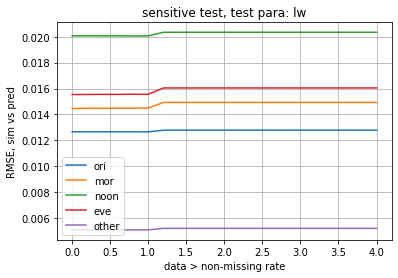

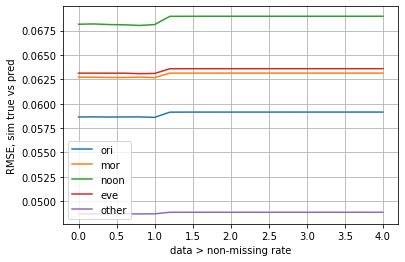

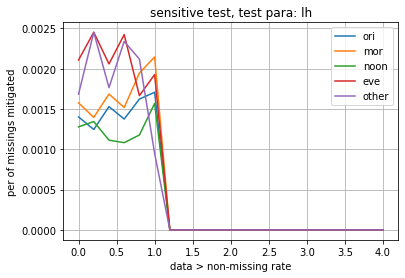

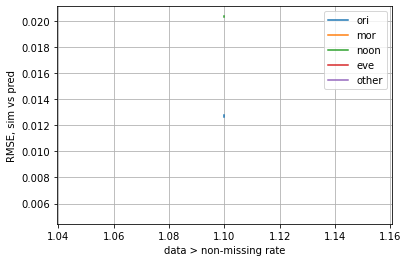

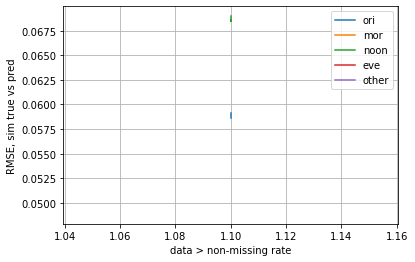

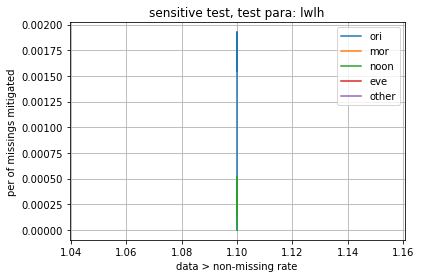

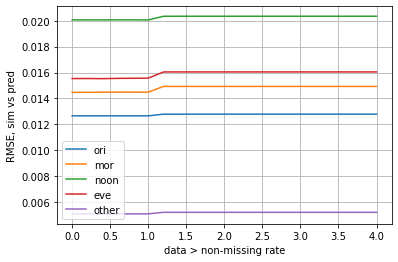

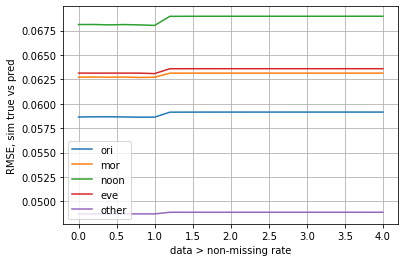

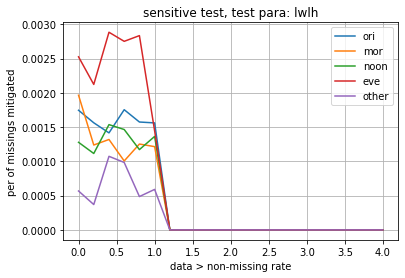

In [19]:
idx = plot_paras_sensitive(test_lw_bmf, list(np.array(lw_bmf)[:, 1]), 'lw', 1)
idx = plot_paras_sensitive(test_lh_bmf, list(np.array(lw_bmf)[:, 2]), 'lh', idx)
idx = plot_paras_sensitive(test_lwlh_bmf, list(np.array(lw_bmf)[:, 1]), 'lwlh', idx)

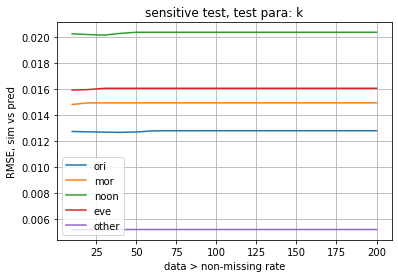

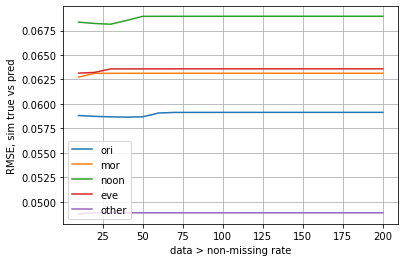

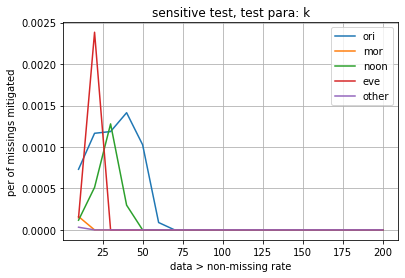

In [241]:
plot_paras_sensitive(test_k_bmf, list(np.array(k_bmf)[:, 0]), 'k')
#k bmf = 30/40

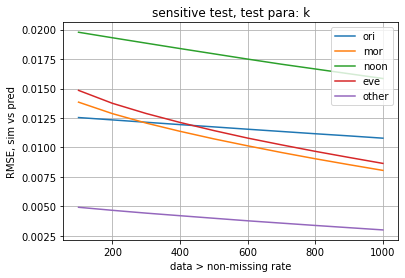

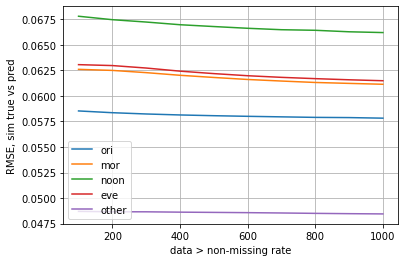

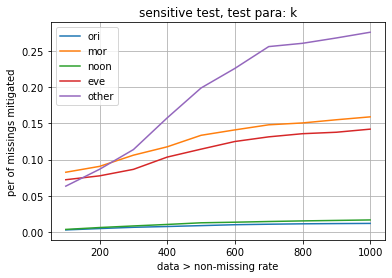

In [242]:
plot_paras_sensitive(test_k_nmf, list(np.array(k_nmf)[:, 0]), 'k')
#k = 700

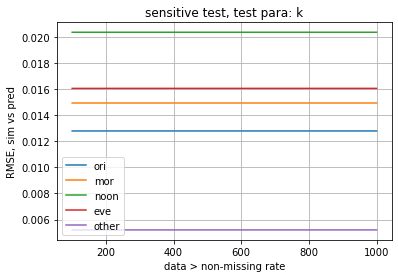

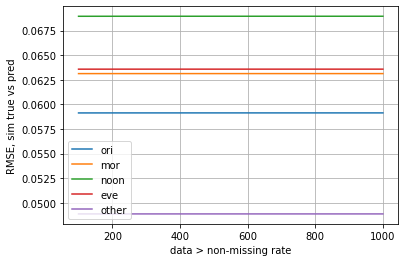

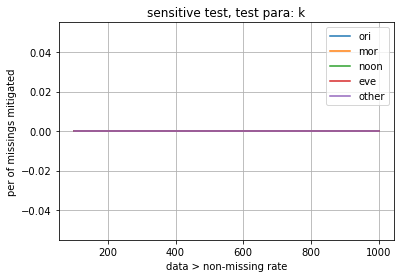

In [244]:
plot_paras_sensitive(test_k_bmf_100, list(np.array(k_bmf)[:, 0]), 'k')

In [16]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
fit_process_dt_mf01(fcd_dt, 'all', 'sim_t', missing_info, 0.05, 100, 'SVD')

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100 0.01251388795158972
RMSE with True, data with missing rate>=0.05, k=100 0.05860620104015138
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00261574525469052


[0.01251388795158972,
 0.05860620104015138,
 0.9379050189193012,
 0.00261574525469052]

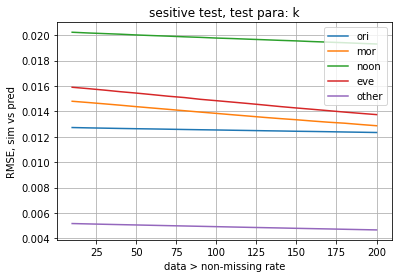

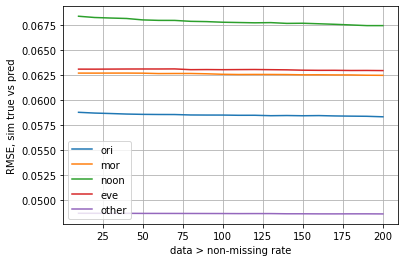

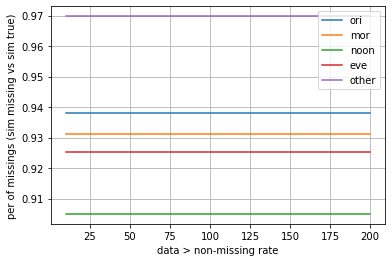

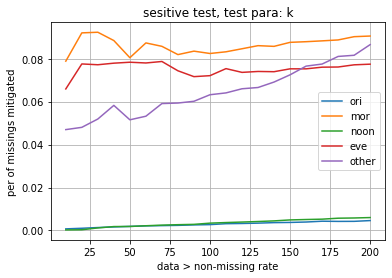

In [228]:
plot_paras_sensitive(test_k_nmf, list(np.array(k_nmf)[:, 0]), 'k')

### SVD

In [ ]:
k_svd = list(np.array(range(1, 10))*10)
k_svd.extend(list(np.array(range(1, 11))*100))

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10 0.01272439912760697
RMSE with True, data with missing rate>=0.05, k=10 0.05876526168109402
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00028631806166207045


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,mor 0.014796460926171009
RMSE with True, data with missing rate>=0.05, k=10,mor 0.06272964917463858
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07819650961848877
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,noon 0.020218640791200098
RMSE with True, data with missing rate>=0.05, k=10,noon 0.06830343873972776
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0001263872836075693
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,eve 0.0158980097764757
RMSE with True, data with missing rate>=0.05, k=10,eve 0.06313101085000375
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06593665834430967
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=10,other 0.005172630488776107
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20 0.012698658192684344
RMSE with True, data with missing rate>=0.05, k=20 0.058726264330379405
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0006733776635385731


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,mor 0.01469379700266771
RMSE with True, data with missing rate>=0.05, k=20,mor 0.06274289846334391
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07875671775005222
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,noon 0.02016369009197465
RMSE with True, data with missing rate>=0.05, k=20,noon 0.06827940023452661
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0006685704132864174
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,eve 0.015786154295402165
RMSE with True, data with missing rate>=0.05, k=20,eve 0.0631388981645393
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06637407356439341
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=20,other 0.0051427647103015044
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30 0.012674583068238016
RMSE with True, data with missing rate>=0.05, k=30 0.05870696031131813
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.000874271612153318


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,mor 0.014592827369991464
RMSE with True, data with missing rate>=0.05, k=30,mor 0.06274949293861547
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07912702482006874
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,noon 0.020111376766227915
RMSE with True, data with missing rate>=0.05, k=30,noon 0.06826261092305241
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0009872861719489835
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,eve 0.015675180196683233
RMSE with True, data with missing rate>=0.05, k=30,eve 0.06314988481202291
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06700316511687342
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=30,other 0.0051152560817824
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40 0.01265061176063572
RMSE with True, data with missing rate>=0.05, k=40 0.05868526119031616
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0012030071644319915


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,mor 0.014492442293173216
RMSE with True, data with missing rate>=0.05, k=40,mor 0.06275326195805277
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0796872329516322
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,noon 0.02005967031639653
RMSE with True, data with missing rate>=0.05, k=40,noon 0.06825191197756075
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0015148157035284032
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,eve 0.01555946284162002
RMSE with True, data with missing rate>=0.05, k=40,eve 0.06316269414314869
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06805984233392966
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=40,other 0.005088505672072714
RMSE wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50 0.012627853191760718
RMSE with True, data with missing rate>=0.05, k=50 0.058676776572598066
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0014321794401244718


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,mor 0.014388795113943583
RMSE with True, data with missing rate>=0.05, k=50,mor 0.06276105169096946
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08003380238895536
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,noon 0.020007943918278846
RMSE with True, data with missing rate>=0.05, k=50,noon 0.06823162271833283
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0018207095638539696
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,eve 0.015455624756902459
RMSE with True, data with missing rate>=0.05, k=50,eve 0.0631745564837398
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.0681728822222659
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=50,other 0.005062345578752747
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60 0.012604805248848636
RMSE with True, data with missing rate>=0.05, k=60 0.05866072092628654
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.001701412679177077


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,mor 0.014291502639169177
RMSE with True, data with missing rate>=0.05, k=60,mor 0.06272841564948482
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08000056970318464
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,noon 0.01995223533453689
RMSE with True, data with missing rate>=0.05, k=60,noon 0.06816544639307262
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.002285961303510819
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,eve 0.015344003111576054
RMSE with True, data with missing rate>=0.05, k=60,eve 0.06318338116049546
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06904771266243341
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=60,other 0.005036475241885138
RMSE wi

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70 0.012581860175669566
RMSE with True, data with missing rate>=0.05, k=70 0.058646601837011016
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.002014830804288644


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,mor 0.014189250306205638
RMSE with True, data with missing rate>=0.05, k=70,mor 0.06273211244381094
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08022370345050228
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,noon 0.019899321510746155
RMSE with True, data with missing rate>=0.05, k=70,noon 0.06812190634764952
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0025405675704883862
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,eve 0.015233333133852578
RMSE with True, data with missing rate>=0.05, k=70,eve 0.06318932843731316
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06945072443824091
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=70,other 0.005011124162658304
RMSE 

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80 0.012558935756823224
RMSE with True, data with missing rate>=0.05, k=80 0.05863133885470938
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0022133682256469107


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,mor 0.014089219938945187
RMSE with True, data with missing rate>=0.05, k=80,mor 0.06273045171642225
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08078865910860442
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,noon 0.01984629874610174
RMSE with True, data with missing rate>=0.05, k=80,noon 0.06807434702826709
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0029014124236868086
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,eve 0.015126738014505805
RMSE with True, data with missing rate>=0.05, k=80,eve 0.06315547210640592
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07046808343326715
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=80,other 0.004986140455373994
RMSE w

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90 0.012536269503124772
RMSE with True, data with missing rate>=0.05, k=90 0.058617265454400554
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0023524033337791097


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,mor 0.01398708784770039
RMSE with True, data with missing rate>=0.05, k=90,mor 0.06271650009446206
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08062724320628953
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,noon 0.019795741559303377
RMSE with True, data with missing rate>=0.05, k=90,noon 0.06804721157096418
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.003143196792327376
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,eve 0.015009754490732413
RMSE with True, data with missing rate>=0.05, k=90,eve 0.06315965672421316
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07054671987732715
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=90,other 0.00496120938731839
RMSE wit

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100 0.01251388795158972
RMSE with True, data with missing rate>=0.05, k=100 0.05860620104015138
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.00261574525469052


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,mor 0.013887873742357153
RMSE with True, data with missing rate>=0.05, k=100,mor 0.06269813726327378
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0808456294270685
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,noon 0.019744122128450194
RMSE with True, data with missing rate>=0.05, k=100,noon 0.06801358356576716
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0034564174517026564
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,eve 0.014896396041398913
RMSE with True, data with missing rate>=0.05, k=100,eve 0.06315093491615612
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07057620854384965
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=100,other 0.004936644571128517

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200 0.012295233239953107
RMSE with True, data with missing rate>=0.05, k=200 0.05852316321401374
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.0043525058427147665


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,mor 0.012928385330996146
RMSE with True, data with missing rate>=0.05, k=200,mor 0.06253590969670259
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0835896997664217
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,noon 0.01925256351050141
RMSE with True, data with missing rate>=0.05, k=200,noon 0.06777587014656178
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.005940202329555758
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,eve 0.013806806811942346
RMSE with True, data with missing rate>=0.05, k=200,eve 0.06297986458322204
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07424263274814713
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=200,other 0.004698014914839834
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300 0.012079116093050965
RMSE with True, data with missing rate>=0.05, k=300 0.05842992686924735
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.005719880783286095


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,mor 0.012114073920502316
RMSE with True, data with missing rate>=0.05, k=300,mor 0.062277700421009045
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08891642454281319
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,noon 0.01876885238616999
RMSE with True, data with missing rate>=0.05, k=300,noon 0.06752064342639835
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.008330570519525004
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,eve 0.012913025299450664
RMSE with True, data with missing rate>=0.05, k=300,eve 0.0626969740143843
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07844476772760335
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=300,other 0.004471470021344645


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400 0.011865348400385759
RMSE with True, data with missing rate>=0.05, k=400 0.05834322373501625
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.007020683828861921


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,mor 0.01138792211630343
RMSE with True, data with missing rate>=0.05, k=400,mor 0.06202561755859306
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09027896465941244
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,noon 0.01828606754156259
RMSE with True, data with missing rate>=0.05, k=400,noon 0.06723741099785181
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.010510293236814967
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,eve 0.01212196635531647
RMSE with True, data with missing rate>=0.05, k=400,eve 0.06241564210451962
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08169343582283209
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=400,other 0.0042535398427526495
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500 0.01165150888374347
RMSE with True, data with missing rate>=0.05, k=500 0.05825322340569762
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.008210730093383283


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,mor 0.010716699978183402
RMSE with True, data with missing rate>=0.05, k=500,mor 0.06179899689434544
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09063977667635162
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,noon 0.017809192545537977
RMSE with True, data with missing rate>=0.05, k=500,noon 0.06697318018203259
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.012320012602094366
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,eve 0.01139712627665344
RMSE with True, data with missing rate>=0.05, k=500,eve 0.062180033860415
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08493718914030708
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=500,other 0.004041241595305185
RM

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600 0.011436553983409535
RMSE with True, data with missing rate>=0.05, k=600 0.05816755306844206
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.009325367485697353


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,mor 0.010086315255427762
RMSE with True, data with missing rate>=0.05, k=600,mor 0.06161634816085759
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0917127176740918
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,noon 0.01734182562260698
RMSE with True, data with missing rate>=0.05, k=600,noon 0.06676854193394091
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.01407294927473848
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,eve 0.010733881926918046
RMSE with True, data with missing rate>=0.05, k=600,eve 0.06199563141172471
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08568915013663082
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=600,other 0.0038265136765927195
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700 0.01122005487430628
RMSE with True, data with missing rate>=0.05, k=700 0.05808480134283356
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010204941284177746


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,mor 0.009492959888792313
RMSE with True, data with missing rate>=0.05, k=700,mor 0.0614768906018187
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09177918304563322
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,noon 0.016883424317773177
RMSE with True, data with missing rate>=0.05, k=700,noon 0.06660062705347512
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.015212266526969031
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,eve 0.010103354889723746
RMSE with True, data with missing rate>=0.05, k=700,eve 0.06183514411745591
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08578253091395208
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=700,other 0.003624511403804118


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800 0.011003871761808814
RMSE with True, data with missing rate>=0.05, k=800 0.05800854164859684
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.010854753675151539


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,mor 0.008925229928203361
RMSE with True, data with missing rate>=0.05, k=800,mor 0.06136394402000741
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09142786608177139
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,noon 0.01643342018715075
RMSE with True, data with missing rate>=0.05, k=800,noon 0.06645223609896674
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.015944946431940447
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,eve 0.00951654705488561
RMSE with True, data with missing rate>=0.05, k=800,eve 0.0617116862719472
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08666227613187331
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=800,other 0.0034203443814308956
R

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900 0.010788153534932956
RMSE with True, data with missing rate>=0.05, k=900 0.05794019146939301
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01133607436728716


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,mor 0.008388268965534596
RMSE with True, data with missing rate>=0.05, k=900,mor 0.061272718335423956
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.09210201485026301
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,noon 0.015991240308932998
RMSE with True, data with missing rate>=0.05, k=900,noon 0.06631595695267961
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.016531090355917582
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,eve 0.008951788095050662
RMSE with True, data with missing rate>=0.05, k=900,eve 0.06160162713490394
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08638704857766331
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=900,other 0.00322313615868457

C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000 0.010573342123859655
RMSE with True, data with missing rate>=0.05, k=1000 0.05787636985586655
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.01166893384226467


C:\Users\Yiran\AppData\Local\Temp\ipykernel_14792\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,mor 0.007875288142622304
RMSE with True, data with missing rate>=0.05, k=1000,mor 0.061192064891678825
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.0930847528437684
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,noon 0.015557984700365082
RMSE with True, data with missing rate>=0.05, k=1000,noon 0.06620462161912881
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.016976193398187716
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,eve 0.008407052763282878
RMSE with True, data with missing rate>=0.05, k=1000,eve 0.06150388284929176
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.08647059979947706
if pred & fit dt is equal, with tol=0.01: False
RMSE, data with missing rate>=0.05, k=1000,other 0.00302790515

4

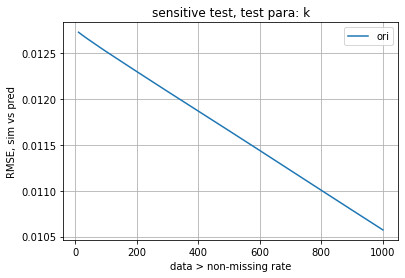

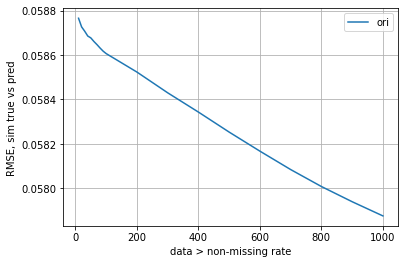

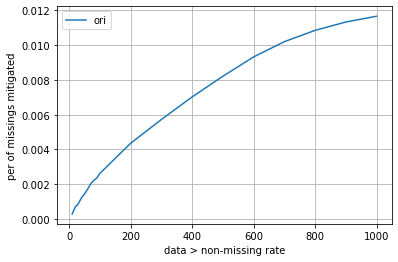

In [49]:
test_k_svd = fit_model_get_para(fcd_dt, 'sim_t', k_svd, 
                       0.05, 288, 
                       result_para_dict, 'SVD',
                       True)



4

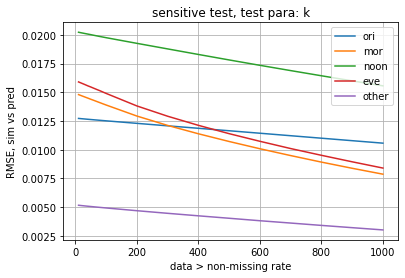

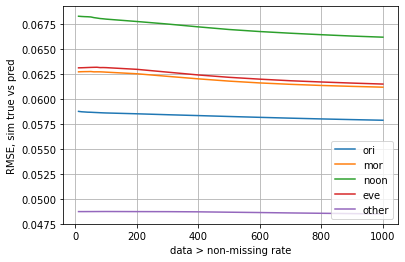

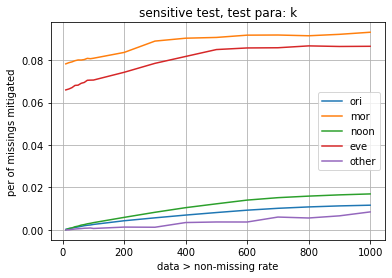

In [66]:
plot_paras_sensitive(test_k_svd, k_svd, 'k', 1)

In [134]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
ypop_simt = []
for i in x_val_simt:
    ypop_simt.append(len(np.where(missing_info>=i)[0]))
    
missing_info = check_missings(fcd_dt, 'sim_t2', 288, False)
ypop_simt2 =[]    
for i in x_val_simt2:
    ypop_simt2.append(len(np.where(missing_info>=i)[0]))

C:\Users\Yiran\AppData\Local\Temp\ipykernel_25820\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


In [ ]:
x_val_simt = 0.01*np.array(range(1, 10))
#result_para_dict_simt = fit_model_get_para(fcd_dt, 'sim_t', 10, x_val_simt, 288, result_para_dict, 'BMF')
#result_para_dict_simt_100 = fit_model_get_para(fcd_dt, 'sim_t', 100, x_val_simt, 288, result_para_dict, 'BMF')
k_val = 100
result_para_dict_simt_100_bmf = copy.deepcopy(result_para_dict)
for i in x_val_simt:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'BMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'BMF')
    result_para_dict_simt_100_bmf = add_result2dict(result_para, result_para_time, result_para_dict_simt_100_bmf)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100)  

In [47]:
missing_info = check_missings(fcd_dt, 'sim_t', 288, False)
k_val = 10
result_para_dict_simt = copy.deepcopy(result_para_dict)
for i in 0.01*np.array(range(1, 10)):
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt = add_result2dict(result_para, result_para_time, result_para_dict_simt)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))
    

k_val = 100
result_para_dict_simt_100 = copy.deepcopy(result_para_dict)
for i in 0.01*np.array(range(1, 10)):
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt_100)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100)   


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.01, k=10 0.011861481770917106
RMSE with True, data with missing rate>=0.01, k=10 0.057591293538391555
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.00036099353686940016


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=10,mor 0.013859302799877782
RMSE with True, data with missing rate>=0.01, k=10,mor 0.061409481654068586
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.1439850457495264
RMSE, data with missing rate>=0.01, k=10,noon 0.018599294114145782
RMSE with True, data with missing rate>=0.01, k=10,noon 0.06663463440471604
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0006290470711084486


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=10,eve 0.014686795660785661
RMSE with True, data with missing rate>=0.01, k=10,eve 0.06131457613238765
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.12332745836244746
RMSE, data with missing rate>=0.01, k=10,other 0.0050391726058245725
RMSE with True, data with missing rate>=0.01, k=10,other 0.04817776021159453
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.0866651885793117


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.02, k=10 0.011877536296354201
RMSE with True, data with missing rate>=0.02, k=10 0.05761897340150735
% of missings (sim missing vs sim true) 0.9472590758840116
% of missings mitigated 0.00036045797961888244


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=10,mor 0.01388070242604708
RMSE with True, data with missing rate>=0.02, k=10,mor 0.06145347607074007
% of missings (sim missing vs sim true) 0.941791457094955
% of missings mitigated 0.14271409136655355
RMSE, data with missing rate>=0.02, k=10,noon 0.018625756960884653
RMSE with True, data with missing rate>=0.02, k=10,noon 0.06666683229718667
% of missings (sim missing vs sim true) 0.919286908436214
% of missings mitigated 0.00034875836194317667


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=10,eve 0.014703299983863547
RMSE with True, data with missing rate>=0.02, k=10,eve 0.06126603262672687
% of missings (sim missing vs sim true) 0.9359861845972957
% of missings mitigated 0.12121997241610334
RMSE, data with missing rate>=0.02, k=10,other 0.00504378203699889
RMSE with True, data with missing rate>=0.02, k=10,other 0.04820066095892989
% of missings (sim missing vs sim true) 0.974339353127232
% of missings mitigated 0.08601381107795056


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.03, k=10 0.012001591648297517
RMSE with True, data with missing rate>=0.03, k=10 0.057746840221452135
% of missings (sim missing vs sim true) 0.946319543721706
% of missings mitigated 0.00036554165076642446


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.03, k=10,mor 0.014012703450132393
RMSE with True, data with missing rate>=0.03, k=10,mor 0.061559866704815516
% of missings (sim missing vs sim true) 0.9407736676991502
% of missings mitigated 0.12791749879303205
RMSE, data with missing rate>=0.03, k=10,noon 0.018830281157937768
RMSE with True, data with missing rate>=0.03, k=10,noon 0.06681604334763545
% of missings (sim missing vs sim true) 0.9177500297831784
% of missings mitigated 0.00016226193132263758


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=10,eve 0.014880110096300274
RMSE with True, data with missing rate>=0.03, k=10,eve 0.06145329045786582
% of missings (sim missing vs sim true) 0.9348080261411212
% of missings mitigated 0.11237004448595374
RMSE, data with missing rate>=0.03, k=10,other 0.005085500808195335
RMSE with True, data with missing rate>=0.03, k=10,other 0.048298424827468475
% of missings (sim missing vs sim true) 0.9739660560376656
% of missings mitigated 0.07757608932990441


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.04, k=10 0.012333412474008829
RMSE with True, data with missing rate>=0.04, k=10 0.05806906215263047
% of missings (sim missing vs sim true) 0.9432730700318003
% of missings mitigated 0.0003199875464306254


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,mor 0.014389104925496029
RMSE with True, data with missing rate>=0.04, k=10,mor 0.0619822568105651
% of missings (sim missing vs sim true) 0.9372626845127913
% of missings mitigated 0.11620325679289772


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,noon 0.01943439020966053
RMSE with True, data with missing rate>=0.04, k=10,noon 0.06729071592148717
% of missings (sim missing vs sim true) 0.9129778940623665
% of missings mitigated 9.503896597605019e-05


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,eve 0.015310394182962388
RMSE with True, data with missing rate>=0.04, k=10,eve 0.06191236456627443
% of missings (sim missing vs sim true) 0.9312137670104351
% of missings mitigated 0.09430005635722617


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=10,other 0.005156913382794126
RMSE with True, data with missing rate>=0.04, k=10,other 0.048426473670651636
% of missings (sim missing vs sim true) 0.9725853541433519
% of missings mitigated 0.09505327673228782


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=10 0.012729749571966173
RMSE with True, data with missing rate>=0.05, k=10 0.05880726664682562
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.000742306085790553


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=10,mor 0.01479752473155533
RMSE with True, data with missing rate>=0.05, k=10,mor 0.06272493392831388
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.07883742570120968


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=10,noon 0.020230021374531098
RMSE with True, data with missing rate>=0.05, k=10,noon 0.06840617573166134
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.00025826966650242426
RMSE, data with missing rate>=0.05, k=10,eve 0.015899886455230366
RMSE with True, data with missing rate>=0.05, k=10,eve 0.06312067571611471
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.06590716967778718
RMSE, data with missing rate>=0.05, k=10,other 0.005172363428812574
RMSE with True, data with missing rate>=0.05, k=10,other 0.04871799070733817
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.0469656941988261


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=10 0.012770963765824813
RMSE with True, data with missing rate>=0.06, k=10 0.059887635174768555
% of missings (sim missing vs sim true) 0.931887830937642
% of missings mitigated 0.0005793668013440371


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.06, k=10,mor 0.014895481608422963
RMSE with True, data with missing rate>=0.06, k=10,mor 0.06409554392871193
% of missings (sim missing vs sim true) 0.9237925366348407
% of missings mitigated 0.05994926932687211
RMSE, data with missing rate>=0.06, k=10,noon 0.0205370567774557
RMSE with True, data with missing rate>=0.06, k=10,noon 0.06980675343678953
% of missings (sim missing vs sim true) 0.8961185867170286
% of missings mitigated 0.0003292976082017058
RMSE, data with missing rate>=0.06, k=10,eve 0.016107691438151106
RMSE with True, data with missing rate>=0.06, k=10,eve 0.06497919622359812
% of missings (sim missing vs sim true) 0.9171275686856424
% of missings mitigated 0.051363012355363794


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=10,other 0.004933129317534506
RMSE with True, data with missing rate>=0.06, k=10,other 0.04922779459510219
% of missings (sim missing vs sim true) 0.9669447501021027
% of missings mitigated 0.03289661295095639


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.07, k=10 0.011992614263893142
RMSE with True, data with missing rate>=0.07, k=10 0.060584920113530394
% of missings (sim missing vs sim true) 0.9254866740358634
% of missings mitigated 0.0018053885179502066


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=10,mor 0.014056608880928344
RMSE with True, data with missing rate>=0.07, k=10,mor 0.06534559487715583
% of missings (sim missing vs sim true) 0.9157455170719725
% of missings mitigated 0.04611498569384836
RMSE, data with missing rate>=0.07, k=10,noon 0.019494547469498524
RMSE with True, data with missing rate>=0.07, k=10,noon 0.0716626726709641
% of missings (sim missing vs sim true) 0.8877118644067796
% of missings mitigated 0.0009511950468679741


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=10,eve 0.015438681984233605
RMSE with True, data with missing rate>=0.07, k=10,eve 0.06717567682473358
% of missings (sim missing vs sim true) 0.909801031687546
% of missings mitigated 0.038948415912614845
RMSE, data with missing rate>=0.07, k=10,other 0.004321308784059673
RMSE with True, data with missing rate>=0.07, k=10,other 0.04847803607771668
% of missings (sim missing vs sim true) 0.9628921356663033
% of missings mitigated 0.029221272074077823


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=10 0.009650150431630694
RMSE with True, data with missing rate>=0.08, k=10 0.05677436238546328
% of missings (sim missing vs sim true) 0.9182703625235404
% of missings mitigated 0.007714738916571868


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.08, k=10,mor 0.010688582884434163
RMSE with True, data with missing rate>=0.08, k=10,mor 0.060358234150394596
% of missings (sim missing vs sim true) 0.9111935028248588
% of missings mitigated 0.05916166117677453
RMSE, data with missing rate>=0.08, k=10,noon 0.015948706624935666
RMSE with True, data with missing rate>=0.08, k=10,noon 0.06970939212550449
% of missings (sim missing vs sim true) 0.8773172669491526
% of missings mitigated 0.006716474228360123
RMSE, data with missing rate>=0.08, k=10,eve 0.012885753461279553
RMSE with True, data with missing rate>=0.08, k=10,eve 0.06537460640518673
% of missings (sim missing vs sim true) 0.8980024213075061
% of missings mitigated 0.023255813953488372
RMSE, data with missing rate>=0.08, k=10,other 0.003116114595040795
RMSE with True, data with missing rate>=0.08, k=10,other 0.042936930492251904
% of missings (sim missing vs sim true) 0.9587302143157305
% of missings mitigated 0.13260889416491645


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10 0.007690334758278416
RMSE with True, data with missing rate>=0.09, k=10 0.051016427193137544
% of missings (sim missing vs sim true) 0.911108193277311
% of missings mitigated 0.02562008614753967


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.09, k=10,mor 0.007828231347560718
RMSE with True, data with missing rate>=0.09, k=10,mor 0.053418281987026695
% of missings (sim missing vs sim true) 0.9082633053221288
% of missings mitigated 0.14006682086867128


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10,noon 0.012727082029697806
RMSE with True, data with missing rate>=0.09, k=10,noon 0.06397895272199196
% of missings (sim missing vs sim true) 0.8701855742296919
% of missings mitigated 0.011920329946685444
RMSE, data with missing rate>=0.09, k=10,eve 0.010502100208879794
RMSE with True, data with missing rate>=0.09, k=10,eve 0.059767333535504445
% of missings (sim missing vs sim true) 0.888235294117647
% of missings mitigated 0.035139883768076766


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=10,other 0.00238980846981346
RMSE with True, data with missing rate>=0.09, k=10,other 0.0372070395469539
% of missings (sim missing vs sim true) 0.951038266546288
% of missings mitigated 0.27643493500803273


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100 0.011718845062469205
RMSE with True, data with missing rate>=0.01, k=100 0.05742133942388645
% of missings (sim missing vs sim true) 0.9473901679100936
% of missings mitigated 0.0018350243881973586


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,mor 0.012943196577740271
RMSE with True, data with missing rate>=0.01, k=100,mor 0.06139424374519242
% of missings (sim missing vs sim true) 0.9419291151736052
% of missings mitigated 0.14339554194042484


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,noon 0.018247480696655702
RMSE with True, data with missing rate>=0.01, k=100,noon 0.06634585496873031
% of missings (sim missing vs sim true) 0.9194973019534142
% of missings mitigated 0.0028249052316393257


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,eve 0.013676315064261806
RMSE with True, data with missing rate>=0.01, k=100,eve 0.061271522966663716
% of missings (sim missing vs sim true) 0.9361450782260623
% of missings mitigated 0.1243234223617383


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.01, k=100,other 0.004810967024234538
RMSE with True, data with missing rate>=0.01, k=100,other 0.048168615439306096
% of missings (sim missing vs sim true) 0.9743975329455968
% of missings mitigated 0.11693192538267247


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100 0.011733566569767748
RMSE with True, data with missing rate>=0.02, k=100 0.05744962395342661
% of missings (sim missing vs sim true) 0.9472590758840116
% of missings mitigated 0.0018887118199733947


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.02, k=100,mor 0.012964622958688716
RMSE with True, data with missing rate>=0.02, k=100,mor 0.06143577672558209
% of missings (sim missing vs sim true) 0.941791457094955
% of missings mitigated 0.1421249070707173


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100,noon 0.01827392259203088
RMSE with True, data with missing rate>=0.02, k=100,noon 0.06637771509463157
% of missings (sim missing vs sim true) 0.919286908436214
% of missings mitigated 0.002607430204611382
RMSE, data with missing rate>=0.02, k=100,eve 0.013700908948636592
RMSE with True, data with missing rate>=0.02, k=100,eve 0.06128546629518019
% of missings (sim missing vs sim true) 0.9359861845972957
% of missings mitigated 0.12117024812421652


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.02, k=100,other 0.004815628678019117
RMSE with True, data with missing rate>=0.02, k=100,other 0.04819144758270118
% of missings (sim missing vs sim true) 0.974339353127232
% of missings mitigated 0.11566341460576761


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100 0.011857189689905543
RMSE with True, data with missing rate>=0.03, k=100 0.057585196976337294
% of missings (sim missing vs sim true) 0.946319543721706
% of missings mitigated 0.0019217983468993545


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,mor 0.013091975124042513
RMSE with True, data with missing rate>=0.03, k=100,mor 0.061566936034890274
% of missings (sim missing vs sim true) 0.9407736676991502
% of missings mitigated 0.13432827945727333


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,noon 0.018472161225652914
RMSE with True, data with missing rate>=0.03, k=100,noon 0.06652067168402429
% of missings (sim missing vs sim true) 0.9177500297831784
% of missings mitigated 0.002539399225199278
RMSE, data with missing rate>=0.03, k=100,eve 0.013879608477173365
RMSE with True, data with missing rate>=0.03, k=100,eve 0.06147088566450972
% of missings (sim missing vs sim true) 0.9348080261411212
% of missings mitigated 0.10448600836193925


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.03, k=100,other 0.0048549057757592455
RMSE with True, data with missing rate>=0.03, k=100,other 0.04828926300943124
% of missings (sim missing vs sim true) 0.9739660560376656
% of missings mitigated 0.1072021022368868


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100 0.012175408280241933
RMSE with True, data with missing rate>=0.04, k=100 0.057885257080326914
% of missings (sim missing vs sim true) 0.9432730700318003
% of missings mitigated 0.0021683676979254666


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.04, k=100,mor 0.013454469391263654
RMSE with True, data with missing rate>=0.04, k=100,mor 0.06195752304479292
% of missings (sim missing vs sim true) 0.9372626845127913
% of missings mitigated 0.11162349068696492


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,noon 0.019053665125387184
RMSE with True, data with missing rate>=0.04, k=100,noon 0.06694953571832818
% of missings (sim missing vs sim true) 0.9129778940623665
% of missings mitigated 0.0026903338060912667


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,eve 0.014277790834191059
RMSE with True, data with missing rate>=0.04, k=100,eve 0.06193061209542259
% of missings (sim missing vs sim true) 0.9312137670104351
% of missings mitigated 0.09655106882134759


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.04, k=100,other 0.0049219933587330116
RMSE with True, data with missing rate>=0.04, k=100,other 0.04841361978202191
% of missings (sim missing vs sim true) 0.9725853541433519
% of missings mitigated 0.07768275706862726


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100 0.012537902574912135
RMSE with True, data with missing rate>=0.05, k=100 0.05853086733659989
% of missings (sim missing vs sim true) 0.9379050189193012
% of missings mitigated 0.002722967244860267


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.05, k=100,mor 0.013843213028521144
RMSE with True, data with missing rate>=0.05, k=100,mor 0.06260554479826538
% of missings (sim missing vs sim true) 0.9310948440483768
% of missings mitigated 0.08240756565829203


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100,noon 0.01977246559190874
RMSE with True, data with missing rate>=0.05, k=100,noon 0.06780792098408596
% of missings (sim missing vs sim true) 0.904978583174199
% of missings mitigated 0.0034124566574043717
RMSE, data with missing rate>=0.05, k=100,eve 0.014843101059781693
RMSE with True, data with missing rate>=0.05, k=100,eve 0.06306572448088565
% of missings (sim missing vs sim true) 0.9251068473219969
% of missings mitigated 0.07208013053649714


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.05, k=100,other 0.004927446588611469
RMSE with True, data with missing rate>=0.05, k=100,other 0.04869171920371929
% of missings (sim missing vs sim true) 0.9697565902646628
% of missings mitigated 0.06319910817936228


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100 0.012457821394958409
RMSE with True, data with missing rate>=0.06, k=100 0.0595330527865058
% of missings (sim missing vs sim true) 0.931887830937642
% of missings mitigated 0.005392567920202192


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,mor 0.013861891523689846
RMSE with True, data with missing rate>=0.06, k=100,mor 0.06382172910693823
% of missings (sim missing vs sim true) 0.9237925366348407
% of missings mitigated 0.0730010600439161


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,noon 0.019858375829254395
RMSE with True, data with missing rate>=0.06, k=100,noon 0.06907508500548713
% of missings (sim missing vs sim true) 0.8961185867170286
% of missings mitigated 0.006904273185295764
RMSE, data with missing rate>=0.06, k=100,eve 0.01493134470726502
RMSE with True, data with missing rate>=0.06, k=100,eve 0.06472994054673181
% of missings (sim missing vs sim true) 0.9171275686856424
% of missings mitigated 0.06187487742694646


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.06, k=100,other 0.004648387867537759
RMSE with True, data with missing rate>=0.06, k=100,other 0.04916312707495369
% of missings (sim missing vs sim true) 0.9669447501021027
% of missings mitigated 0.07726991471846331


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100 0.011329832116100173
RMSE with True, data with missing rate>=0.07, k=100 0.060100909144346355
% of missings (sim missing vs sim true) 0.9254866740358634
% of missings mitigated 0.013320615435657114


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.07, k=100,mor 0.012410904154695694
RMSE with True, data with missing rate>=0.07, k=100,mor 0.0645911127635084
% of missings (sim missing vs sim true) 0.9157455170719725
% of missings mitigated 0.078616773962804


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100,noon 0.018134310841257557
RMSE with True, data with missing rate>=0.07, k=100,noon 0.07069427111459081
% of missings (sim missing vs sim true) 0.8877118644067796
% of missings mitigated 0.012988136003597247
RMSE, data with missing rate>=0.07, k=100,eve 0.013577201540000822
RMSE with True, data with missing rate>=0.07, k=100,eve 0.06630736467714958
% of missings (sim missing vs sim true) 0.909801031687546
% of missings mitigated 0.061951817824165145


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.07, k=100,other 0.003874158098419388
RMSE with True, data with missing rate>=0.07, k=100,other 0.0482881463237679
% of missings (sim missing vs sim true) 0.9628921356663033
% of missings mitigated 0.1945744573192329


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=100 0.008197304995008576
RMSE with True, data with missing rate>=0.08, k=100 0.05592133829779657
% of missings (sim missing vs sim true) 0.9182703625235404
% of missings mitigated 0.04322817361767581


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.08, k=100,mor 0.007526928160644816
RMSE with True, data with missing rate>=0.08, k=100,mor 0.05876000001163887
% of missings (sim missing vs sim true) 0.9111935028248588
% of missings mitigated 0.14163921720596784


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.08, k=100,noon 0.012925001583698473
RMSE with True, data with missing rate>=0.08, k=100,noon 0.06780630419430676
% of missings (sim missing vs sim true) 0.8773172669491526
% of missings mitigated 0.03134354639901391
RMSE, data with missing rate>=0.08, k=100,eve 0.008987527177881508
RMSE with True, data with missing rate>=0.08, k=100,eve 0.0633000693530829
% of missings (sim missing vs sim true) 0.8980024213075061
% of missings mitigated 0.09908998988877654
RMSE, data with missing rate>=0.08, k=100,other 0.0021772026684106346
RMSE with True, data with missing rate>=0.08, k=100,other 0.04252596224841436
% of missings (sim missing vs sim true) 0.9587302143157305
% of missings mitigated 0.36794813259063097


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100 0.0052040000840710594
RMSE with True, data with missing rate>=0.09, k=100 0.04946726894450069
% of missings (sim missing vs sim true) 0.911108193277311
% of missings mitigated 0.15333621559302493


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100,mor 0.003561714003103202
RMSE with True, data with missing rate>=0.09, k=100,mor 0.051049659553870363
% of missings (sim missing vs sim true) 0.9082633053221288
% of missings mitigated 0.34425597532767926


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.09, k=100,noon 0.007725539465128526
RMSE with True, data with missing rate>=0.09, k=100,noon 0.06101082775451818
% of missings (sim missing vs sim true) 0.8701855742296919
% of missings mitigated 0.08927673272306609
RMSE, data with missing rate>=0.09, k=100,eve 0.004564356091072934
RMSE with True, data with missing rate>=0.09, k=100,eve 0.05647657692901584
% of missings (sim missing vs sim true) 0.888235294117647
% of missings mitigated 0.19164751993512638
RMSE, data with missing rate>=0.09, k=100,other 0.001107215084676042
RMSE with True, data with missing rate>=0.09, k=100,other 0.03666044604774989
% of missings (sim missing vs sim true) 0.951038266546288
% of missings mitigated 0.5815320578355484


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


0.13194444444444445
0.006944444444444444
0.6631944444444444
0.4513888888888889


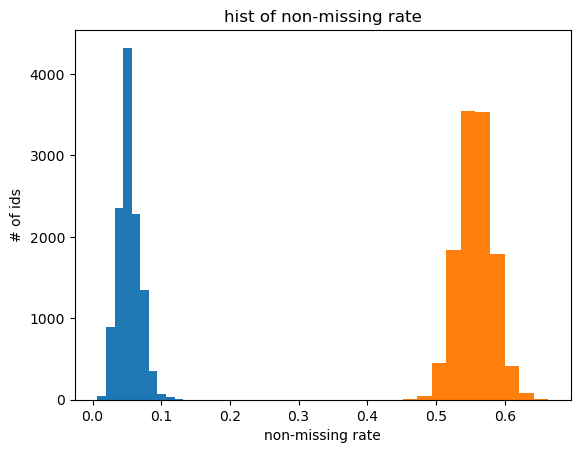

In [69]:
missing_info = check_missings(fcd_dt, 'sim_t', 288)
missing_info_simt2 = check_missings(fcd_dt, 'sim_t2', 288)

In [37]:
x_val_simt2 = (0.02*np.array(range(22, 32)))+0.01

In [39]:
missing_info = check_missings(fcd_dt, 'sim_t2', 288, False)
k_val = 10
result_para_dict_simt2 = copy.deepcopy(result_para_dict)
for i in x_val:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t2', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t2', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt2 = add_result2dict(result_para, result_para_time, result_para_dict_simt2)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))'''
    
k_val = 100
result_para_dict_simt2_100 = copy.deepcopy(result_para_dict)
for i in x_val:
    result_para = fit_process_dt_nmf(fcd_dt, 'all', 'sim_t2', missing_info, i, k_val, 'NMF')
    result_para_time = fit_dtbytime(fcd_dt, 'sim_t2', 'all', missing_info, i, 12, k_val, 'NMF')
    result_para_dict_simt2_100 = add_result2dict(result_para, result_para_time, result_para_dict_simt2_100)
    #rmse_sparse_100.append(fit_process_dt_nmf_csrsparse(sim_dt, missing_info, i, 100))

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.45, k=10 0.04111722559182743
RMSE with True, data with missing rate>=0.45, k=10 0.054303558364962645
% of missings (sim missing vs sim true) 0.44363132348336043
% of missings mitigated 3.0080012834138808e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.45, k=10,mor 0.04603721382201868
RMSE with True, data with missing rate>=0.45, k=10,mor 0.05538060840320619
% of missings (sim missing vs sim true) 0.3595358745883983
% of missings mitigated 7.258186904911154e-05
RMSE, data with missing rate>=0.45, k=10,noon 0.05771167886871295
RMSE with True, data with missing rate>=0.45, k=10,noon 0.06161263580970071
% of missings (sim missing vs sim true) 0.1568745196003074
% of missings mitigated 6.805151499685262e-05
RMSE, data with missing rate>=0.45, k=10,eve 0.04767238939154101
RMSE with True, data with missing rate>=0.45, k=10,eve 0.05491400228645466
% of missings (sim missing vs sim true) 0.2982492100093945
% of missings mitigated 0.0001227224753941437
RMSE, data with missing rate>=0.45, k=10,other 0.023304530100790068
RMSE with True, data with missing rate>=0.45, k=10,other 0.04569884888139243
% of missings (sim missing vs sim true) 0.73821366484353
% of missings mitigated 0.0


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.47000000000000003, k=10 0.04111639877003737
RMSE with True, data with missing rate>=0.47000000000000003, k=10 0.05429885145621064
% of missings (sim missing vs sim true) 0.44359871137690443
% of missings mitigated 3.0092504358397714e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.47000000000000003, k=10,mor 0.04603781584016959
RMSE with True, data with missing rate>=0.47000000000000003, k=10,mor 0.0553781340911575
% of missings (sim missing vs sim true) 0.3594902463334757
% of missings mitigated 7.261588835637237e-05
RMSE, data with missing rate>=0.47000000000000003, k=10,noon 0.05748672921067693
RMSE with True, data with missing rate>=0.47000000000000003, k=10,noon 0.06133045439729243
% of missings (sim missing vs sim true) 0.15684981489392003
% of missings mitigated 0.00013049719431032232
RMSE, data with missing rate>=0.47000000000000003, k=10,eve 0.0476724597686474
RMSE with True, data with missing rate>=0.47000000000000003, k=10,eve 0.05491020452965904
% of missings (sim missing vs sim true) 0.2981924696405688
% of missings mitigated 0.00012278777361208887
RMSE, data with missing rate>=0.47000000000000003, k=10,other 0.02330343885890285
RMSE with True, data with missing rate>=0.47000000000000003, k=10,other 0.0456912550768033

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.49, k=10 0.04113116871445562
RMSE with True, data with missing rate>=0.49, k=10 0.054310325907520884
% of missings (sim missing vs sim true) 0.443381446415141
% of missings mitigated 3.019495878388126e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.49, k=10,mor 0.04605544584762949
RMSE with True, data with missing rate>=0.49, k=10,mor 0.05539026222999334
% of missings (sim missing vs sim true) 0.3592451375203496
% of missings mitigated 7.287712254619415e-05
RMSE, data with missing rate>=0.49, k=10,noon 0.05749544469411315
RMSE with True, data with missing rate>=0.49, k=10,noon 0.06133199060000812
% of missings (sim missing vs sim true) 0.1566302159198012
% of missings mitigated 0.00013106085212347072
RMSE, data with missing rate>=0.49, k=10,eve 0.04769605053224289
RMSE with True, data with missing rate>=0.49, k=10,eve 0.054928982811856535
% of missings (sim missing vs sim true) 0.29792281234317053
% of missings mitigated 0.0001232569414200843
RMSE, data with missing rate>=0.49, k=10,other 0.023264774902154027
RMSE with True, data with missing rate>=0.49, k=10,other 0.04553670199102238
% of missings (sim missing vs sim true) 0.7379936566654227
% of missings mitigated 7.676158236325883e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.51, k=10 0.041184081235263424
RMSE with True, data with missing rate>=0.51, k=10 0.054322687650986606
% of missings (sim missing vs sim true) 0.4422419403405503
% of missings mitigated 2.8141249855861892e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.51, k=10,mor 0.04614880698773168
RMSE with True, data with missing rate>=0.51, k=10,mor 0.05545914647576983
% of missings (sim missing vs sim true) 0.35792755777020135
% of missings mitigated 6.784444625362968e-05
RMSE, data with missing rate>=0.51, k=10,noon 0.05755710878642277
RMSE with True, data with missing rate>=0.51, k=10,noon 0.06137783926326854
% of missings (sim missing vs sim true) 0.1557072660780371
% of missings mitigated 0.0001345115767680962
RMSE, data with missing rate>=0.51, k=10,eve 0.047761284355657144
RMSE with True, data with missing rate>=0.51, k=10,eve 0.05496826688826913
% of missings (sim missing vs sim true) 0.29655439411536977
% of missings mitigated 0.0001263370672955445
RMSE, data with missing rate>=0.51, k=10,other 0.023298016369414136
RMSE with True, data with missing rate>=0.51, k=10,other 0.04549559339073957
% of missings (sim missing vs sim true) 0.7368015322381962
% of missings mitigated 7.844513890182689e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.53, k=10 0.041487874319830295
RMSE with True, data with missing rate>=0.53, k=10 0.054542247587347985
% of missings (sim missing vs sim true) 0.43779281748369225
% of missings mitigated 3.036685496712204e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.53, k=10,mor 0.04649625181919368
RMSE with True, data with missing rate>=0.53, k=10,mor 0.055713138800225104
% of missings (sim missing vs sim true) 0.35272269127560707
% of missings mitigated 7.731440676655688e-05
RMSE, data with missing rate>=0.53, k=10,noon 0.05779052739359679
RMSE with True, data with missing rate>=0.53, k=10,noon 0.06152222921005614
% of missings (sim missing vs sim true) 0.1520264742456967
% of missings mitigated 0.00014798869904480023
RMSE, data with missing rate>=0.53, k=10,eve 0.04839289133593939
RMSE with True, data with missing rate>=0.53, k=10,eve 0.0556061392929522
% of missings (sim missing vs sim true) 0.2918347311435865
% of missings mitigated 6.728052132792527e-05
RMSE, data with missing rate>=0.53, k=10,other 0.023570437312259208
RMSE with True, data with missing rate>=0.53, k=10,other 0.04567812941140119
% of missings (sim missing vs sim true) 0.7320459291881743
% of missings mitigated 7.758373224302328e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.55, k=10 0.0419878677078346
RMSE with True, data with missing rate>=0.55, k=10 0.054838395683896306
% of missings (sim missing vs sim true) 0.42850012053626974
% of missings mitigated 3.289372943432994e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.55, k=10,mor 0.047266541128441836
RMSE with True, data with missing rate>=0.55, k=10,mor 0.05625179770976011
% of missings (sim missing vs sim true) 0.34117207913400527
% of missings mitigated 5.6983953318745444e-05
RMSE, data with missing rate>=0.55, k=10,noon 0.058304903386335726
RMSE with True, data with missing rate>=0.55, k=10,noon 0.061888384758768615
% of missings (sim missing vs sim true) 0.14504741741321392
% of missings mitigated 0.00015078862450616725
RMSE, data with missing rate>=0.55, k=10,eve 0.0489445503801498
RMSE with True, data with missing rate>=0.55, k=10,eve 0.05584569031229092
% of missings (sim missing vs sim true) 0.2818229083346665
% of missings mitigated 9.933727844239147e-05
RMSE, data with missing rate>=0.55, k=10,other 0.023828971609620865
RMSE with True, data with missing rate>=0.55, k=10,other 0.04559143079013039
% of missings (sim missing vs sim true) 0.7217974049771871
% of missings mitigated 9.616324672764486e-06


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.5700000000000001, k=10 0.04224019237296494
RMSE with True, data with missing rate>=0.5700000000000001, k=10 0.05493546506722652
% of missings (sim missing vs sim true) 0.41504928181030465
% of missings mitigated 3.0110883327854826e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.5700000000000001, k=10,mor 0.04774753620161773
RMSE with True, data with missing rate>=0.5700000000000001, k=10,mor 0.05646701033537079
% of missings (sim missing vs sim true) 0.325993134706392
% of missings mitigated 2.555779896235336e-05
RMSE, data with missing rate>=0.5700000000000001, k=10,noon 0.05862421009167481
RMSE with True, data with missing rate>=0.5700000000000001, k=10,noon 0.06202370640033234
% of missings (sim missing vs sim true) 0.13569786042791443
% of missings mitigated 0.00020722048259347946
RMSE, data with missing rate>=0.5700000000000001, k=10,eve 0.050053860923813594
RMSE with True, data with missing rate>=0.5700000000000001, k=10,eve 0.05680285412029061
% of missings (sim missing vs sim true) 0.26764932727740165
% of missings mitigated 0.0004482581967213115
RMSE, data with missing rate>=0.5700000000000001, k=10,other 0.0237556867937643
RMSE with True, data with missing rate>=0.5700000000000001, k=10,other 0.04550867321548507
% of 

C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=10 0.04061707975560004
RMSE with True, data with missing rate>=0.59, k=10 0.05334242000650133
% of missings (sim missing vs sim true) 0.40096785241874533
% of missings mitigated 6.627246820762427e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.59, k=10,mor 0.04668923015559086
RMSE with True, data with missing rate>=0.59, k=10,mor 0.05564405939537624
% of missings (sim missing vs sim true) 0.3075869236583523
% of missings mitigated 0.0001535862386730149
RMSE, data with missing rate>=0.59, k=10,noon 0.05681967903539097
RMSE with True, data with missing rate>=0.59, k=10,noon 0.060137378192501076
% of missings (sim missing vs sim true) 0.12745358560090703
% of missings mitigated 0.00013899506567516853


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=10,eve 0.0489701270739688
RMSE with True, data with missing rate>=0.59, k=10,eve 0.05597666904631493
% of missings (sim missing vs sim true) 0.2527939747327502
% of missings mitigated 0.00038443056222969726
RMSE, data with missing rate>=0.59, k=10,other 0.02192833204092225
RMSE with True, data with missing rate>=0.59, k=10,other 0.04367143834401894
% of missings (sim missing vs sim true) 0.688613875302187
% of missings mitigated 4.082174165960791e-05


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.61, k=10 0.03225722962442523
RMSE with True, data with missing rate>=0.61, k=10 0.04301526298238092
% of missings (sim missing vs sim true) 0.3779633620689655
% of missings mitigated 0.006098043874237745


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.61, k=10,mor 0.03658036705882046
RMSE with True, data with missing rate>=0.61, k=10,mor 0.044813576951435286
% of missings (sim missing vs sim true) 0.2893917624521073
% of missings mitigated 0.0008274720728175424
RMSE, data with missing rate>=0.61, k=10,noon 0.04525043343926336
RMSE with True, data with missing rate>=0.61, k=10,noon 0.04860589232318428
% of missings (sim missing vs sim true) 0.11687320402298851
% of missings mitigated 0.0
RMSE, data with missing rate>=0.61, k=10,eve 0.04151569391647262
RMSE with True, data with missing rate>=0.61, k=10,eve 0.04869995394879642
% of missings (sim missing vs sim true) 0.23251231527093597
% of missings mitigated 0.0005296610169491525


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=10,other 0.01635616970163936
RMSE with True, data with missing rate>=0.61, k=10,other 0.033439662743337796
% of missings (sim missing vs sim true) 0.6535337703049302
% of missings mitigated 0.06050365202223918


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.63, k=10 0.010885600988090612
RMSE with True, data with missing rate>=0.63, k=10 0.018149991625865874
% of missings (sim missing vs sim true) 0.35763888888888884
% of missings mitigated 0.11650485436893204


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


RMSE, data with missing rate>=0.63, k=10,mor 0.009015541373590261
RMSE with True, data with missing rate>=0.63, k=10,mor 0.013753181754522252
% of missings (sim missing vs sim true) 0.29282407407407407
% of missings mitigated 0.07509881422924901
RMSE, data with missing rate>=0.63, k=10,noon 0.014407005005534372
RMSE with True, data with missing rate>=0.63, k=10,noon 0.016657969838092167
% of missings (sim missing vs sim true) 0.10590277777777779
% of missings mitigated 0.03278688524590164
RMSE, data with missing rate>=0.63, k=10,eve 0.014660407450502644
RMSE with True, data with missing rate>=0.63, k=10,eve 0.020436684537250126
% of missings (sim missing vs sim true) 0.21785714285714286
% of missings mitigated 0.08196721311475409
RMSE, data with missing rate>=0.63, k=10,other 0.005659571535496818
RMSE with True, data with missing rate>=0.63, k=10,other 0.017580883587102046
% of missings (sim missing vs sim true) 0.6170798898071626
% of missings mitigated 0.21986607142857142


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100 0.03661180469915875
RMSE with True, data with missing rate>=0.45, k=100 0.04772029726269818
% of missings (sim missing vs sim true) 0.44363132348336043
% of missings mitigated 0.001961885281515498


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,mor 0.0399072301463096
RMSE with True, data with missing rate>=0.45, k=100,mor 0.046988737726024486
% of missings (sim missing vs sim true) 0.3595358745883983
% of missings mitigated 0.0011085230909318852


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,noon 0.0470074718049499
RMSE with True, data with missing rate>=0.45, k=100,noon 0.04752247628153762
% of missings (sim missing vs sim true) 0.1568745196003074
% of missings mitigated 0.006561300237613207


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,eve 0.0412284365402123
RMSE with True, data with missing rate>=0.45, k=100,eve 0.04659399418421835
% of missings (sim missing vs sim true) 0.2982492100093945
% of missings mitigated 0.0017999296391141074


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.45, k=100,other 0.02217211717448885
RMSE with True, data with missing rate>=0.45, k=100,other 0.043142143891319484
% of missings (sim missing vs sim true) 0.73821366484353
% of missings mitigated 0.0006539865932748378


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100 0.03664640248206911
RMSE with True, data with missing rate>=0.47000000000000003, k=100 0.047756410928834855
% of missings (sim missing vs sim true) 0.44359871137690443
% of missings mitigated 0.0019707246743155124


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,mor 0.039982074584738105
RMSE with True, data with missing rate>=0.47000000000000003, k=100,mor 0.0471163379586906
% of missings (sim missing vs sim true) 0.3594902463334757
% of missings mitigated 0.0011420498805138565
RMSE, data with missing rate>=0.47000000000000003, k=100,noon 0.0470358524049391
RMSE with True, data with missing rate>=0.47000000000000003, k=100,noon 0.04755021331088671
% of missings (sim missing vs sim true) 0.15684981489392003
% of missings mitigated 0.0066610307008834095


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,eve 0.04128185186095567
RMSE with True, data with missing rate>=0.47000000000000003, k=100,eve 0.04665774031557236
% of missings (sim missing vs sim true) 0.2981924696405688
% of missings mitigated 0.001743586385291662


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.47000000000000003, k=100,other 0.022183249781803815
RMSE with True, data with missing rate>=0.47000000000000003, k=100,other 0.04320429334365754
% of missings (sim missing vs sim true) 0.7381856309198936
% of missings mitigated 0.0006657127334776987


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100 0.03665475100141675
RMSE with True, data with missing rate>=0.49, k=100 0.047765624007991336
% of missings (sim missing vs sim true) 0.443381446415141
% of missings mitigated 0.001944555345681953


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,mor 0.039956425774333934
RMSE with True, data with missing rate>=0.49, k=100,mor 0.047062711165676986
% of missings (sim missing vs sim true) 0.3592451375203496
% of missings mitigated 0.0010799064522754225


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,noon 0.046984992869108996
RMSE with True, data with missing rate>=0.49, k=100,noon 0.047483318725211936
% of missings (sim missing vs sim true) 0.1566302159198012
% of missings mitigated 0.006518852818663066


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,eve 0.04134937934473869
RMSE with True, data with missing rate>=0.49, k=100,eve 0.046766154536627434
% of missings (sim missing vs sim true) 0.29792281234317053
% of missings mitigated 0.001758465697593203


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.49, k=100,other 0.02216476396104477
RMSE with True, data with missing rate>=0.49, k=100,other 0.04307152884783094
% of missings (sim missing vs sim true) 0.7379936566654227
% of missings mitigated 0.0006582305687649445


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100 0.036688565444053446
RMSE with True, data with missing rate>=0.51, k=100 0.04775289141995688
% of missings (sim missing vs sim true) 0.4422419403405503
% of missings mitigated 0.001946550843688398


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,mor 0.040087135397491196
RMSE with True, data with missing rate>=0.51, k=100,mor 0.04722813238354725
% of missings (sim missing vs sim true) 0.35792755777020135
% of missings mitigated 0.0011737089201877935


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,noon 0.047120162792793574
RMSE with True, data with missing rate>=0.51, k=100,noon 0.047645204783516165
% of missings (sim missing vs sim true) 0.1557072660780371
% of missings mitigated 0.005842481095275135


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,eve 0.04134715947822645
RMSE with True, data with missing rate>=0.51, k=100,eve 0.04673964746250669
% of missings (sim missing vs sim true) 0.29655439411536977
% of missings mitigated 0.001819253769055841


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.51, k=100,other 0.02219413396096074
RMSE with True, data with missing rate>=0.51, k=100,other 0.04302815938717784
% of missings (sim missing vs sim true) 0.7368015322381962
% of missings mitigated 0.000694239479281168


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100 0.03686233432728058
RMSE with True, data with missing rate>=0.53, k=100 0.04786341689665841
% of missings (sim missing vs sim true) 0.43779281748369225
% of missings mitigated 0.001771399873082119


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,mor 0.04036433184149381
RMSE with True, data with missing rate>=0.53, k=100,mor 0.04742675848376503
% of missings (sim missing vs sim true) 0.35272269127560707
% of missings mitigated 0.001561751016684449


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,noon 0.04739138034229244
RMSE with True, data with missing rate>=0.53, k=100,noon 0.04790976738939102
% of missings (sim missing vs sim true) 0.1520264742456967
% of missings mitigated 0.008233553074128885


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,eve 0.041500011772124694
RMSE with True, data with missing rate>=0.53, k=100,eve 0.04660739090707612
% of missings (sim missing vs sim true) 0.2918347311435865
% of missings mitigated 0.0019319121124161396


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.53, k=100,other 0.022410731064452554
RMSE with True, data with missing rate>=0.53, k=100,other 0.043036223484163874
% of missings (sim missing vs sim true) 0.7320459291881743
% of missings mitigated 0.0006062614505276248


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100 0.037151488094065016
RMSE with True, data with missing rate>=0.55, k=100 0.04795390068492791
% of missings (sim missing vs sim true) 0.42850012053626974
% of missings mitigated 0.0015017688886569945


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,mor 0.04070370732724887
RMSE with True, data with missing rate>=0.55, k=100,mor 0.047347910113663315
% of missings (sim missing vs sim true) 0.34117207913400527
% of missings mitigated 0.0014473924142961341


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,noon 0.04749200002196313
RMSE with True, data with missing rate>=0.55, k=100,noon 0.047930144680402416
% of missings (sim missing vs sim true) 0.14504741741321392
% of missings mitigated 0.0008042059973662253


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,eve 0.042227556822274435
RMSE with True, data with missing rate>=0.55, k=100,eve 0.04730936777412926
% of missings (sim missing vs sim true) 0.2818229083346665
% of missings mitigated 0.001887408290405438


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.55, k=100,other 0.02261288338111459
RMSE with True, data with missing rate>=0.55, k=100,other 0.04291977086018476
% of missings (sim missing vs sim true) 0.7217974049771871
% of missings mitigated 0.0006795536102086903


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100 0.037056892021453
RMSE with True, data with missing rate>=0.5700000000000001, k=100 0.04782279674961093
% of missings (sim missing vs sim true) 0.41504928181030465
% of missings mitigated 0.0023963244648417797


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,mor 0.040506007560389794
RMSE with True, data with missing rate>=0.5700000000000001, k=100,mor 0.04690140747233438
% of missings (sim missing vs sim true) 0.325993134706392
% of missings mitigated 0.002530222097272983
RMSE, data with missing rate>=0.5700000000000001, k=100,noon 0.0473618095053479
RMSE with True, data with missing rate>=0.5700000000000001, k=100,noon 0.047881784058947496
% of missings (sim missing vs sim true) 0.13569786042791443
% of missings mitigated 0.0009440044207036286


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,eve 0.042503991175841915
RMSE with True, data with missing rate>=0.5700000000000001, k=100,eve 0.04733714105115841
% of missings (sim missing vs sim true) 0.26764932727740165
% of missings mitigated 0.0024334016393442624


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.5700000000000001, k=100,other 0.022169499695076728
RMSE with True, data with missing rate>=0.5700000000000001, k=100,other 0.04211698308546977
% of missings (sim missing vs sim true) 0.7058158616210642
% of missings mitigated 0.0005338278264778602


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100 0.03442893890654824
RMSE with True, data with missing rate>=0.59, k=100 0.045648284412831676
% of missings (sim missing vs sim true) 0.40096785241874533
% of missings mitigated 0.0027245348040912205


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,mor 0.037343223251700364
RMSE with True, data with missing rate>=0.59, k=100,mor 0.04430426035777655
% of missings (sim missing vs sim true) 0.3075869236583523
% of missings mitigated 0.006143449546920596


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,noon 0.04411937100479734
RMSE with True, data with missing rate>=0.59, k=100,noon 0.045068186908918326
% of missings (sim missing vs sim true) 0.12745358560090703
% of missings mitigated 0.0027104037806657865


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,eve 0.03935770345381963
RMSE with True, data with missing rate>=0.59, k=100,eve 0.044786489660740794
% of missings (sim missing vs sim true) 0.2527939747327502
% of missings mitigated 0.006823642479577127


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.59, k=100,other 0.019494550260735675
RMSE with True, data with missing rate>=0.59, k=100,other 0.03981465602526194
% of missings (sim missing vs sim true) 0.688613875302187
% of missings mitigated 0.002204374049618827


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100 0.0185169747724728
RMSE with True, data with missing rate>=0.61, k=100 0.029753259320337285
% of missings (sim missing vs sim true) 0.3779633620689655
% of missings mitigated 0.02906470262136691


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,mor 0.016649038578479394
RMSE with True, data with missing rate>=0.61, k=100,mor 0.025830030441984182
% of missings (sim missing vs sim true) 0.2893917624521073
% of missings mitigated 0.03640877120397187


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,noon 0.02221048530567763
RMSE with True, data with missing rate>=0.61, k=100,noon 0.025441243714530992
% of missings (sim missing vs sim true) 0.11687320402298851
% of missings mitigated 0.01882443334613907
RMSE, data with missing rate>=0.61, k=100,eve 0.01882509682413377
RMSE with True, data with missing rate>=0.61, k=100,eve 0.02664206596767231
% of missings (sim missing vs sim true) 0.23251231527093597
% of missings mitigated 0.03972457627118644


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.61, k=100,other 0.008915888334893183
RMSE with True, data with missing rate>=0.61, k=100,other 0.027601565057020123
% of missings (sim missing vs sim true) 0.6535337703049302
% of missings mitigated 0.03025182601111959


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100 1.920040851573985e-08
RMSE with True, data with missing rate>=0.63, k=100 0.00897178314397038
% of missings (sim missing vs sim true) 0.35763888888888884
% of missings mitigated 0.2139967637540453


C:\Users\flwang\AppData\Local\Temp\ipykernel_8600\1421263344.py:453: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100,mor 1.7220014510468987e-07
RMSE with True, data with missing rate>=0.63, k=100,mor 0.007140971224391772
% of missings (sim missing vs sim true) 0.29282407407407407
% of missings mitigated 0.2727272727272727


C:\Users\flwang\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


RMSE, data with missing rate>=0.63, k=100,noon 1.4846981548128033e-07
RMSE with True, data with missing rate>=0.63, k=100,noon 0.0033176934314872
% of missings (sim missing vs sim true) 0.10590277777777779
% of missings mitigated 0.11475409836065574
RMSE, data with missing rate>=0.63, k=100,eve 9.629711724858316e-07
RMSE with True, data with missing rate>=0.63, k=100,eve 0.006875988874886172
% of missings (sim missing vs sim true) 0.21785714285714286
% of missings mitigated 0.24043715846994534
RMSE, data with missing rate>=0.63, k=100,other 1.009133470517608e-06
RMSE with True, data with missing rate>=0.63, k=100,other 0.014608926945753513
% of missings (sim missing vs sim true) 0.6170798898071626
% of missings mitigated 0.40625


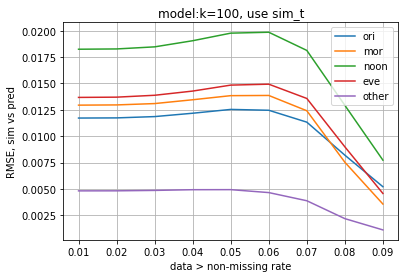

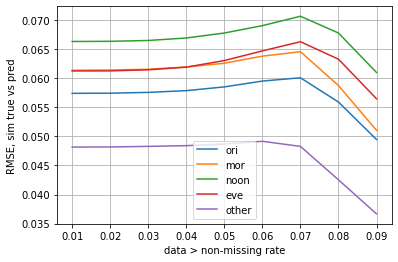

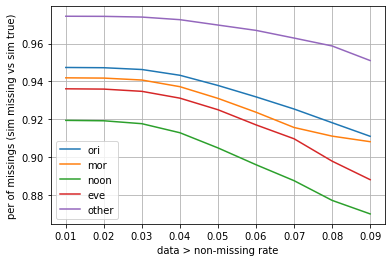

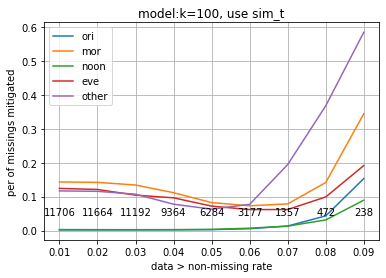

In [138]:
plot_paras(result_para_dict_simt_nmf_100, x_val_simt, 100, 'sim_t', ypop_simt)

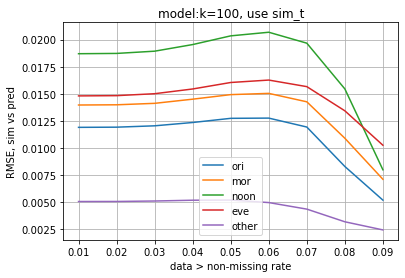

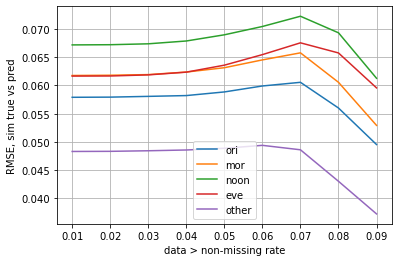

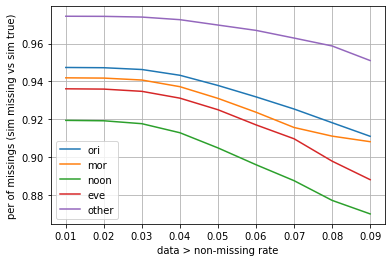

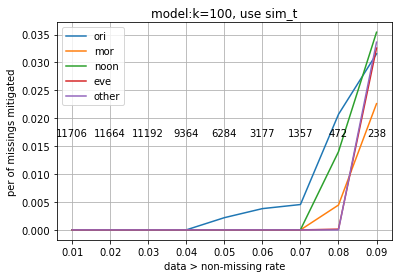

In [139]:
plot_paras(result_para_dict_simt_bmf_100, x_val_simt, 100, 'sim_t', ypop_simt)

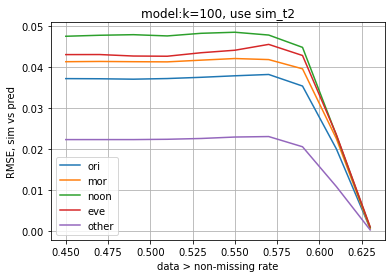

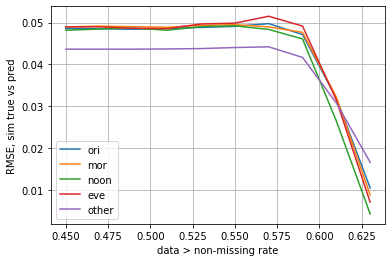

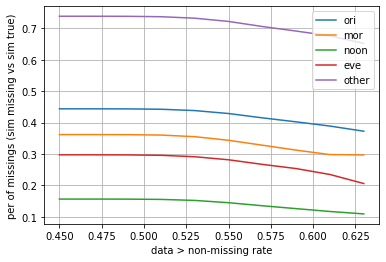

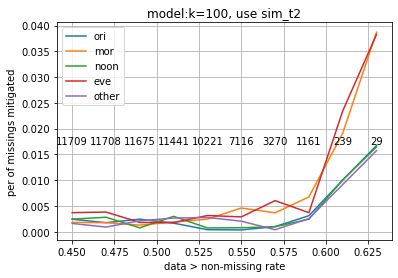

In [136]:
plot_paras(result_para_dict_simt2_bmf_100, x_val_simt2, 100, 'sim_t2', ypop_simt2)

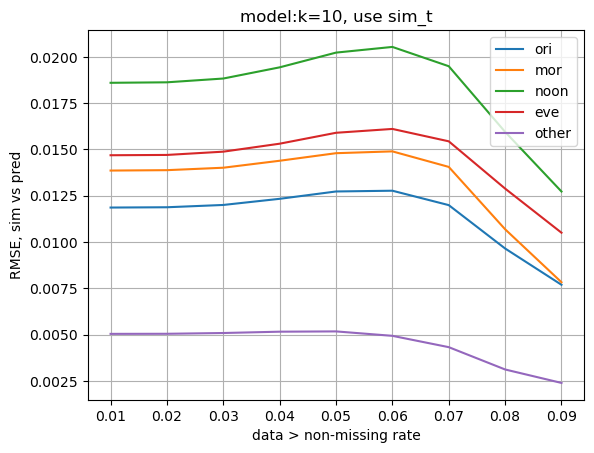

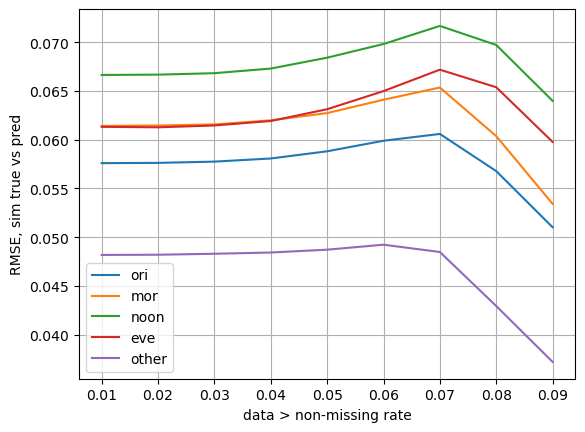

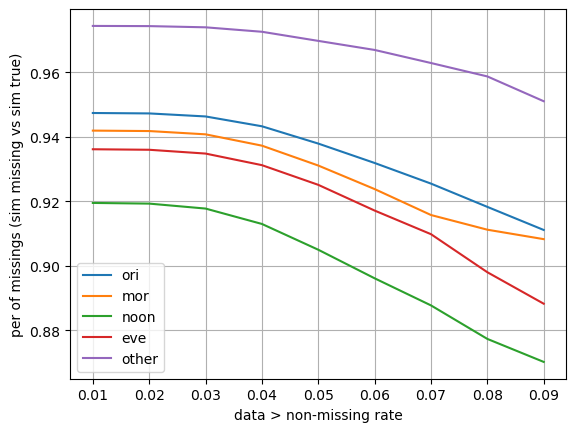

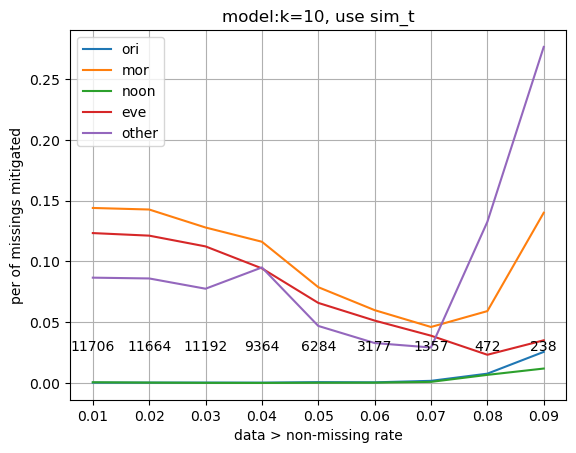

In [91]:
plot_paras(result_para_dict_simt, x_val_simt, 10, 'sim_t', ypop_simt)

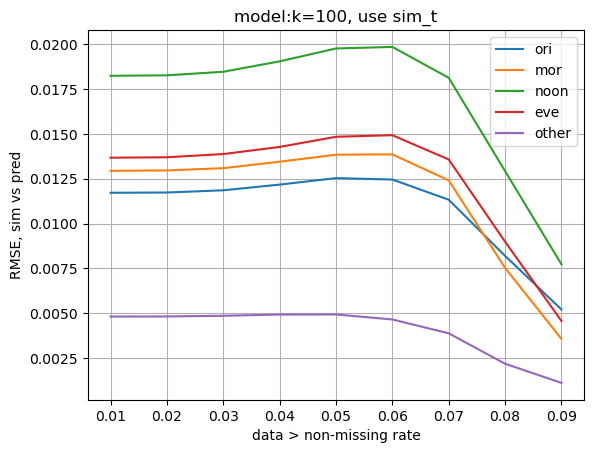

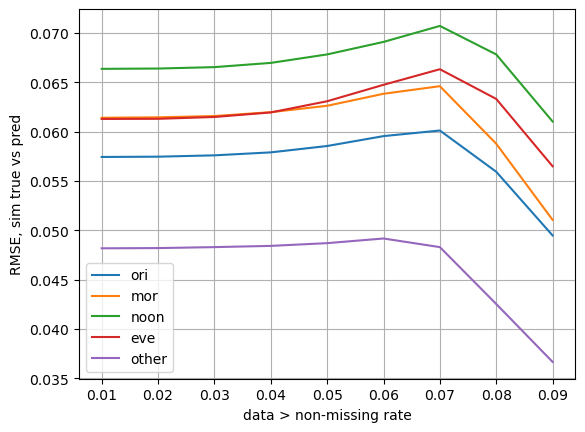

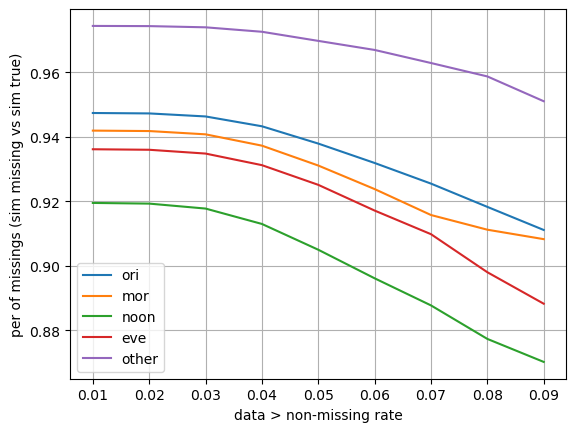

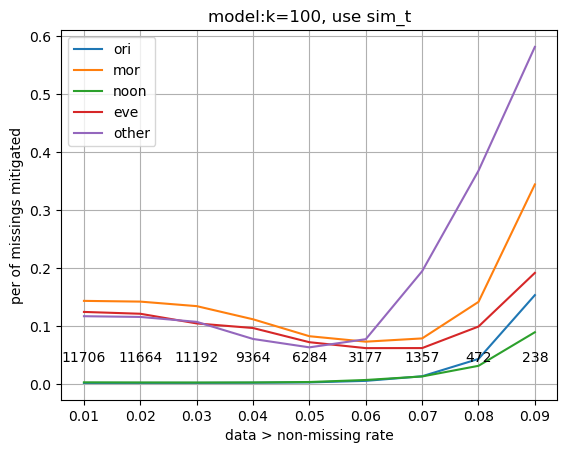

In [92]:
plot_paras(result_para_dict_simt_100, x_val_simt, 100, 'sim_t', ypop_simt)

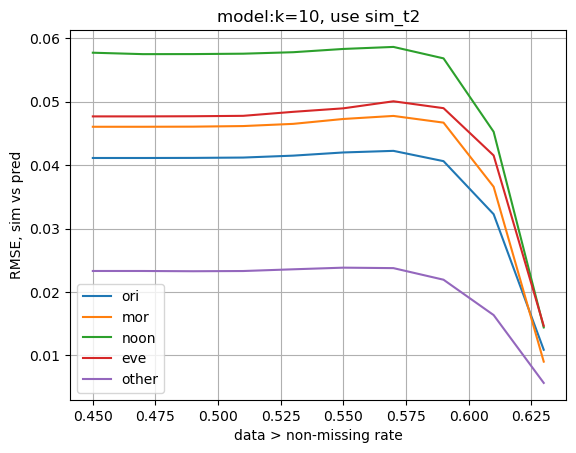

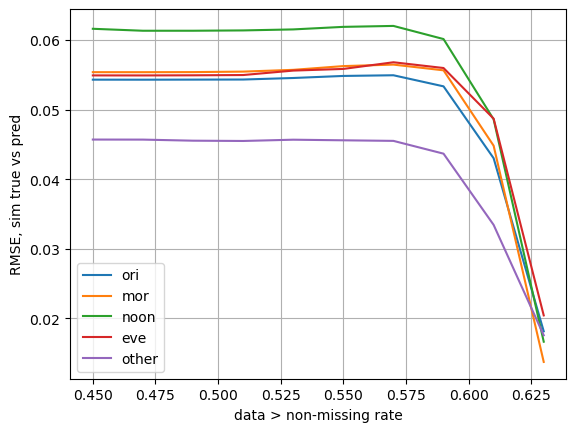

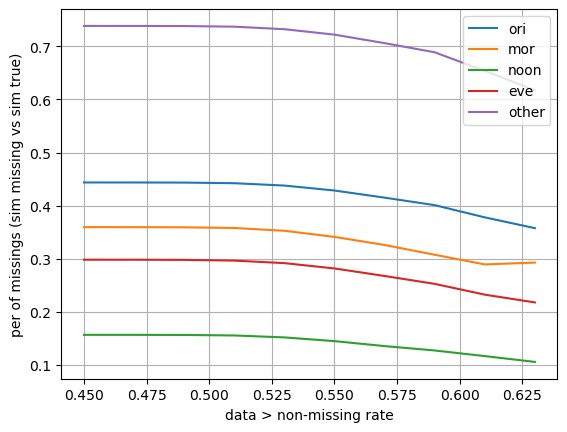

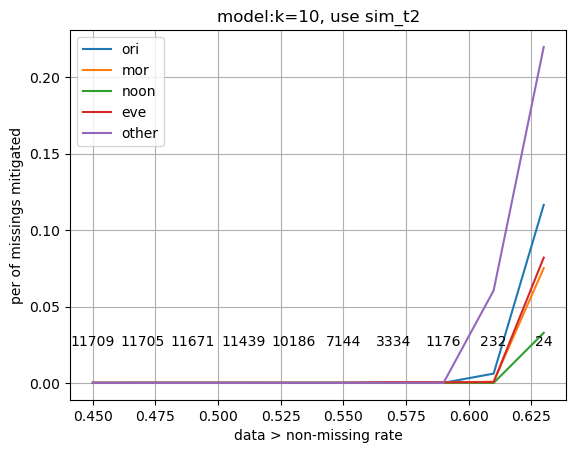

In [93]:
plot_paras(result_para_dict_simt2, x_val, 10, 'sim_t2', ypop_simt2)

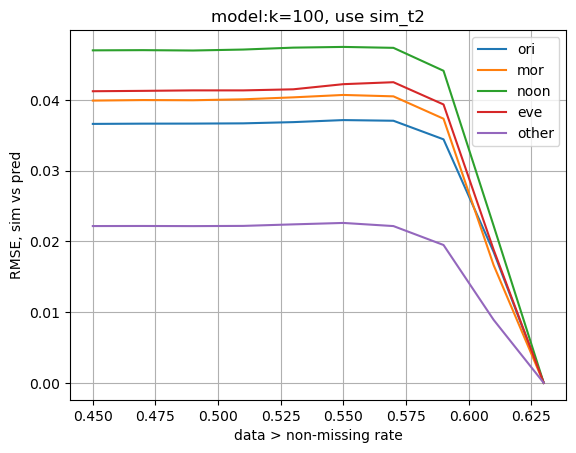

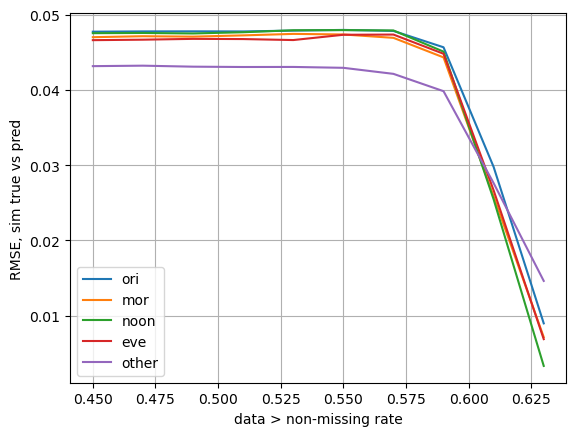

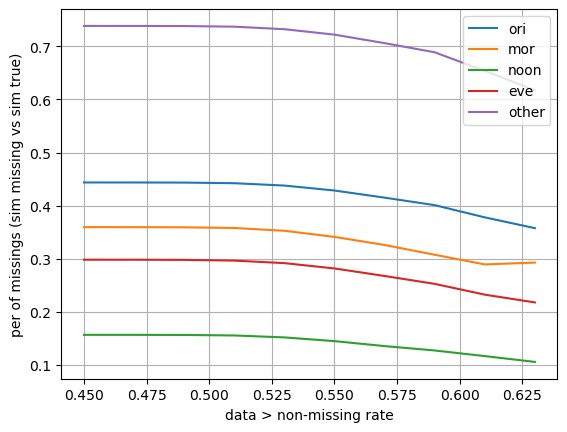

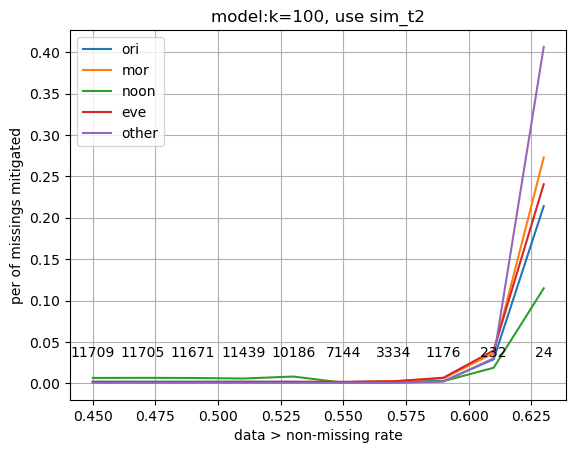

In [94]:
#plot_paras(result_para_dict_simt_100, x_val, 100, 'sim_t')
plot_paras(result_para_dict_simt2_100, x_val, 100, 'sim_t2', ypop_simt2)

In [137]:
#save_result_dict(result_para_dict_simt, "result_para_dict_simt_k10.txt")
#save_result_dict(result_para_dict_simt_bmf_100, "result_para_simt_k100_bmf.txt")
#save_result_dict(result_para_dict_simt_nmf_100, "result_para_simt_k100_nmf.txt")
save_result_dict(result_para_dict_simt2_bmf_100, "result_para_simt2_k100_bmf.txt")

In [ ]:
#data
result_para_dict_simt ={'ori': {'rmse_predvssim': [0.007690334758278416,
   0.011861481770917106,
   0.011877536296354201,
   0.012001591648297517,
   0.012333412474008829,
   0.012729749571966173,
   0.012770963765824813,
   0.011992614263893142,
   0.009650150431630694],
    'rmse_predvstrue': [0.051016427193137544,
   0.057591293538391555,
   0.05761897340150735,
   0.057746840221452135,
   0.05806906215263047,
   0.05880726664682562,
   0.059887635174768555,
   0.060584920113530394,
   0.05677436238546328],
    'per of missings (sim missing vs sim true)': [0.911108193277311,
   0.9473901679100936,
   0.9472590758840116,
   0.946319543721706,
   0.9432730700318003,
   0.9379050189193012,
   0.931887830937642,
   0.9254866740358634,
   0.9182703625235404],
    'per of missings mitigated': [0.02562008614753967,
   0.00036099353686940016,
   0.00036045797961888244,
   0.00036554165076642446,
   0.0003199875464306254,
   0.000742306085790553,
   0.0005793668013440371,
   0.0018053885179502066,
   0.007714738916571868]},                   
    'mor': {'rmse_predvssim': [0.007828231347560718,
   0.013859302799877782,
   0.01388070242604708,
   0.014012703450132393,
   0.014389104925496029,
   0.01479752473155533,
   0.014895481608422963,
   0.014056608880928344,
   0.010688582884434163],  
     'rmse_predvstrue': [0.053418281987026695,
   0.061409481654068586,
   0.06145347607074007,
   0.061559866704815516,
   0.0619822568105651,
   0.06272493392831388,
   0.06409554392871193,
   0.06534559487715583,
   0.060358234150394596],
       'per of missings (sim missing vs sim true)': [0.9082633053221288,
   0.9419291151736052,
   0.941791457094955,
   0.9407736676991502,
   0.9372626845127913,
   0.9310948440483768,
   0.9237925366348407,
   0.9157455170719725,
   0.9111935028248588],
      'per of missings mitigated': [0.14006682086867128,
   0.1439850457495264,
   0.14271409136655355,
   0.12791749879303205,
   0.11620325679289772,
   0.07883742570120968,
   0.05994926932687211,
   0.04611498569384836,
   0.05916166117677453]},
'noon': {'rmse_predvssim': [0.012727082029697806,
   0.018599294114145782,
   0.018625756960884653,
   0.018830281157937768,
   0.01943439020966053,
   0.020230021374531098,
   0.0205370567774557,
   0.019494547469498524,
   0.015948706624935666],
           'rmse_predvstrue': [0.06397895272199196,
   0.06663463440471604,
   0.06666683229718667,
   0.06681604334763545,
   0.06729071592148717,
   0.06840617573166134,
   0.06980675343678953,
   0.0716626726709641,
   0.06970939212550449],
   'per of missings (sim missing vs sim true)': [0.8701855742296919,
   0.9194973019534142,
   0.919286908436214,
   0.9177500297831784,
   0.9129778940623665,
   0.904978583174199,
   0.8961185867170286,
   0.8877118644067796,
   0.8773172669491526],
  'per of missings mitigated': [0.011920329946685444,
   0.0006290470711084486,
   0.00034875836194317667,
   0.00016226193132263758,
   9.503896597605019e-05,
   0.00025826966650242426,
   0.0003292976082017058,
   0.0009511950468679741,
   0.006716474228360123]},
 'eve': {'rmse_predvssim': [0.010502100208879794,
   0.014686795660785661,
   0.014703299983863547,
   0.014880110096300274,
   0.015310394182962388,
   0.015899886455230366,
   0.016107691438151106,
   0.015438681984233605,
   0.012885753461279553],
  'rmse_predvstrue': [0.059767333535504445,
   0.06131457613238765,
   0.06126603262672687,
   0.06145329045786582,
   0.06191236456627443,
   0.06312067571611471,
   0.06497919622359812,
   0.06717567682473358,
   0.06537460640518673],
     'per of missings (sim missing vs sim true)': [0.888235294117647,
   0.9361450782260623,
   0.9359861845972957,
   0.9348080261411212,
   0.9312137670104351,
   0.9251068473219969,
   0.9171275686856424,
   0.909801031687546,
   0.8980024213075061],
  'per of missings mitigated': [0.035139883768076766,
   0.12332745836244746,
   0.12121997241610334,
   0.11237004448595374,
   0.09430005635722617,
   0.06590716967778718,
   0.051363012355363794,
   0.038948415912614845,
   0.023255813953488372]},
'other': {'rmse_predvssim': [0.00238980846981346,
   0.0050391726058245725,
   0.00504378203699889,
   0.005085500808195335,
   0.005156913382794126,
   0.005172363428812574,
   0.004933129317534506,
   0.004321308784059673,
   0.003116114595040795],
  'rmse_predvstrue': [0.0372070395469539,
   0.04817776021159453,
   0.04820066095892989,
   0.048298424827468475,
   0.048426473670651636,
   0.04871799070733817,
   0.04922779459510219,
   0.04847803607771668,
   0.042936930492251904],
'per of missings (sim missing vs sim true)': [0.951038266546288,
   0.9743975329455968,
   0.974339353127232,
   0.9739660560376656,
   0.9725853541433519,
   0.9697565902646628,
   0.9669447501021027,
   0.9628921356663033,
   0.9587302143157305],
'per of missings mitigated': [0.27643493500803273,
   0.0866651885793117,
   0.08601381107795056,
   0.07757608932990441,
   0.09505327673228782,
   0.0469656941988261,
   0.03289661295095639,
   0.029221272074077823,
   0.13260889416491645]}}

result_para_dict_simt2 = {'ori' : {'rmse_predvssim': [
   0.04113807471040142,
   0.041164117749803227,
   0.04127143536381266,
   0.041567190570421526,
   0.04218157313979382,
   0.04286957179349329,
   0.04314950697886612,
   0.03977831916975735,
   0.03485291636914015],
   'rmse_predvstrue': [
   0.05431287678026451,
   0.05435014557879387,
   0.05448716410273881,
   0.05484531430515014,
   0.05568600774637898,
   0.056898355548439354,
   0.05785064294057926,
   0.0542894822785923,
   0.048350428694050526],                                
  'per of missings (sim missing vs sim true)': [
   0.4435424260113522,
   0.44352220983843926,
   0.44348021404177584,
   0.44300497769234415,
   0.4418435930758894,
   0.44063341552128144,
   0.43869493572422824,
   0.433674670433145,
   0.430015756302521],                               
  'per of missings mitigated': [
   2.6081251793086062e-05,
   2.5505170166468218e-05,
   3.4278486821670716e-05,
   5.440650869248604e-05,
   5.377386215132965e-05,
   4.216594033767477e-05,
   3.499582966363175e-05,
   0.0005597774460578097,
   0.001289228159457167]},                       
   'mor': {'rmse_predvssim': [
   0.04597298172474255,
   0.04601717229809827,
   0.046144403277808554,
   0.04660057885888863,
   0.047433923216744577,
   0.048615885076810215,
   0.04945095483562942,
   0.04432818987020974,
   0.03748786965187502],
   'rmse_predvstrue': [
   0.055399036920744674,
   0.05545326415940571,
   0.055584439135866526,
   0.0560854457813578,
   0.057016758976203744,
   0.05866908260866102,
   0.060247286692762074,
   0.05547474858257091,
   0.0486262611766219],
   'per of missings (sim missing vs sim true)': [   
   0.3610636520682651,
   0.36104681069958844,
   0.36098453260265273,
   0.35986223835967535,
   0.35826879553009405,
   0.35694925331374816,
   0.3531073446327684,
   0.3481638418079096,
   0.35049019607843135],
   'per of missings mitigated': [
   5.914904244272401e-05,
   5.936479667557139e-05,
   5.500360961188078e-05,
   4.945965328783045e-05,
   8.636750607657096e-05,
   7.348438456827924e-05,
   0.00017391304347826088,
   0.0005070993914807302,
   0.001665001665001665]},
 'noon': {'rmse_predvssim': [   
   0.05771133952731652,
   0.05752131332133793,
   0.057696402312049665,
   0.05826518868888879,
   0.059471278306711256,
   0.06113525305211396,
   0.06310008390125588,
   0.060859934607045016,
   0.05500693672224737],
   'rmse_predvstrue': [
   0.061613797851948586,
   0.06136875646013456,
   0.06155764213847834,
   0.062160208861244,
   0.0634247441808637,
   0.06523004889329768,
   0.06755932976446813,
   0.06579333521670577,
   0.06027021135687914],
'per of missings (sim missing vs sim true)': [
   0.15658369639501113,
   0.1565429240969365,
   0.15644824428162973,
   0.1560519898903603,
   0.15510622215149583,
   0.15412535410764872,
   0.15278801277327436,
   0.14740024717514122,
   0.14784663865546221],

   'per of missings mitigated': [
   7.956127639019123e-05,
   0.0001597371183423851,
   0.0001606253680998019,
   0.00017108395945310162,
   0.00014962060489473122,
   0.00012764056417129363,
   0.00010048231511254019,
   0.0002994460248540201,
   0.0014801657785671995]},

   'eve': {'rmse_predvssim': [
   0.04778408117262504,
   0.04764011329828683,
   0.04800422124918561,
   0.04851812369380867,
   0.049582772463760964,
   0.05134328993647618,
   0.05309201727423527,
   0.051402812871429435,
   0.04579020178523013],

  'rmse_predvstrue': [
   0.0551453194630221,
   0.054927172653105184,
   0.05538760865662916,
   0.05591716813559445,
   0.05707864368720805,
   0.05919619101862636,
   0.06168663692082968,
   0.06097255155453629,
   0.055411012288502565],
   'per of missings (sim missing vs sim true)': [
   0.2982353371897195,
   0.29829757005682933,
   0.2980955784744205,
   0.29774516384939276,
   0.29651268527780306,
   0.2938171680381312,
   0.29087272344457316,
   0.2889830508474577,
   0.28223289315726285],
   'per of missings mitigated': [
   0.00018004746705949752,
   0.00013959943174819548,
   0.00018840455596471695,
   0.00019470604511031634,
   0.00016867285133788238,
   0.0004897309540571148,
   0.00014477017734346723,
   0.00020946795140343527,
   0.0012760527435133986]},

  'other': {'rmse_predvssim': [
   0.02333749344820515,
   0.023349222593386593,
   0.02337498617324706,
   0.023339796774259253,
   0.023294053769046766,
   0.022940266313281808,
   0.021336176132825502,
   0.016983274665613873,
   0.013727346880013569],

   'rmse_predvstrue': [
   0.045554969162595,
   0.04557929714795551,
   0.04567460178028213,
   0.0457060480675748,
   0.04616244314046175,
   0.04675520401582132,
   0.046085124039845105,
   0.04040245722169883,
   0.034688090977294826],
  
   'per of missings (sim missing vs sim true)': [         
   0.7377822773657078,
   0.7377535172147967,
   0.7378056344850809,
   0.7374241423987065,
   0.7362408004587276,
   0.7353108733484731,
   0.7337527482231709,
   0.7280956716626978,
   0.7202930759080493],
   'per of missings mitigated': [
   8.61232481095947e-06,
   8.643673215369604e-06,
   9.00756635573882e-06,
   1.0771554478932037e-05,
   1.0717903006550425e-05,
   1.7688720963964538e-05,
   2.4900398406374503e-05,
   0.0004569174903205637,
   0.006267174468495396]}}

In [210]:
np.random.choice(list(range(non_zero_loc.shape[1])),size=int((non_zero_loc.shape[1])*missing_rate))

array([2793795,  202994, 2887327, ...,  506640, 2225479, 1055212])

In [167]:
#def fit_process_dt_nmf(sim_dt, missing_info, missing_val, k_val): 
    #predict data based on time



del(W, H)
print('RMSE, data with missing rate>='+str(missing_val)+', k='+str(k_val), model_rmse) 

array([    0, 31676], dtype=int64)

In [168]:
np.where(sim_dt_all>0)

(array([    0,     0,     0, ..., 11708, 11708, 11708], dtype=int64),
 array([31676, 32896, 33026, ..., 48957, 48958, 48959], dtype=int64))

In [141]:
###csv 2 fit data using r, 
###r dir: G:/My Drive/2021/Bias/PSRC_od_simulation_2018/ts_data_correlation.R
taz_time = fcd_dt.groupby(by=['taz', 'time_5_new']).size().to_frame()
taz_time.reset_index(inplace=True)
taz_time.columns = ['taz', 'time_5_new', 'num']

taz_time = taz_time[taz_time['taz']<=1000]
taz_dict = {}
idx = 0
for i in np.unique(taz_time.taz):
    #print(i)
    if i not in taz_dict:
        taz_dict[i] = idx
        idx+=1
        
get_tazid = lambda x: taz_dict[x]
taz_time['taz_id'] = taz_time['taz'].apply(get_tazid)
taz_total = ((fcd_dt[fcd_dt['taz']<1000]).groupby(by=['taz','reids']).size().to_frame()).groupby(by=['taz']).size().to_frame()
sum_val_sim = taz_total[0].values

origin_dt = pd.read_csv('../data-1670309862526.csv')
origin_dt.columns
sum_val_cuebiq = (origin_dt.groupby(by=['taz','newid']).size().to_frame()).groupby(by=['taz']).size().to_frame()
sum_val_cuebiq = sum_val_cuebiq[0].values

origin_dt = pd.read_csv('../data-1670309862526.csv')
get_time_5 = lambda x: int(x.split(':')[0])*12+int((int(x.split(':')[1]))/5)
origin_dt['time_5'] = origin_dt['time'].apply(get_time_5)

origin_dt = origin_dt.groupby(by=['taz','time_5']).size().to_frame()
origin_dt.reset_index(inplace=True)
origin_dt.columns = ['taz','time_5', 'num']

taz_dict = {}
idx = 0
for i in np.unique(origin_dt.taz):
    if i not in taz_dict:
        taz_dict[i] = idx
        idx += 1
origin_dt['taz_id'] = origin_dt['taz'].apply(get_tazid)

def convert_2mx(df, taz_col, time_col, val_col, sums_):
    origin_mx = np.zeros((len(np.unique(df[taz_col])), len(np.unique(df[time_col]))))
    for i in range(df.shape[0]):
        origin_mx[df[taz_col][i], df[time_col][i]] = df[val_col][i]
        
    num_taz = len(np.unique(df[taz_col]))
    taz_ = np.unique(df['taz']).reshape(num_taz, 1)
    sums_ = sums_.reshape(num_taz, 1)
    return(np.hstack((taz_, origin_mx, sums_)))

taz_time = convert_2mx(taz_time, 'taz_id', 'time_5_new', 'num', sum_val_sim)
origin_dt = convert_2mx(origin_dt, 'taz_id', 'time_5', 'num', sum_val_cuebiq)

#taz_time.to_csv('sim_taz_num.csv')
#origin_dt.to_csv('cuebiq_num.csv')
pd.DataFrame(taz_time).to_csv('sim_taz_num.csv')
pd.DataFrame(origin_dt).to_csv('cuebiq_num.csv')

In [ ]:
#algorithm, nmf test
WH_ts = fit_dt(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_ht10per_withstay.csv')
#pd.DataFrame(WH_index).to_csv('WH_index_t_100_ht10per_withstay.csv')
#del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt01(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_ht10per_withstay_01.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_ht10per_withstay_01.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay(fcd_dt, 'sim_t', 12, 100, '100t_ht10per01')

fit_dtbytime_stay(fcd_dt, 'sim_ts', 12, 100, '100ts_ht10per01')

In [ ]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

#algorithm, nmf test
WH_ts = fit_dt(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay(fcd_dt, 'sim_t', 12, 100, '100t_all10pe')

fit_dtbytime_stay(fcd_dt, 'sim_ts', 12, 100, '100ts_all10pe')

### Surprise application

In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import SVDpp
from surprise import get_dataset_dir, dump
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import NormalPredictor
#from surprise import NMF

In [27]:
#from surprise import BMF

In [10]:
#check similarity
len(np.unique(fcd_dt['reids']))

11709

In [11]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(fcd_dt[['id_index', 'ts_index', 'sim_t']], 
                            reader=reader)

In [12]:
train = data.build_full_trainset()
#test = data.build_anti_testset()

In [13]:
train.n_users

11709

In [14]:
train.n_items

49052

In [272]:
algo = NormalPredictor()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)

RMSE: 0.2631


0.263052824716942

In [273]:
algo = SVD()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)
del(predictions)

RMSE: 0.2012


0.20116639097274144

In [281]:
algo = KNNBaseline()
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1949


0.19494840144804554

In [17]:
#similarities between items
sim_options = {'name': 'cosine',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1554


0.15539946341857047

In [18]:
#similarities between items
sim_options = {'name': 'pearson',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [19]:
#'MSD'
algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [51]:
#similarities between items
sim_options = {'name': 'pearson_baseline',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1237


0.12368558609025071

In [50]:
for i in (fcd_dt[(fcd_dt['id_index']==0)&(fcd_dt['sim_t']==1)]).ts_index:
    print(algo.predict(0, i, verbose=True))

user: 0          item: 48672      r_ui = None   est = 0.98   {'actual_k': 40, 'was_impossible': False}
user: 0          item: 48672      r_ui = None   est = 0.98   {'actual_k': 40, 'was_impossible': False}
user: 0          item: 39539      r_ui = None   est = 0.90   {'actual_k': 5, 'was_impossible': False}
user: 0          item: 39539      r_ui = None   est = 0.90   {'actual_k': 5, 'was_impossible': False}
user: 0          item: 39545      r_ui = None   est = 0.33   {'actual_k': 21, 'was_impossible': False}
user: 0          item: 39545      r_ui = None   est = 0.33   {'actual_k': 21, 'was_impossible': False}
user: 0          item: 39546      r_ui = None   est = 0.53   {'actual_k': 13, 'was_impossible': False}
user: 0          item: 39546      r_ui = None   est = 0.53   {'actual_k': 13, 'was_impossible': False}
user: 0          item: 39575      r_ui = None   est = 0.57   {'actual_k': 14, 'was_impossible': False}
user: 0          item: 39575      r_ui = None   est = 0.57   {'actual_k': 1